# **Welcome to the Full Analysis**

Welcome! This notebook contains our complete, start-to-finish analysis pipeline. It is designed to act as a walkthrough, guiding you step-by-step through the physics logic, data processing, and visualization.

If you are already familiar with the workflow and just want a streamlined, ready-to-run version without all the detailed explanations, head over to **`Run_analysis/Run_analysis.ipynb`**.

In [2]:
# A time stamp to see the last update time 
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')
print(f"Last Updated: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")

Last Updated: 27 February 2026, 17:40 IST


# **Imports**

Let's bring in all the required Python libraries for our analysis. To keep things clean, we have grouped them into specific categories so you can easily see what each tool is used for.

In [3]:
# Handing file paths, memory management (garbage collection), and reading configurations
import os
import sys
import time
import gc
import psutil
import json
from pathlib import Path
import csv
import pandas as pd
from IPython.display import display

# Libraries for reading ROOT files and managing jagged arrays
import uproot
import awkward as ak
import numpy as np

# Plotting libraries, including mplhep for standard CMS styles
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import mplhep as hep

# Physics Kinematics & Histograms
# Tools for 4-vector math, filling multi-dimensional bins, and progress tracking
import vector
import hist
from hist import Hist
from tqdm.auto import tqdm

# Distributed Computing
# Dask tools to scale our event loop across multiple cluster workers
import dask
from dask.distributed import Client, LocalCluster, progress, as_completed
# Register vector behavior so it can process our awkward arrays of particles
vector.register_awkward()

print(" All imports loaded")

 All imports loaded


## **Setting up the Dask Client**

With our imports ready, the next step is to initialize the Dask client. We are connecting to `localhost:8786` here, but feel free to swap this out with your own scheduler address depending on the machine or cluster you are using.

In [4]:
client = Client("tls://localhost:8786")
client

<Client: 'tls://192.168.197.213:8786' processes=1 threads=1, memory=2.89 GiB>

## Directories and File Paths

This section sets up all the file paths required for the analysis. If you have cloned this repository, the folder structure is already set up for you, you just need to populate the directories with your dataset files. If you are writing this from scratch, make sure to point these variables to the correct locations on your machine.

Defining these dynamic paths clearly upfront ensures that you can run this notebook smoothly from anywhere without running into "file not found" errors later on.

In [33]:
# BASE PATHS
HOME_DIR = Path(os.environ.get("HOME", "/home/cms-jovyan"))
PROJECT_NAME = "H-to-WW-NanoAOD-analysis"

# DERIVED PATHS
PROJECT_DIR = HOME_DIR / PROJECT_NAME
DATASETS_DIR = PROJECT_DIR / "Datasets"
DATA_DIR = DATASETS_DIR / "DATA"
MC_DIR = DATASETS_DIR / "MC_samples"
AUX_DIR = PROJECT_DIR / "Auxillary_files"
OUTPUT_DIR = Path.cwd() / "Outputs"
PLOTS_DIR = OUTPUT_DIR / "Plots"
 
# Files
GOLDEN_JSON_PATH = AUX_DIR / "Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt"
LEPTON_ID_SF = AUX_DIR / "lepID_lookup.txt"

# RUN PERIODS
RUN_PERIODS_2016 = {
    'Run2016G': {'run_min': 278820, 'run_max': 280385},
    'Run2016H': {'run_min': 280919, 'run_max': 284044}
}
OUTPUT_DIR

PosixPath('/home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs')

## Setting Up Configurations and Labels

Next, let's set up the dictionaries and lists that will guide our analysis. 

Instead of hard-coding colors and labels later on, we define them all right here. We start by assigning a standard name, color, and stacking order to each of our Monte Carlo backgrounds and signal. Then, we map out the exact sequence of our cutflow stages so we can accurately track how many events survive our physics cuts. Finally, we include a list of LaTeX-formatted labels so that when we generate our plots at the end, the axes are already perfectly formatted.

In [6]:
# SAMPLE DEFINITIONS

# Sample mapping 
SAMPLE_MAPPING = {
    'data': 'Data',
    'higgs': 'ggH_HWW',
    'dytoll': 'DY_to_Tau_Tau',
    'top': 'Top_antitop',
    'fakes': 'Fakes',
    'vz': 'Diboson',
    'ggww': 'ggWW',
    'ww': 'WW',
    'vg': 'VG'
}

# Sample properties (color, signal flag, stacking order)
SAMPLES = {
    "Fakes":          {"color": "#B3B3B3", "is_signal": False, "stack_order": 1},
    "VG":             {"color": "#FFCC00", "is_signal": False, "stack_order": 2},
    "Diboson":        {"color": "#A6CEE3", "is_signal": False, "stack_order": 3},
    "DY_to_Tau_Tau":  {"color": "#33A02C", "is_signal": False, "stack_order": 4},
    "Top_antitop":    {"color": "#FF7F00", "is_signal": False, "stack_order": 5},
    "ggWW":           {"color": "#6BAED6", "is_signal": False, "stack_order": 6},
    "WW":             {"color": "#1F78B4", "is_signal": False, "stack_order": 7},
    "ggH_HWW":        {"color": "#E41A1C", "is_signal": True,  "stack_order": 8},
    "Data":           {"color": "#000000", "is_signal": False, "stack_order": -1},
}

# Derived helper dictionaries
colour = {name: props["color"] for name, props in SAMPLES.items()}
stack_order = {name: props["stack_order"] for name, props in SAMPLES.items() if props["stack_order"] >= 0}

# Sample order for printing (cutflow table)
sample_order = [
    'Data',
    'ggH_HWW',
    'WW',
    'Top_antitop',
    'DY_to_Tau_Tau',
    'Fakes',
    'ggWW',
    'Diboson',
    'VG',
]

dict_for_xsec_mapping = {
    "DYJetsToLL": "DYJetsToLL_M-50",
    "TTTo2L2Nu": "TTTo2L2Nu",
    "ST_t-channel_top": "ST_t-channel_top",
    "ST_t-channel_antitop": "ST_t-channel_antitop",
    "ST_tW_antitop": "ST_tW_antitop",
    "ST_tW_top": "ST_tW_top",
    "ST_s-channel": "ST_s-channel",
    "WJetsToLNu": "WJetsToLNu",
    "TTToSemiLeptonic": "TTToSemiLeptonic",
    "ZGToLLG": "ZGToLLG",
    "WGToLNuG": "WGToLNuG",
    "WZTo3LNu": "WZTo3LNu",
    "WZTo2Q2L": "WZTo2Q2L",
    "ZZ": "ZZ",
    "GluGluToWW": "GluGluToWW",
    "WWTo2L2Nu": "WWTo2L2Nu",
    "GluGluHToWW": "Higgs",
    "Higgs": "Higgs",
}

# CUTFLOW & ANALYSIS STAGES

# All cutflow stages
cutflow_stages = [
    'total', 'after_json', 'e_mu_preselection', 'global_cuts',
    '0jet', '1jet', '2jet',
    'SR_0jet', 'SR_1jet', 'SR_2jet',
    'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
    # 'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet',
    # 'CR_SS_0jet'  
    # 'CR_WW_0jet', 'CR_WW_1jet', 'CR_WW_2jet'
    
]

# Stage names for histogram initialization
stage_names = [
    'before_cuts', 'global', '0jet', '1jet', '2jet',
    'SR_0jet', 'SR_1jet', 'SR_2jet',
    'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
    # 'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet',
    # 'CR_SS_0jet' ,
    # 'CR_WW_0jet', 'CR'
]

# Stage info: (internal_name, display_name) for cutflow table
stage_info = [
    ('total', 'Total (Raw)'),
    ('e_mu_preselection', 'e-μ Preselect'),
    ('global_cuts', 'Global Cuts'),
    ('0jet', '0-jet'),
    ('1jet', '1-jet'),
    ('2jet', '2-jet'),
    ('SR_0jet', 'SR 0j'),
    ('SR_1jet', 'SR 1j'),
    ('SR_2jet', 'SR 2j'),
    ('CR_top_0jet', 'CR Top 0j'),
    ('CR_top_1jet', 'CR Top 1j'),
    ('CR_top_2jet', 'CR Top 2j'),
    # ('CR_tau_0jet', 'CR Tau 0j'),
    # ('CR_tau_1jet', 'CR Tau 1j'),
    # ('CR_tau_2jet', 'CR Tau 2j'),
]
# HISTOGRAM VARIABLE LABELS

VAR_LABELS = {
    'mass': r'$m_{e\mu}$ [GeV]',
    'met': r'$E_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]',
    'ptll': r'$p_{\mathrm{T}}^{\ell\ell}$ [GeV]',
    'dphi': r'$\Delta\phi(e,\mu)$',
    'mt_higgs': r'$m_{\mathrm{T}}^{H}$ [GeV]',
    'mt_l2_met': r'$m_{\mathrm{T}}(\ell_2, E_{\mathrm{T}}^{\mathrm{miss}})$',
    'mjj': r'$m_{jj}$ [GeV]',
    'leading_pt': r'$p_{\mathrm{T}}^{\mathrm{lead}}$ [GeV]',
    'subleading_pt': r'$p_{\mathrm{T}}^{\mathrm{sub}}$ [GeV]',
}

## Loading the Datasets

Instead of downloading massive ROOT files locally, we stream the data directly via URLs. The text files containing these URLs for both our collision Data and Monte Carlo (MC) samples are located in the **`Datasets/DATA`** and **`Datasets/MC_samples`** directories. (There is also a **README** in that folder if you want more details on the dataset specifics).

This next code block simply reads through those text files, extracts the URLs, and organizes them so our processor can read them.

> ***Tip**: At the bottom of the cell, you will notice a commented-out line that restricts the list to just one file per sample. This is very useful for running a quick local test to ensure your code works before sending the full job to the cluster.*

In [7]:
def load_urls_from_file(filepath, max_files=None):
    """Load XRootD URLs from text file"""
    urls = []
    if not os.path.exists(filepath):
        return urls
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls

def load_all_files(data_dir, mc_dir, max_per_sample=None):
    """Load all file URLs from directories"""
    
    files_dict = {}
    
    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue
        for filename in os.listdir(directory):
            if not filename.endswith(('.txt')):
                continue
            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')
            # Find label
            label = None
            for pattern, sample_label in SAMPLE_MAPPING.items():
                if pattern in filename_lower:
                    label = sample_label
                    break          
            if not label:
                print(f"   Unknown file: {filename} - skipping")
                continue
            
            # Load URLs
            urls = load_urls_from_file(filepath, max_per_sample)
            
            if urls:
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] = urls
    
    return files_dict

# files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=1)  # TESTING
files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)


FILES TO PROCESS
Data                :   48 files
VG                  :   32 files
ggH_HWW             :   40 files
WW                  :    7 files
Fakes               :  206 files
Diboson             :   73 files
DY_to_Tau_Tau       :   61 files
ggWW                :  112 files
Top_antitop         :  197 files
______________________________________________________________________
TOTAL               :  776 files


## Filtering Validated Runs

Not all the data collected by the detector is suitable for physics analysis. Sometimes certain subdetectors are offline or experiencing issues. To ensure we only process high-quality data, we use a JSON file (often called the "Golden JSON") to filter our dataset. This acts as a master list, keeping only the certified runs and luminosity blocks.

If you want to dive deeper into how this works, you can read more about [validated runs](https://cms-opendata-guide.web.cern.ch/analysis/selection/validatedRuns/).

In [8]:
def load_golden_json(json_input, run_periods=None):
    """
    Load golden JSON from either a file path (str) or a dict.
    """
    if isinstance(json_input, str):
        with open(json_input, 'r') as f:
            golden_json = json.load(f)
    elif isinstance(json_input, dict):
        golden_json = json_input
    else:
        raise TypeError(f"Expected str or dict, got {type(json_input)}")
    
    valid_lumis = {}
    for run_str, lumi_ranges in golden_json.items():
        run = int(run_str)
        
        # Filter by run periods 
        if run_periods is not None: 
            in_period = any(
                period['run_min'] <= run <= period['run_max']
                for period in run_periods.values()
            )
            if not in_period:
                continue
        
        valid_lumis[run] = [tuple(lr) for lr in lumi_ranges]
    
    return valid_lumis

def apply_json_mask(arrays, json_input, run_periods=None):

    valid_lumis = load_golden_json(json_input, run_periods)    
    runs = ak.to_numpy(arrays.run)
    lumis = ak.to_numpy(arrays.luminosityBlock)
    mask = np. zeros(len(runs), dtype=bool)
    
    for run, lumi_ranges in valid_lumis.items():
        run_mask = (runs == run)
        if not np.any(run_mask):
            continue
        # Check lumi sections 
        run_lumis = lumis[run_mask]
        run_lumi_mask = np.zeros(len(run_lumis), dtype=bool)
        for lumi_start, lumi_end in lumi_ranges: 
            run_lumi_mask |= (run_lumis >= lumi_start) & (run_lumis <= lumi_end)
        mask[run_mask] = run_lumi_mask
    
    return ak.Array(mask)

## Loading Only What We Need (Branches)

ROOT files contain hundreds of variables (called branches), but we definitely do not need to load all of them into memory. By using `uproot`, we can specify exactly which branches we care about, saving us a massive amount of RAM and processing time.

> **Wait, New to ROOT terminology?**\
> If words like "Trees" and "Branches" sound foreign to you, check out [the official ROOT manual](https://root.cern/manual/trees/) for a quick primer on how these data files are structured.


For this analysis, we are primarily interested in the kinematics of electrons, muons, and a few jet-related properties. 
* **For real Data:** We also load the `run` and `luminosityBlock` branches to apply the JSON validation we just talked about.
* **For Monte Carlo (MC):** We load the `genWeight` branch to handle theoretical event scaling (we will cover this in detail a bit later!).

In [9]:
def load_events(file_url, batch_size= 1_000_000, timeout=600, max_retries=3, retry_wait=10, is_data = False):

    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "PuppiMET_pt", "PuppiMET_phi",
        
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    if is_data:
        columns.extend(["run","luminosityBlock"])
    else: columns.append("genWeight")
        
    for attempt in range(max_retries):
        try:
            
            with uproot.open(file_url, timeout=timeout) as f:
                tree = f['Events']
                
                
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise

# **Event Selection**

Now that we are done with the  setup, we can get to the real physics. 

Let's take a look at the specific decay channel we are analyzing:

$$H \to WW \to e\nu_e + \mu\nu_\mu$$


Our target final state consists of an *electron*, a *muon*, and two *neutrinos*. In our dataset, this translates to an electron, a muon, and missing energy, because we cannot detect neutrinos directly with the detector. **Why?** 

To isolate this specific Higgs signal from the massive background of other collision events, we will now apply a series of targeted physics cuts.\
We will divide all the cuts into three categories:
- Pre-selection
- Global cuts
- Signal and Control Regions

## Pre-Selection: Selecting tight leptons

Let's kick things off by setting up our initial pre-selection cuts. 

The very first step is to isolate our "tight" leptons-which, for this analysis, means our electrons and muons. 

> **What makes a lepton "tight"?**
> In particle physics, a tight lepton is simply one that passes a very strict set of quality and isolation criteria. This helps us guarantee that the particle we are looking at is genuinely a high-quality electron or muon, rather than a fake signal or background noise.

To handle this data efficiently, we use the `ak.zip` function from Awkward Array. This allows us to bundle all the relevant particle properties into a single, neatly structured array.

In [10]:
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

## Pre-Selection: Finding Our Lepton Pair

Now that we have our collection of "tight" leptons, we need to filter them down to the specific electron and muon candidates that match our signal. 

First, we require exactly two leptons per event. Because the W bosons in our signal have opposite charges ($W^+W^-$), we specifically look for an electron and a muon with opposite electrical charges. 

Next, we apply a few essential kinematic cuts:
* **Transverse Momentum ($p_T$):** The leptons must pass a specific $p_T$ threshold. This ensures we are looking at real, high-energy physics events rather than low-energy background noise.
* **Pseudorapidity ($|\eta|$):** We restrict the particles to the geometric acceptance range of the detector. If a particle is produced at an angle too close to the beamline (a very high $|\eta|$), the CMS detector cannot measure it accurately.

In [11]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=13):
    """Select events with exactly 1 electron and 1 muon"""
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    # Require exactly 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    # mask_loose_veto = ak.num(loose_leptons)
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    # Pre-Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    eta_leading = ((leading.flavor == 11) & (abs(leading.eta) < 2.5)) | \
                       ((leading.flavor == 13) & (abs(leading.eta) < 2.4))
    eta_subleading = ((subleading.flavor == 11) & (abs(subleading.eta) < 2.5)) | \
                          ((subleading.flavor == 13) & (abs(subleading.eta) < 2.4))
    mask_eta = eta_leading & eta_subleading
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt & mask_eta
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]

## Jet Selection and Lepton Cleaning

Next up, we need to look at the jets in our event. Jets are essentially concentrated sprays of particles produced by quarks and gluons. 

First, we bundle the jet properties and apply some quality checks. For jets with lower momentum ($p_T < 50$ GeV), we also require a passing "Pileup ID".  

>**Why?**
> Because the LHC smashes many protons together at once, creating overlapping background collisions (pileup) that can fake low-energy jets. 

Then comes a crucial step: **Lepton Cleaning**. We calculate the angular distance, known as $\Delta R$, between all of our jets and the tight leptons we selected earlier. If a jet is too close to an electron or muon ($\Delta R < 0.4$), we throw the jet away.  

>**Why do we do this?**
>Because a high-energy electron deposits a lot of energy into the calorimeter, and the detector's clustering algorithms might accidentally label that energy splash as a "jet". We clean them to ensure we are not double-counting our leptons!

Finally, we sort our surviving, clean jets by their $p_T$ and categorize the event into one of three bins: **0-jet**, **1-jet**, or **2-jet**.

In [12]:
def count_jets(arrays, jet_pt_threshold=30, tight_leptons=None):
    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "puId": arrays.Jet_puId 
    })
    # Step 2: Good jet selection
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.eta) < 4.7) & pu_id_mask
    # Step 3: Lepton cleaning
    if tight_leptons is not None and ak.max(ak.num(tight_leptons)) > 0:
        # Delta R calculation
        jets_eta = jets.eta[:, :, None]
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :]
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2 * np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        min_dr = ak.min(dr, axis=-1)
        
        min_dr = ak.fill_none(min_dr, 999.0)
        good_mask = good_mask & (min_dr > 0.4)
    
    good_jets = jets[good_mask]
    
    # Step 4: Sort by pT
    sorted_jets = good_jets[ak.argsort(good_jets.pt, axis=1, ascending=False)]
    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt), 0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets[:, 1:].pt), 0)
    # Step 5: Category masks based on jet count
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold) # At least 2 jets
    
    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis=1)
    
    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet

## Hunting for b-jets (and why we veto them)

Now we need to identify "b-jets"-jets that originate from bottom quarks.

**Why do we care about b-jets?** Because of top quarks! A top quark decays almost exclusively into a W boson and a bottom quark. Since top-antitop pair production ($t\bar{t}$) produces two W bosons, it mimics our $H \to WW$ signal perfectly and is one of our biggest backgrounds. 

In the code below, we identify these b-jets and split our logic into two paths:
* **The Signal Region Veto:** If we are looking for our Higgs signal, we *veto* (throw away) any event that contains a b-jet. This effectively kills that massive top quark background.
* **The Top Control Region:** If we want to study our background to understand it better, we do the exact opposite. We deliberately *require* events to have b-jets, giving us a pure sample of top quarks to measure.

In [13]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        # Counts
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }

def apply_bjet_selections(arrays):
    bjet_info = get_bjet_categories(arrays)
    # For Signal Regions
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    return sr_bjet_veto, bjet_info

## Global Cuts

With our particles clearly identified and cleaned, we now apply a set of "global" baseline cuts. Every single event must pass these filters, regardless of how many jets it has. 

Here are the three fundamental physics checks we perform in this block:

* **Missing Transverse Energy (MET > 20 GeV):** We require a noticeable amount of missing energy in the transverse plane.

  >**Why?**
  >Because our $H \to WW$ signal produces two neutrinos that escape the detector entirely! If an event has almost zero missing energy, it is highly unlikely to be the signal we are looking for.

* **Dilepton Momentum ($p_T^{\ell\ell} > 30$ GeV):** The combined transverse momentum of our electron and muon system must be reasonably high. 
* **Invariant Mass ($m_{\ell\ell} > 12$ GeV):** The calculated invariant mass of the electron-muon pair must be at least 12 GeV. This low-mass threshold is a standard trick to strip away background noise from low-mass resonances.

In [14]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    # Combine all masks
    global_mask =  mask_met_pt & mask_ptll & mask_mll
    return global_mask, {
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

## Defining the Signal Regions (SR)

After all the cleaning and baseline filtering, we finally define our **Signal Regions**. A signal region is a highly restrictive subset of our data where we expect our $H \to WW$ signal to be the most prominent compared to the background.

To enter the signal region, an event must pass our previous global cuts, survive the b-jet veto, and pass two new, crucial kinematic thresholds:

* **Higgs Transverse Mass ($m_T^H > 60$ GeV)**
* **Subleading Lepton Transverse Mass ($m_T(\ell_2, E_T^{miss}) > 30$ GeV)**

>**Why do we use "Transverse Mass" instead of normal mass?** \
>Because of our invisible neutrinos! If we could detect all the decay products, we would simply calculate the standard invariant mass, and our signal would form a peak right at the Higgs mass (125 GeV). But since the neutrinos escape, we only have the *transverse* (perpendicular) components of the missing energy. 

By calculating the transverse mass ($m_T$), we can still reconstruct a recognizable shape for our Higgs signal, even with missing pieces! The cut on the subleading lepton's $m_T$ specifically helps us suppress backgrounds where a fake lepton or a mismeasured jet creates artificial missing energy.

Finally, the function splits our surviving events into three distinct buckets:
* **SR_0jet:** The cleanest region, dominated by standard gluon-gluon fusion.
* **SR_1jet:** Slightly messier, but still holds a lot of signal.
* **SR_2jet:** Here, we also apply an $m_{jj}$ (invariant mass of the two jets) window cut.

In [15]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    sr_specific_cuts = (
                        ( met.pt > 20) &
                        ( ptlls > 30) &
                       ( masses > 12)  &
                        (mt_higgs >60) &
                        (mt_l2_met >30) &
                        bjet_veto_mask        
                        )
    sr_base =  sr_specific_cuts
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    return sr_regions

## Defining the Control Regions (CR)

While the Signal Region is designed to capture our Higgs boson, a **Control Region** does the exact opposite. A control region is a specialized subset of data deliberately designed to be entirely background! 

>**Why do we want a region full of background?**\
>Because simulations aren't perfect. By creating a region rich in a specific background (like top quarks or Z bosons) but free of any Higgs signal, we can compare our Monte Carlo simulations to real Data. If they match well in the Control Region, we can trust our background estimates in the Signal Region. 

In this block, we define two main types of control regions:

### 1. The Top Control Region (`CR_top`)
To isolate events where top quarks were produced, we take our baseline cuts and explicitly *require* the presence of b-tagged jets. 

We also require the invariant mass of the leptons to be greater than 50 GeV ($m_{\ell\ell} > 50$). Since, top quarks are massive, and the leptons they produce tend to have a wide opening angle and high momentum, pushing their combined invariant mass higher.

### 2. The Tau-Tau Control Region (`CR_tau`)
One of our trickiest backgrounds is the Drell-Yan process where a Z boson decays into two tau leptons ($Z \to \tau\tau$), which then decay into an electron, a muon, and *four* neutrinos! 

To isolate this background, we do two things:
* **We invert the Higgs cut:** We require $m_T^H < 60$ GeV. Since our Signal Region required this to be *greater* than 60, this ensures our Tau-Tau Control Region has absolutely zero overlap with our signal.
* **We apply a shifted Z-mass window:** We restrict the lepton invariant mass to be between 40 and 80 GeV.
  >**Why not the actual Z boson mass of 91 GeV?** \
  > Because the tau leptons decay and release neutrinos, carrying away a chunk of the energy. This shifts the visible mass of the electron-muon pair significantly lower than the true Z mass peak!

Just like before, we split these control regions into 0-jet, 1-jet, and 2-jet categories to match the structure of our signal regions.

In [16]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    cr_base = (
        (met.pt > 20) &
        (ptlls > 30) &
        (mt_l2_met > 30)    &
        (masses > 12)
    )
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    cr_regions = {}
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    # # === TAU-TAU CONTROL REGIONS ===
    # cr_tau_base = (
    #     cr_base & 
    #     (mt_higgs < 60) & 
    #     (masses > 40) & 
    #     (masses < 80) &
    #     bjet_info['passes_bjet_veto']  
    # )
    # cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    # cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    # cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    return cr_regions

## Calculating Kinematic Variables

Now that we have isolated the exact particles we want, we need to calculate the final variables that will define our signal regions and fill our histograms. 

To do this, we use the `cal_kinematic_var` function. You will notice the very first thing we do is pass our raw particle data into the `vector` library to create a `lepton_vector`. 

>**Why do we use a special `vector` library for this?**
>Because these particles are moving at nearly the speed of light in three-dimensional space! Calculating how their energies and momenta combine using standard trigonometry is a massive headache. The `vector` library handles all that complex relativistic math behind the scenes. 

Instead of writing out long equations, we can treat the particles as simple objects. If we want to know the properties of the combined electron-muon system, we literally just add them together in the code: `dilepton = lepton_1 + lepton_2`. The library instantly calculates their combined invariant mass and momentum for us!

Once we have our vectors set up, we calculate a few key features:

* **Mass and Momentum (`masses`, `ptll`):** We simply ask our new `dilepton` object for its combined mass and transverse momentum.
* **Angular Difference (`dphi`):** We calculate the angle between the electron and the muon. 
* **Transverse Mass (`mt_higgs`, `mt_l2_met`):** Finally, we mix the properties of our visible leptons with the Missing Transverse Energy (MET). As we discussed earlier, this helps us reconstruct the mass of the Higgs and the W boson even though the neutrinos escaped the detector.

In [17]:
def wrap_angle_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties """
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })
    
def cal_kinematic_var(leading, subleading, met):
    # Create vectors
    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)
    dilepton = lepton_1 + lepton_2
    #  Basic Variables
    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)
    # Higgs Transverse Mass 
    dll_et = np.sqrt(dilepton.pt**2 + dilepton.mass**2)
    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    term_1 = masses**2
    term_2 = 2 * (dll_et * met.pt - dilepton.pt * met.pt * np.cos(mt_higgs_dphi))
    mt_higgs = np.sqrt(term_1 + term_2)
    # Lepton 2 Transverse Mass
    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))

    return masses, ptll, dphi, mt_higgs, mt_l2_met

## The 2-Jet Category and the Mass Window

Remember earlier when we sorted our events into 0-jet, 1-jet, and 2-jet categories? If an event lands in the 2-jet bucket, we need to take one extra step to analyze the relationship between those two jets.

First, we use `calculate_mjj`. Just like we did with our electron and muon, we use 4-vectors to combine the two highest-energy jets and calculate their combined invariant mass ($m_{jj}$). 

Next, we pass that mass into `apply_mjj_window`. If you look closely at the math, you will notice we keep events where $m_{jj} < 65$ or $m_{jj} > 105$. This means we are deliberately *excluding* all events that land right in the middle between 65 and 105 GeV. 

> **Why do we cut out the middle?**\
> Because that specific mass range is exactly where the W and Z bosons live! 

If the two jets have a combined mass in that 65-105 GeV window, they most likely came from a background W or Z boson decaying into quarks, rather than the specific Higgs process we are hunting for. Slicing out that middle part is a effective way to cut down our background!

In [18]:
def calculate_mjj(jets):
    # Get number of jets per event
    n_jets = ak.num(jets)
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

# **DATA-MC Corrections**

## Scaling the Monte Carlo Simulations

Next, we define our `LUMINOSITY` and a large dictionary containing the specific properties of our Monte Carlo (MC) samples.

> **Why do we need to scale our simulations?**  
> Because MC generators create as many events as we ask them to! A simulation might generate 10 million top quark events and 10 million Higgs events so that we have enough statistics to study them. However, in the real detector, top quarks are produced thousands of times more often than Higgs bosons.

To make our simulated backgrounds accurately represent the real world, we must scale each MC event so that the proportions match reality. We do this using three key numbers:

* **Luminosity ($L$):** The total amount of data collected. For our [2016G and 2016H data](https://opendata.cern.ch/record/1059), this is $16{,}393 \text{ pb}^{-1}$. You can read [this](https://cds.cern.ch/record/941318/files/p361.pdf) if you want to learn more about luminosity in collisions.
* **Cross Section ($\sigma$):** The fundamental quantum mechanical probability of a specific physics process occurring during a proton–proton collision.
* **Sum of Generator Weights:** The total initial weight of all the simulated events in that specific dataset. `genWeight` is a branch inside our tree that we extracted from the MC ROOT files earlier.

Later in the processor, we will combine these to calculate a universal scale factor for every simulated event:

$$
\text{Scale Factor} = \frac{\sigma \times L \times \text{genWeight}}{\sum \text{genWeight}}
$$

The `get_sample_key` function below acts as our lookup tool. When we feed a file into our processor, it checks the filename against this dictionary to retrieve the correct cross section. Notice how it deliberately skips filenames containing `Run2016` or `SingleMuon`? That is because real collision data is already physical—it should not be scaled.

*Tip: If you want to dive deeper into exactly where these samples and cross-section numbers come from, refer to the **`Datasets/README_MC_Samples_2016UL.md`** and to see how the Sum_genweight is calculated refer **`notebooks/sum_genWeight`** file for detailed dataset documentation.*

In [19]:
# Luminosity for 2016 UltraLegacy  (pb^-1)
LUMINOSITY = 16_393.0 
sample_info_detailed = {
    #   DRELL-YAN  
    "DYJetsToLL_M-50":      { "xsec": 6025.20, "sum_genWeight": 82448537.0 },
    #   TOP QUARK  
    "TTTo2L2Nu":            { "xsec": 87.31, "sum_genWeight": 3140127171.4748 },
    "ST_t-channel_top":     { "xsec": 44.33, "sum_genWeight": 6703802049.126 },
    "ST_t-channel_antitop": { "xsec": 26.38, "sum_genWeight": 1522100315.652 },
    "ST_tW_top":            { "xsec": 35.60, "sum_genWeight": 20635251.1008 },
    "ST_tW_antitop":        { "xsec": 35.60, "sum_genWeight": 27306324.658 },
    "ST_s-channel":         { "xsec": 3.36,  "sum_genWeight": 19429336.179 },
    #   FAKES  
    "WJetsToLNu":           { "xsec": 61526.7, "sum_genWeight": 9697410121705.164 },
    "TTToSemiLeptonic":     { "xsec": 364.35,  "sum_genWeight": 43548253725.284 },
    #   V+GAMMA  
    "ZGToLLG":              { "xsec": 131.30,   "sum_genWeight": 3106465270.711 },
    "WGToLNuG":             { "xsec": 405.271, "sum_genWeight": 3353413.0 },
    #   DIBOSON  
    "WZTo3LNu":             { "xsec": 4.42965, "sum_genWeight": 4077550.6318 },
    "WZTo2Q2L":             { "xsec": 5.595,   "sum_genWeight": 129756627.882 },
    "ZZ":                   { "xsec": 16.523,  "sum_genWeight": 1151000.0 },
    #   SIGNAL & IRREDUCIBLE  
    "GluGluToWW":           { "xsec": 0.5905, "sum_genWeight": 17662000.0 },
    "WWTo2L2Nu":            { "xsec": 12.1780,  "sum_genWeight": 32147079.595 },
    "Higgs":                { "xsec": 1.0315,  "sum_genWeight": 63281816.82 }
}


def get_sample_key(filename, dict_for_xsec_mapping):
    fn = filename
    if any(x in fn for x in ["Run2016", "SingleMuon", "DoubleEG", "MuonEG"]):
        return None
    for key, value in dict_for_xsec_mapping.items():
        if key in fn:
            return value
    return "Unknown"

## Applying Scale Factors to the Simulation

In this step, we apply two important corrections to ensure that our Monte Carlo simulation reflects the real CMS detector as closely as possible.

### 1. Lepton ID and Isolation Scale Factors

Even with a very detailed detector simulation, the efficiency for identifying and isolating leptons in Monte Carlo is not perfectly identical to what is observed in real data. Small differences arise from detector response, reconstruction algorithms, and calibration effects.

To correct for this, we load precomputed scale factor (SF) lookup tables from `Auxillary_files/lepID_lookup.txt`. These tables encode data-to-simulation efficiency ratios as functions of lepton transverse momentum ($p_T$) and pseudorapidity ($\eta$).

Later, inside the event loop, the `get_sf_with_uncertainty` function evaluates each simulated lepton’s $p_T$ and $\eta$, retrieves the appropriate correction factor from the lookup table, and assigns a weight to that particle. In effect, every simulated lepton is adjusted so that the overall identification and isolation efficiency matches what was measured in real collision data.
To see how the look-up table has been created and how these numbers are obtained see **`notebooks/Muon_EFF.ipynb`** and **`notebooks/Eff_txt_file_cleaning.ipynb`** \


**NOTE TO SELF: ADD THE LOCATIONS OF THIS NOTEBOOKS**

---

### 2. High-Level Trigger (HLT) Efficiency

Unline real collision data, the MC samples do not pass any trigger. To account for this difference, we apply a global trigger scale factor.
A detailed procedure for getting the Trigger SF is shown in **`notebooks/Trigger_efficiency.ipynb`**


In [20]:
def load_lepID_data(filepath):
    """Reads a text file containing Python variables and returns a dictionary of those variables."""
    local_vars = {}
    with open(filepath, 'r') as f:
        exec(f.read(), {}, local_vars)
        
    return local_vars
    
def get_sf_with_uncertainty(eta_array, pt_array, lookup_table):
    sf_out = ak.ones_like(eta_array, dtype=float)
    err_out = ak.zeros_like(eta_array, dtype=float)
    eta_abs = abs(eta_array)
    for (eta_min, eta_max, pt_min, pt_max, sf_val, err_val) in lookup_table:
        mask = (eta_abs >= eta_min) & (eta_abs < eta_max) & \
               (pt_array >= pt_min) & (pt_array < pt_max)
        sf_out = ak.where(mask, sf_val, sf_out)
        err_out = ak.where(mask, err_val, err_out)
    return sf_out, err_out
    
lep_data = load_lepID_data(LEPTON_ID_SF)

ELECTRON_SF_DATA = lep_data.get('ELECTRON_SF_DATA', [])
MUON_ISO_DATA = lep_data.get('MUON_ISO_DATA', [])
MUON_TIGHT_DATA = lep_data.get('MUON_TIGHT_DATA', [])

TRIGGER_SF_VAL = 0.9129
TRIGGER_SF_ERR = 0.0008

# Histogram Initialization

With the event selection done, we need a structured way to store the results. In this block, we initialize the empty histograms that will eventually hold all of our processed data.

We start by defining the **variations** for our systematic uncertainties.

Next, we define `variables_to_plots`. This dictionary uses the `hist` library to set up the axes, bin counts, and ranges for all the kinematic variables we want to study (like $m_{\ell\ell}$, MET, and $\Delta\phi$).

Finally, the `initialize_stage_histograms` function builds a nested dictionary to keep everything highly organized. For every physics sample (like Data, Top quarks, or our Higgs signal), it generates a dedicated histogram for:
1. Every stage/region of our analysis (e.g., SR_0jet, CR_top_1jet)
2. Every kinematic variable
3. Every systematic variation

In [21]:
VARIATIONS = ['nominal', 'trigger_up', 'trigger_down', 'ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']

variables_to_plots = {
    'mass': hist.axis.Regular(20, 0, 200, name="mass", label="m_ll [GeV]"),
    'met': hist.axis.Regular(20, 0, 200, name="met", label="MET [GeV]"),
    'dphi': hist.axis.Regular(20, 0, np.pi, name="dphi", label="dphi(l,l)"),
    'ptll': hist.axis.Regular(20, 0, 200, name="ptll", label="p_T^ll [GeV]"),
    'mt_higgs': hist.axis.Regular(20, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
    'mt_l2_met': hist.axis.Regular(20, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
    'mjj': hist.axis.Regular(20, 0, 500, name="mjj", label="m_jj [GeV]"),
    'leading_pt': hist.axis.Regular(20, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
    'subleading_pt': hist.axis.Regular(20, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
}

def initialize_stage_histograms(stages_list, vars_dict, variations_list):
    stage_histograms = {}
    for stage in stages_list:
        stage_histograms[stage] = {}
        for var_name, axis in vars_dict.items():
            stage_histograms[stage][var_name] = {}
            for syst in variations_list:
                stage_histograms[stage][var_name][syst] = hist.Hist(axis, storage=hist.storage.Weight())
    return stage_histograms

hist_data = {}


for label in sorted(stack_order.keys(), key=lambda x: stack_order[x]):
    hist_data[label] = initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)

print(f"Histogram storage initialized for {len(hist_data)} samples.")

Histogram storage initialized for 8 samples.


# **Run Analysis**

## The Processor Function

We have finally arrived at the engine of our analysis: the `make_processor` function. This block ties together every single helper function, cut, and scale factor we have defined so far into one massive, automated assembly line.

Here is a flowchart mapping out exactly how an event travels through our logic, from raw data to a filled histogram:

![All the steps involved](../Images/flowchart.svg)

*Note: The flowchart illustrates our entire workflow, but the code in this block stops at the histogram-saving stage. The remaining steps are covered below.*


While the flowchart covers the step-by-step physics, there are a few clever programming tricks happening in this block that are worth highlighting:

### 1. The Distributed Worker Setup
You might notice that we put `import uproot`, `import awkward`, and other libraries *inside* the `processing_file` function. \
>**Why import them again inside the function?**\
>Because we are designing this code to run on a distributed cluster using Dask. If we put the imports at the top of our notebook, the remote worker wouldn't have access to them. By putting them inside the worker function, we guarantee that every single node loads its own tools before it starts working.

### 2. The Cutflow Tracker
Throughout the code, you will see us adding numbers to `cutflow` and `weighted_cutflow` dictionaries. This acts as our accounting book. Every time we apply a cut (like filtering for 2 leptons, or vetoing b-jets), we record exactly how many events survived.

### 3. The `fill_histograms` Helper
Filling 9 different histograms across 7 systematic variations (like `trigger_up` or `mu_id_down`) for multiple regions would normally require hundreds of lines of repetitive code. Instead, we wrote a compact helper function that automatically applies the correct event mask and the correct systematic weight to all variables at once. 

### 4. Network Resilience
At the bottom of the loop, there is a `try/except` block that will attempt to read a file up to 3 times before giving up. 
>**Why do we need retries?** \
>Because we are streaming ROOT files over the internet from distant servers. Small network issues and dropped connections are inevitable! Instead of letting a 2-second network glitch crash our entire hours-long analysis, we tell the worker to sleep for 3 seconds and simply try again. If it completely fails, it returns empty histograms so the rest of the analysis can continue uninterrupted.

In [22]:
def make_processor(golden_json_data, sample_info_detailed, luminosity, run_periods):
    #        WORKER FUNCTION      
    def processing_file(label, file_url, file_idx):
        import uproot
        import awkward as ak
        import numpy as np
        import vector
        import time
        import hist 
        
        vector.register_awkward()
        
        file_name = file_url.split('/')[-1] 
        is_data = (label == 'Data')
        
        specific_sample_key = get_sample_key(file_url,dict_for_xsec_mapping)

        empty_cutflow = {stage: 0 for stage in cutflow_stages}
        
        #        Updated Fill Function      
        def fill_histograms(stage_name, mask, weights_dict, 
                           masses, met_pt, dphis, ptlls,
                           mt_higgs, mt_l2_met, mjj,
                           leading_pt, subleading_pt):
            
            if not isinstance(mask, np.ndarray):
                mask = ak.to_numpy(mask)

            if np.sum(mask) == 0:
                return

            def masked(arr, flatten=False):
                sliced = arr[mask]
                if flatten:
                    sliced = ak.flatten(sliced)
                return ak.to_numpy(sliced)

            # Loop over all systematic variations
            for syst in VARIATIONS:
                w_syst = weights_dict.get(syst, weights_dict['nominal'])
                w = masked(w_syst)

                stage_histograms[stage_name]['mass'][syst].fill(masked(masses), weight=w)
                stage_histograms[stage_name]['met'][syst].fill(masked(met_pt), weight=w)
                stage_histograms[stage_name]['dphi'][syst].fill(masked(dphis), weight=w)
                stage_histograms[stage_name]['ptll'][syst].fill(masked(ptlls), weight=w)
                stage_histograms[stage_name]['mt_higgs'][syst].fill(masked(mt_higgs), weight=w)
                stage_histograms[stage_name]['mt_l2_met'][syst].fill(masked(mt_l2_met), weight=w)
                stage_histograms[stage_name]['mjj'][syst].fill(masked(mjj), weight=w)
                stage_histograms[stage_name]['leading_pt'][syst].fill(masked(leading_pt), weight=w)
                stage_histograms[stage_name]['subleading_pt'][syst].fill(masked(subleading_pt), weight=w)
        
        try:
            # Use GLOBAL initialization
            stage_histograms = initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
            
            cutflow = empty_cutflow.copy()
            weighted_cutflow = {stage: 0.0 for stage in cutflow_stages}
            
            max_file_retries = 3
            
            for file_attempt in range(max_file_retries):
                try:
                    for arrays in load_events(file_url, batch_size= 1_000_000, is_data=is_data):
                        
                        cutflow['total'] += len(arrays)

                        #        SCALING & VARIATIONS INITIALIZATION      
                        if is_data:
                            base_weight = ak.ones_like(arrays.PuppiMET_pt, dtype=float)
                        elif specific_sample_key in sample_info_detailed:
                            info = sample_info_detailed[specific_sample_key]
                            scale_factor = (info['xsec'] * luminosity) / info['sum_genWeight']
                            base_weight = arrays.genWeight * scale_factor
                        else:
                            base_weight = ak.zeros_like(arrays.PuppiMET_pt, dtype=float)

                        # Initialize Dictionary of Weights
                        weights_dict = {v: base_weight for v in VARIATIONS}

                        #        APPLY TRIGGER SF & UNCERTAINTY (MC ONLY)      
                        if not is_data:
                            weights_dict['nominal'] = weights_dict['nominal'] * TRIGGER_SF_VAL
                            weights_dict['trigger_up']   = weights_dict['trigger_up'] * (TRIGGER_SF_VAL + TRIGGER_SF_ERR)
                            weights_dict['trigger_down'] = weights_dict['trigger_down'] * (TRIGGER_SF_VAL - TRIGGER_SF_ERR)
                            
                            for var in ['ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']:
                                weights_dict[var] = weights_dict[var] * TRIGGER_SF_VAL

                        weighted_cutflow['total'] += float(ak.sum(weights_dict['nominal']))
                        
                        #        JSON MASK (DATA ONLY)      
                        if is_data and golden_json_data is not None:
                            try:
                                json_mask = apply_json_mask(arrays, golden_json_data, run_periods=run_periods)
                                n_events_after = int(ak.sum(json_mask))
                                cutflow['after_json'] += n_events_after
                                weighted_cutflow['after_json'] += float(ak.sum(weights_dict['nominal'][json_mask]))

                                if n_events_after == 0:
                                    continue

                                arrays = arrays[json_mask]
                                for k in weights_dict:
                                    weights_dict[k] = weights_dict[k][json_mask]
                            except Exception as e: 
                                print(f"Warning: JSON mask failed for {file_name}: {e}")
                        
                        #        LEPTON SELECTION      
                        tight_leptons, _, _ = select_tight_leptons(arrays)
                        met = ak.zip({"pt": arrays.PuppiMET_pt, "phi": arrays.PuppiMET_phi})
                        
                        leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
                        
                        if leading is None or len(leading) == 0:
                            continue

                        sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                        has_2lep = ak.num(sorted_leptons) == 2
                        events_2lep = sorted_leptons[has_2lep]
                        
                        if len(events_2lep) == 0:
                            continue
                        
                        lead_all = events_2lep[:, 0]
                        sublead_all = events_2lep[:, 1]
                        
                        mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                     ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                        mask_charge = lead_all.charge * sublead_all.charge < 0
                        mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 13)
                        
                        eta_leading = ((lead_all.flavor == 11) & (abs(lead_all.eta) < 2.5)) | \
                                      ((lead_all.flavor == 13) & (abs(lead_all.eta) < 2.4))

                        eta_subleading = ((sublead_all.flavor == 11) & (abs(sublead_all.eta) < 2.5)) | \
                                         ((sublead_all.flavor == 13) & (abs(sublead_all.eta) < 2.4))
                        
                        mask_eta = eta_leading & eta_subleading
                        
                        emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt & mask_eta
                        
                        indices_2lep = ak.where(has_2lep)[0]
                        indices_selected = ak.to_numpy(indices_2lep[emu_mask_2lep])
                        
                        emu_mask_full = np.zeros(len(has_2lep), dtype=bool)
                        emu_mask_full[indices_selected] = True
                        
                        for k in weights_dict:
                            weights_dict[k] = weights_dict[k][emu_mask_full]

                        #        LEPTON SCALE FACTORS & UNCERTAINTIES (MC ONLY)      
                        if not is_data:
                            # 1. Prepare Electron SFs
                            is_lead_ele = (leading.flavor == 11)
                            ele_pt = ak.where(is_lead_ele, leading.pt, subleading.pt)
                            ele_eta = ak.where(is_lead_ele, leading.eta, subleading.eta)

                            # Get Nominal and Error
                            ele_sf_nom, ele_sf_err = get_sf_with_uncertainty(ele_eta, ele_pt, ELECTRON_SF_DATA)

                            # 2. Prepare Muon SFs
                            is_lead_mu = (leading.flavor == 13)
                            mu_pt = ak.where(is_lead_mu, leading.pt, subleading.pt)
                            mu_eta = ak.where(is_lead_mu, leading.eta, subleading.eta)

                            mu_tight_nom, mu_tight_err = get_sf_with_uncertainty(mu_eta, mu_pt, MUON_TIGHT_DATA)
                            mu_iso_nom, mu_iso_err = get_sf_with_uncertainty(mu_eta, mu_pt, MUON_ISO_DATA)
                            
                            # Combined Muon Nominal
                            mu_sf_nom = mu_tight_nom * mu_iso_nom
                            
                            # Combined Muon Error (conservative calculation)
                            mu_sf_up = (mu_tight_nom + mu_tight_err) * (mu_iso_nom + mu_iso_err)
                            mu_sf_down = (mu_tight_nom - mu_tight_err) * (mu_iso_nom - mu_iso_err)
                            
                            # Electron Up/Down
                            ele_sf_up   = ele_sf_nom + ele_sf_err
                            ele_sf_down = ele_sf_nom - ele_sf_err

                            # 3. Apply to Weights
                            # Nominal
                            weights_dict['nominal'] = weights_dict['nominal'] * ele_sf_nom * mu_sf_nom
                            
                            # Trigger Variations
                            weights_dict['trigger_up']   = weights_dict['trigger_up'] * ele_sf_nom * mu_sf_nom
                            weights_dict['trigger_down'] = weights_dict['trigger_down'] * ele_sf_nom * mu_sf_nom
                            
                            # Electron Variations
                            weights_dict['ele_id_up']    = weights_dict['ele_id_up'] * ele_sf_up * mu_sf_nom
                            weights_dict['ele_id_down']  = weights_dict['ele_id_down'] * ele_sf_down * mu_sf_nom
                            
                            # Muon Variations
                            weights_dict['mu_id_up']     = weights_dict['mu_id_up'] * ele_sf_nom * mu_sf_up
                            weights_dict['mu_id_down']   = weights_dict['mu_id_down'] * ele_sf_nom * mu_sf_down
                        
                        cutflow['e_mu_preselection'] += len(leading)
                        weighted_cutflow['e_mu_preselection'] += float(ak.sum(weights_dict['nominal']))
                        
                        #        KINEMATICS & FILLING      
                        masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(
                            leading, subleading, met_selected
                        )
                        
                        mjj_before = ak.zeros_like(masses)
                        all_true = np.ones(len(masses), dtype=bool)
                        
                        fill_histograms(
                            'before_cuts', all_true, weights_dict,
                            masses, met_selected.pt, dphis, ptlls,
                            mt_higgs, mt_l2_met, mjj_before,
                            leading.pt, subleading.pt
                        )
                        
                        indices_emu = indices_selected
                        
                        n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                            arrays, tight_leptons=tight_leptons
                        )
                        
                        mjj_full = calculate_mjj(sorted_jets_full)
                        mjj_selected = ak.fill_none(mjj_full[indices_emu], 0.0)
                        
                        global_cut_mask, _ = apply_global_cuts(
                            leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses
                        )
                        bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
                        bjet_veto_selected = bjet_veto_full[indices_emu]
                        bjet_info_selected = {
                            key: value[indices_emu] for key, value in bjet_info_full.items()
                        }
                        
                        global_mask_selected = global_cut_mask & bjet_veto_selected
                        global_mask_np = ak.to_numpy(global_mask_selected)
                        
                        cutflow['global_cuts'] += int(np.sum(global_mask_np))
                        weighted_cutflow['global_cuts'] += float(ak.sum(weights_dict['nominal'][global_mask_np]))
                        
                        if np.sum(global_mask_np) == 0:
                            continue
                        
                        fill_histograms(
                            'global', global_mask_np, weights_dict,
                            masses, met_selected.pt, dphis, ptlls,
                            mt_higgs, mt_l2_met, mjj_selected,
                            leading.pt, subleading.pt
                        )
                        
                        # Jet categories
                        isZeroJet = ak.to_numpy(isZeroJet_full[indices_emu])
                        isOneJet = ak.to_numpy(isOneJet_full[indices_emu])
                        isTwoJet = ak.to_numpy(isTwoJet_full[indices_emu])

                        # # ====================================================================================
                        # # ---------------- ADDED: DATA-DRIVEN SCALE FACTORS (BIN-BY-BIN) ---------------------
                        # # ====================================================================================
                        # sf_weight = np.ones(len(isZeroJet), dtype=float)

                        # if label in ['WW', 'ggWW']:
                        #     sf_weight = np.where(isZeroJet, sf_weight * 0.7744, sf_weight)
                        #     sf_weight = np.where(isOneJet,  sf_weight * 0.8788, sf_weight)
                        #     sf_weight = np.where(isTwoJet,  sf_weight * 1.2644, sf_weight)

                        # elif label == 'Top_antitop':
                        #     sf_weight = np.where(isZeroJet, sf_weight * 0.9172, sf_weight)
                        #     sf_weight = np.where(isOneJet,  sf_weight * 0.9883, sf_weight)
                        #     sf_weight = np.where(isTwoJet,  sf_weight * 0.9209, sf_weight)

                        # elif label == 'Fakes':
                        #     sf_weight = np.where(isZeroJet, sf_weight * 0.2946, sf_weight)

                        # # Apply the scale factors to all systematic variations seamlessly
                        # for k in weights_dict:
                        #     weights_dict[k] = weights_dict[k] * sf_weight
                        # ====================================================================================

                        jet_categories = [
                            ('0jet', isZeroJet),
                            ('1jet', isOneJet),
                            ('2jet', isTwoJet)
                        ]
                        
                        for jet_name, jet_mask in jet_categories:
                            mask = global_mask_np & jet_mask
                            n_events = int(np.sum(mask))
                            cutflow[jet_name] += n_events
                            weighted_cutflow[jet_name] += float(ak.sum(weights_dict['nominal'][mask]))
                            
                            fill_histograms(
                                jet_name, mask, weights_dict,
                                masses, met_selected.pt, dphis, ptlls,
                                mt_higgs, mt_l2_met, mjj_selected,
                                leading.pt, subleading.pt
                            )
                        
                        # Signal and Control Regions
                        sr_regions = apply_signal_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_veto_selected, mjj_selected
                        )
                        
                        cr_regions = apply_control_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_info_selected, mjj_selected
                        )
                        
                        all_regions = {**sr_regions, **cr_regions}
                        
                        for region_name, region_mask in all_regions.items():
                            region_mask_np = ak.to_numpy(region_mask)
                            n_events = int(np.sum(region_mask_np))
                            cutflow[region_name] += n_events
                            weighted_cutflow[region_name] += float(ak.sum(weights_dict['nominal'][region_mask_np]))
                            
                            fill_histograms(
                                region_name, region_mask_np, weights_dict,
                                masses, met_selected.pt, dphis, ptlls,
                                mt_higgs, mt_l2_met, mjj_selected,
                                leading.pt, subleading.pt
                            )
                    
                    # Return results
                    return label, stage_histograms, cutflow, weighted_cutflow, None
                    
                except (OSError, IOError, ValueError) as e:
                    if file_attempt < max_file_retries - 1:
                        print(f"  {label}/{file_name}: {type(e).__name__} - Retry {file_attempt+1}/{max_file_retries}")
                        time.sleep(3)
                        continue
                    else: 
                        error_msg = f"{file_name}: {type(e).__name__} after {max_file_retries} attempts - {str(e)[:100]}"
                        # Call Global Initialization on Failure
                        return label, initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
                
                except Exception as e:
                    error_msg = f"{file_name}: {type(e).__name__} - {str(e)[:100]}"
                    # Call Global Initialization on Failure
                    return label, initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
            
            return label, stage_histograms, cutflow, weighted_cutflow, None
            
        except Exception as e:
            import traceback
            error_msg = f"{file_name}: Unexpected error - {str(e)[:100]}"
            # Call Global Initialization on Failure
            return label, initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg

    return processing_file

## Executing the Analysis with Distributed Dask

With our `make_processor` function defined, this cell handles the actual computational execution. Because HEP datasets contain millions of events spread across hundreds of ROOT files, running this sequentially on a single machine is impractical. (I tried; it took me around 4-5 hours to run this analysis!)

Instead, we utilize **Dask** to parallelize the workload across a distributed cluster. Here is a technical breakdown of the mechanics within this execution block:

### 1. Task Distribution via `client.map`
Instead of a standard `for` loop, we use `client.map(processing_task, arg_labels, arg_urls, arg_indices, retries=1)`. 
* Dask takes our `processing_task` function and maps it element-wise across the lists of file URLs and labels. For a deeper look at how this operates, you can review how Dask handles [submitting tasks with client.map](https://distributed.dask.org/en/stable/client.html#distributed.Client.map).
* This creates an independent **Task** for every single ROOT file. 
* The Dask Scheduler instantly distributes these tasks across all available Worker nodes in the cluster. If a worker crashes or experiences a network timeout while reading a remote file, the `retries=1` argument instructs the scheduler to automatically reassign that task to a healthy worker.


### 2. Non-Blocking Execution and Futures
When `client.map` is called, it does not wait for the computation to finish. Instead, it instantly returns a list of **Futures**. A Future is simply a pointer to a computation that is currently happening in the background on a remote worker, which is how Dask manages [Futures for asynchronous computation](https://distributed.dask.org/en/stable/manage-computation.html). This allows the main Jupyter notebook thread to remain active and responsive while the cluster handles the heavy processing.

### 3. Asynchronous Aggregation (`as_completed`)
To collect the results, we wrap our list of Futures in Dask's `as_completed()` iterator, an approach designed to handle [task streams efficiently](https://distributed.dask.org/en/stable/api.html#distributed.as_completed).
* **Why not use `client.gather()`?** If we waited for all tasks to finish and gathered them simultaneously, we would pull hundreds of dictionaries containing complex histograms into our local RAM all at once. This almost guarantees an Out-Of-Memory (OOM) crash.
* **The Streaming Solution:** `as_completed` yields a Future the exact millisecond its specific worker finishes, regardless of the order they were submitted. This prevents the entire pipeline from stalling if one worker gets stuck on a particularly large or slow file.

### 4. On-the-Fly Reduction and Memory Management
As each worker returns its tuple of results (label, histograms, cutflows), we immediately merge them into our master dictionaries (`hist_data_final` and `cutflow_final`).

* Because the `hist` library supports mathematical addition, we can incrementally add the bins of a single file's histogram directly into the master histogram using the `+=` operator.
* Once the merge is complete, we call `del result` to immediately destroy the local copy of the worker's output. Combined with `gc.collect()` at the end of the script, this adheres to Dask's best practices for [managing worker memory and avoiding OOM errors](https://distributed.dask.org/en/stable/worker-memory.html). It ensures our local memory footprint remains completely flat throughout the entire execution, no matter how many terabytes of data the cluster processes.

### 5. Persistence
Finally, the aggregated master histograms are exported to a single ROOT file (`HWW_analysis_output.root`) using `uproot.recreate`. This effectively reduces terabytes of distributed raw data into a few megabytes of dense, statistical distributions, ready for local plotting and limit-setting.

If you are new to `Dask` and want to explore plese refer [Dask](https://docs.dask.org/en/stable/).

In [23]:
print("\n" + "="*70)
print("PROCESSING START!! ")
print(f"Output Directory: {OUTPUT_DIR}")
print("="*70)

golden_json_data = None
if GOLDEN_JSON_PATH.exists():
    with open(GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)
# 1. PREPARE PROCESSOR
processing_task = make_processor(
    golden_json_data=golden_json_data, 
    sample_info_detailed=sample_info_detailed, 
    luminosity=LUMINOSITY,                     
    run_periods=RUN_PERIODS_2016
)

# 2. INITIALIZE ACCUMULATORS
print("Initializing storage...")
hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}  

for label in files.keys():
    hist_data_final[label] = initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
    cutflow_final[label] = {stage: 0 for stage in cutflow_stages}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in cutflow_stages}

# 3. PREPARE FILE LISTS
arg_labels = []
arg_urls = []
arg_indices = []

print("Preparing file lists...")
for label, urls in files.items():
    is_data = (label == 'Data')
    if is_data and golden_json_data is not None:
         print(f"  {label}: Validation enabled ({len(urls)} files)")
    
    for file_idx, file_url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(file_url)
        arg_indices.append(file_idx)

# 4. SUBMIT TO CLUSTER
print(f"\nSubmitting {len(arg_urls)} files to the cluster...")
start_time = time.perf_counter()

futures = client.map(
    processing_task, 
    arg_labels, 
    arg_urls, 
    arg_indices,
    retries=1  
)

# 5. STREAMING MERGE LOOP WITH TQDM
print("Processing and merging results as they arrive...")
error_count = 0

for future in tqdm(as_completed(futures), total=len(futures), unit="file"):
    try:
        result = future.result()
        if not result: 
            continue
        
        label, stage_histograms, cutflow, weighted_cutflow, error = result
        
        if error:
            error_count += 1
            print(f" ERROR: {error}")
            continue

        # A. Merge Cutflows
        if cutflow:
            for stage, count in cutflow.items():
                cutflow_final[label][stage] += count
        
        if weighted_cutflow:
            for stage, count in weighted_cutflow.items():
                weighted_cutflow_final[label][stage] += count
        
        # B. Merge Histograms
        if stage_histograms:
            for stage_name, var_dict in stage_histograms.items():
                for var_name, syst_dict in var_dict.items():
                    for syst_name, hist_obj in syst_dict.items():
                        # In-place addition
                        hist_data_final[label][stage_name][var_name][syst_name] += hist_obj
                        
        # Clear memory immediately after merging
        del result, stage_histograms, cutflow, weighted_cutflow

    except Exception as e:
        print(f"CRITICAL CLIENT ERROR: {e}")
        error_count += 1

elapsed = time.perf_counter() - start_time

# 6. SAVE RESULTS
print("\n" + "="*70)
print("File processing complete. Saving results...")
print("="*70)

root_file_path = OUTPUT_DIR / "HWW_analysis_output.root"
print(f"\nSaving histograms to ROOT file: {root_file_path.name}...")

try:
    with uproot.recreate(root_file_path) as root_file:
        for sample, stages in hist_data_final.items():
            for stage, variables in stages.items():
                for var_name, variations in variables.items():
                    for syst_name, hist_obj in variations.items():
                        # Clean name for ROOT: Sample_Stage_Variable_Variation
                        hist_name = f"{sample}_{stage}_{var_name}_{syst_name}"
                        hist_name = hist_name.replace(" ", "_").replace("-", "_")
                        # Write to file
                        root_file[hist_name] = hist_obj
                        
    print("  Success! ROOT file saved.")
except Exception as e:
    print(f"  Error saving ROOT file: {e}")

# 7. FINAL REPORT
print("\n" + "="*70)
print(f"{'SAMPLE':20s} | {'EVENTS':>12s}")
print("-" * 35)
total_events = 0

for label in sorted(files.keys()):
    events = cutflow_final[label].get('total', 0) if 'total' in cutflow_final[label] else 0
    total_events += events
    print(f"{label:20s} | {events:>12,}")

print("-" * 35)
print(f"{'TOTAL':20s} | {total_events:>12,}")
print("="*70)

if error_count > 0:
    print(f"\n WARNING: {error_count} file(s) failed during processing.")

print(f"\nProcessing completed in {elapsed:.1f}s ({elapsed/60:.1f} min)")
if len(futures) > 0 and elapsed > 0:
    print(f"Average: {elapsed/len(futures):.2f}s per file")
    print(f"Throughput: {total_events/elapsed:,.0f} events/sec")
print("="*70 + "\n")

# Cleanup
del futures, arg_urls, arg_labels, arg_indices
gc.collect()


PROCESSING START!! 
Output Directory: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs
Initializing storage...
Preparing file lists...
  Data: Validation enabled (48 files)

Submitting 776 files to the cluster...
Processing and merging results as they arrive...


  0%|          | 0/776 [00:00<?, ?file/s]


File processing complete. Saving results...

Saving histograms to ROOT file: HWW_analysis_output.root...
  Success! ROOT file saved.

SAMPLE               |       EVENTS
-----------------------------------
DY_to_Tau_Tau        |   82,448,537
Data                 |   63,091,128
Diboson              |   15,551,954
Fakes                |  225,680,227
Top_antitop          |  137,367,000
VG                   |   34,915,878
WW                   |    2,900,000
ggH_HWW              |    2,946,000
ggWW                 |   17,662,000
-----------------------------------
TOTAL                |  582,562,724

Processing completed in 490.2s (8.2 min)
Average: 0.63s per file
Throughput: 1,188,398 events/sec



0

# Closing the Dask Client

Finally, it's always a good practice to cleanly shut down the Dask client we initialized at the start of the notebook and delete the variables associated with it.

**But why do we need to do this?**

Well, Dask workers reserves a lot of CPU and memory. If we don't explicitly close the client, those resources stay locked up, which can slow down your machine or leave "zombie" processes eating up your RAM in the background. Plus, failing to close the client can leave network ports blocked, meaning you might run into annoying port conflict errors the next time you try to run the notebook. 

In [24]:
client.close()
del client

# Outputs

With the processing complete, it is time to examine the results of our processing. 

During the Dask execution, we securely saved our aggregated data to disk:
* **Histograms:** Saved in the standard ROOT format at `Outputs/HWW_analysis_output.root`.
* **Cutflow Tables:** Saved to the `Outputs/` directory.

In [27]:
def get_cutflow_rows(cutflow_data, custom_stage_info=None, custom_sample_order=None):
    """
    Generates header and rows for the cutflow table.
    Returns the data as raw numbers (ints or floats).
    """
    current_stage_info = custom_stage_info if custom_stage_info is not None else stage_info 
    current_sample_order = custom_sample_order if custom_sample_order is not None else sample_order

    mc_samples = [s for s in current_sample_order if s != 'Data']
    table_stage_names = [s[1] for s in current_stage_info]
    stage_keys = [s[0] for s in current_stage_info]
    
    header = ['Sample'] + table_stage_names
    rows = []
    
    # 1. Fill rows for each sample
    for sample in current_sample_order:
        if sample not in cutflow_data: 
            continue
            
        row = [sample]
        for key in stage_keys:
            if sample == 'Data' and key == 'total':
                val = cutflow_data[sample].get('after_json', 0)
            else:
                val = cutflow_data[sample].get(key, 0)
            row.append(val)
        rows.append(row)

    # 2. Calculate Total MC row
    total_row = ['TOTAL (MC)']
    for idx, key in enumerate(stage_keys):
        total = sum(cutflow_data[s].get(key, 0) for s in mc_samples if s in cutflow_data)
        total_row.append(total)
    rows.append(total_row)
    
    return header, rows

def save_cutflows(cutflow_final, weighted_cutflow_final, output_dir):
    """
    Saves the Raw and Weighted cutflow tables to CSV files.
    - Raw events -> Cutflow_Raw.csv (Formatted as Integers, no scientific notation)
    - Weighted events -> Cutflow_scaled.csv (Formatted to 2 decimal places, no scientific notation)
    """
    
    # 1. Save Raw Events (Unweighted)
    header_raw, rows_raw = get_cutflow_rows(cutflow_final)
    raw_path = output_dir / "Cutflow_Raw.csv"
    
    # Format Raw numbers: Force 0 decimal places 
    formatted_rows_raw = []
    for row in rows_raw:
        sample_name = row[0]
        formatted = [sample_name] + [f"{float(val):.0f}" for val in row[1:]]
        formatted_rows_raw.append(formatted)
    
    try:
        with open(raw_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header_raw)
            writer.writerows(formatted_rows_raw)
        print(f"Saved Raw Cutflow to: {raw_path}")
    except Exception as e:
        print(f"Failed to save Raw CSV: {e}")

    # 2. Save Weighted Yields (Scaled)
    if weighted_cutflow_final:
        header_w, rows_w = get_cutflow_rows(weighted_cutflow_final)
        weighted_path = output_dir / "Cutflow_scaled.csv"
        
        # Format Weighted numbers: Force 2 decimal places 
        formatted_rows_w = []
        for row in rows_w:
            sample_name = row[0]
            formatted = [sample_name] + [f"{float(val):.2f}" for val in row[1:]]
            formatted_rows_w.append(formatted)

        try:
            with open(weighted_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(header_w)
                writer.writerows(formatted_rows_w)
            print(f"Saved Weighted Cutflow to: {weighted_path}")
        except Exception as e:
            print(f"Failed to save Weighted CSV: {e}")

In [ ]:
save_cutflows(
    cutflow_final=cutflow_final, 
    weighted_cutflow_final=weighted_cutflow_final, 
    output_dir=OUTPUT_DIR
)
df = pd.read_csv(OUTPUT_DIR / "Cutflow_scaled.csv", index_col=0)
rows_to_highlight = [df.index[0], df.index[-1]]
styled_df = df.style.format("{:,.2f}") \
    .background_gradient(cmap="Blues", axis=0) \
    .set_properties(
        subset=pd.IndexSlice[rows_to_highlight, :], 
        **{'font-weight': 'bold'}
    )

display(styled_df)

## Loading Processed Data from ROOT
Once the processing is done, it is generally not a good idea to rely solely on the results provided by the main processing loop—which in our case is `hist_data_final`. If the server unexpectedly crashes or we disconnect from it, we could lose all our progress. 

Therefore, we will use the `HWW_analysis_output.root` file that we created during the processing stage to load the dictionary containing all our information.

**Why is this the preferred workflow?**
* **Persistence:** The ROOT file acts as a permanent snapshot of our results. We can close the notebook, come back days later, and pick up exactly where we left off without rerunning the Dask cluster.
* **Memory Efficiency:** Instead of keeping every single histogram in the active Python RAM, we can use `uproot` to surgically extract only the specific regions or variables we need for a particular plot.
* **Portability:** This output file is relatively small (megabytes instead of the terabytes of raw data we started with), making it easy to share with collaborators or move to a local machine for final styling and plotting.

In the following cell, we use `uproot` to open this file and reconstruct our nested dictionary structure.

In [22]:
def restore_histograms(sample_list, stage_names, vars_dict, variations, root_file_path):
    """
    Reconstructs the full nested dictionary of histograms from a saved ROOT file.
    
    Parameters
    ----------
    sample_list : list
        List of sample names (e.g., files.keys()) to initialize.
    stage_names : list
        List of analysis stages (e.g., Config.stage_names).
    vars_dict : dict
        Dictionary of variables (e.g., Plots_config.variables_to_plots).
    variations : list
        List of systematic variations (e.g., Config.VARIATIONS).
    root_file_path : str or Path
        Path to the .root file.

    Returns
    -------
    dict
        The fully populated hist_data dictionary.
    """
    
    path = Path(root_file_path)
    if not path.exists():
        print(f"CRITICAL: ROOT file not found at {path}")
        return {}

    print(f"Restoring histograms from: {path.name}")
    
    hist_data = {}
    
    # Open file once
    with uproot.open(path) as file:
        # Loop through known structure to find matching keys
        for sample in sample_list:
            # 1. Initialize empty structure for this sample
            hist_data[sample] = initialize_stage_histograms(stage_names, vars_dict, variations)
            
            # 2. Fill with data from ROOT file
            for stage in stage_names:
                for var in vars_dict.keys():
                    for syst in variations:
                        # Reconstruct the key name used during saving
                        # Format: Sample_Stage_Variable_Variation
                        hist_name = f"{sample}_{stage}_{var}_{syst}"
                        hist_name = hist_name.replace(" ", "_").replace("-", "_")
                        
                        if hist_name in file:
                            # .to_hist() converts Uproot object back to boost_histogram
                            hist_data[sample][stage][var][syst] = file[hist_name].to_hist()
                            
    print(f"Successfully restored data for {len(hist_data)} samples.")
    return hist_data

# root_file_path
hist_data_final = restore_histograms(
    sample_list=sorted(files.keys()),       
    stage_names=stage_names,
    vars_dict=variables_to_plots,
    variations=VARIATIONS,
    root_file_path=OUTPUT_DIR / "HWW_analysis_output.root"
)

Restoring histograms from: HWW_analysis_output.root
Successfully restored data for 9 samples.


We can use `type()` to confirm that our results were successfully aggregated into a Python dictionary.

In [23]:
type(hist_data_final)

dict

# Plots
We will generate two distinct types of plots:

1. **Superimposed Plots (Shape Analysis)**\
In these plots, we normalize the area of every process to `1.0` and overlay them on the same axes.
> **Why?**\
> This allows us to ignore how "large" a process is and focus purely on its shape. It is the best way to see how our selection cuts change the kinematic distributions of our signal compared to the background at different stages of the analysis.

2. **Stacked Plots (Yield and Region Analysis)**\
Here, we stack the backgrounds on top of each other and layer our signal (and eventually our Data) on top.
>**Why?**\
>It allows us to visualize the total yield (number of events) and see exactly how much signal is out above the background. This is where we truly "see" the Signal and Control Regions we defined earlier and can judge how well our simulations match the reality of the detector.

## Superimposed plots

In [24]:
PLOTS_DIR

PosixPath('/home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots')

In [25]:
def plot_stage_comparison(variable, var_props, hist_data_all, output_dir=None):
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = [r'Pre-Selection ', r'Global cuts', r'0-jet', r'1-jet', r'$\geq$2-jet']
    
    # Create figure
    fig, axes = plt.subplots(1, 5, figsize=(30, 7)) 
    
    var_map = {
        'mass': 'mass', 'met': 'met', 'dphi': 'dphi', 'ptll': 'ptll',
        'mt_higgs': 'mt_higgs', 'mt_l2_met': 'mt_l2_met', 'mjj': 'mjj'
    }
    
    hist_key = var_map.get(variable, variable)
    
    xlabel = VAR_LABELS.get(variable, var_props.label if hasattr(var_props, 'label') else variable)
    xlim = (var_props.edges[0], var_props.edges[-1]) if hasattr(var_props, 'edges') else None

    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        has_data = False
        
        for sample in files.keys():
            if sample not in hist_data_all: continue
            if stage not in hist_data_all[sample]: continue
            if hist_key not in hist_data_all[sample][stage]: continue
            
            hist_variations = hist_data_all[sample][stage][hist_key]
            
            if 'nominal' not in hist_variations:
                continue
                
            hist_obj = hist_variations['nominal']
            
            try:
                if hasattr(hist_obj, 'to_numpy'):
                    values, edges = hist_obj.to_numpy() 
                else:
                    values = hist_obj.values()
                    edges = hist_obj.axes[0].edges
            except Exception as e:
                print(f"Skipping {sample} {stage}: {e}")
                continue

            total = np.sum(values)
            if total == 0: continue
            
            has_data = True

            is_sig = False
            color = 'black'
            if 'SAMPLES' in globals() and sample in SAMPLES:
                is_sig = SAMPLES[sample].get("is_signal", False)
                color = SAMPLES[sample]["color"]
            
            if "DATA" in sample.upper():
                continue            
            else:
                lw = 2 if is_sig else 1
                zord = 10 if is_sig else 1
                
                hep.histplot(values, bins=edges, density=True, 
                             histtype='step', 
                             linewidth=lw,
                             label=sample,
                             color=color,
                             ax=ax, zorder=zord)

        # STYLING 
        if has_data:
            hep.cms.label(ax=ax, loc=0, data=True, label="Open Data", 
                          lumi=16.39, fontsize=16)
            ax.set_title(stage_label, pad=20, fontsize=18, fontweight='bold')
            ax.set_xlabel(xlabel, fontsize=18) 
            
            if idx == 0:
                ax.set_ylabel(r"Random Units", fontsize=16)
            
            if xlim: 
                ax.set_xlim(xlim)
                
            ax.grid(True, linestyle=':', alpha=0.5)
            # if idx == 4: 
            ax.legend(loc='upper right', fontsize=12, frameon=False)

    plt.tight_layout()
    
    # SAVING FILES
    if output_dir:
        out_file = output_dir / f"{variable}_stages.png"
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {out_file.name}")

    return fig

In [26]:
# kinematics = PLOTS_DIR / "Kinematics"

Saving plots to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Kinematics
Processing mass...
Saved plot: mass_stages.png


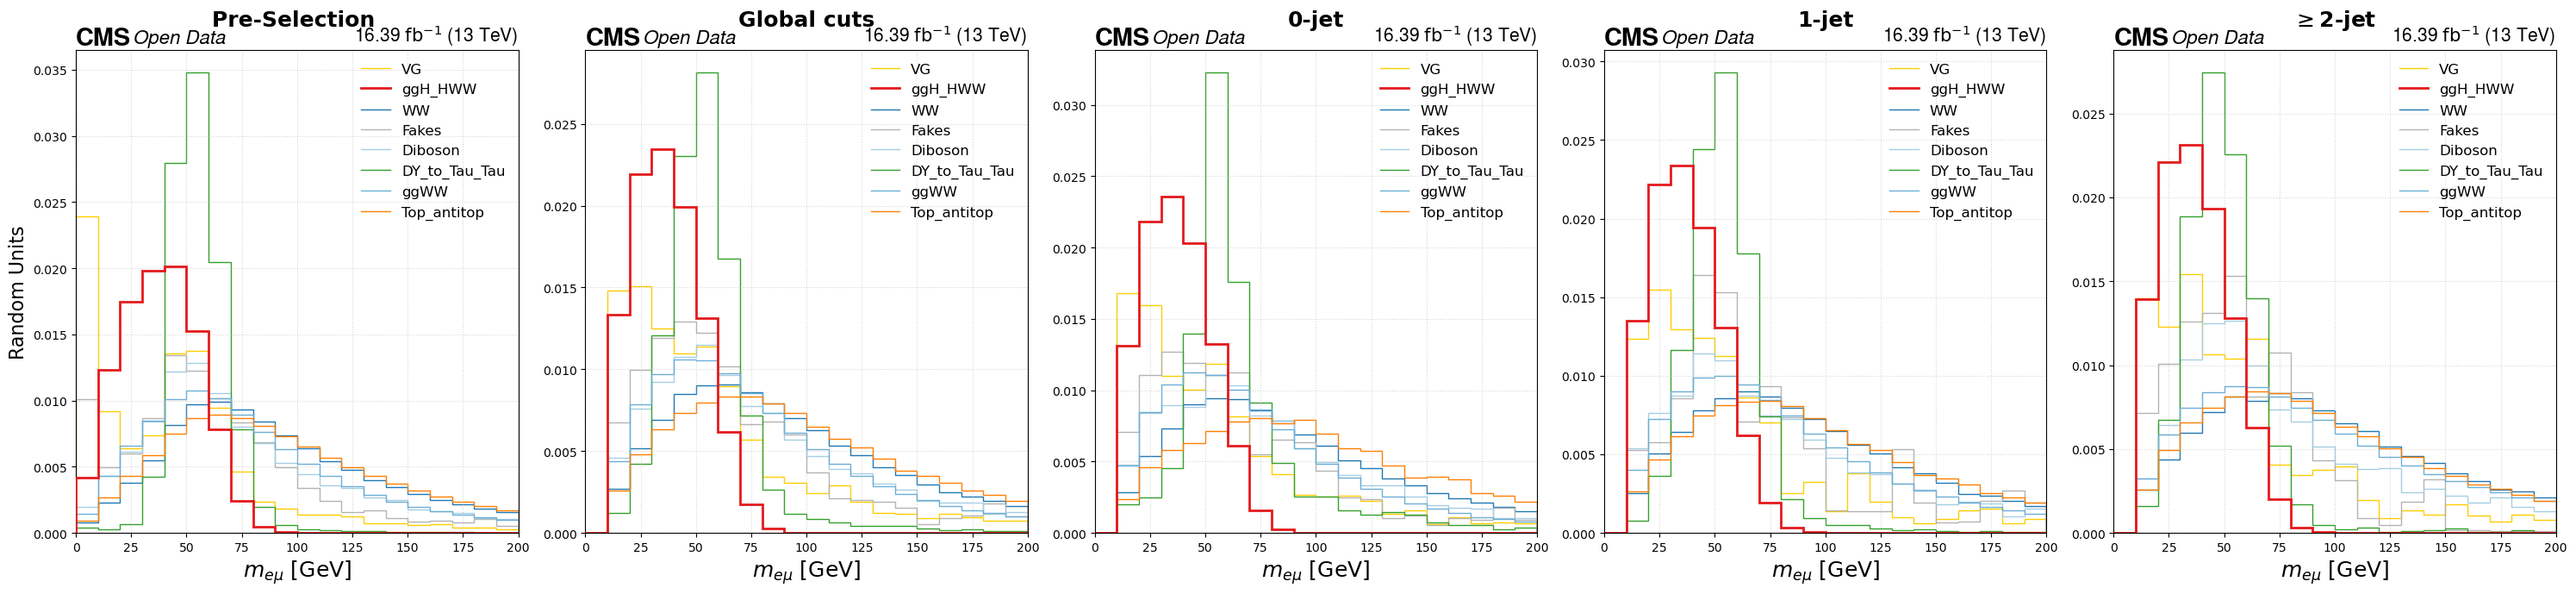

Processing met...
Saved plot: met_stages.png


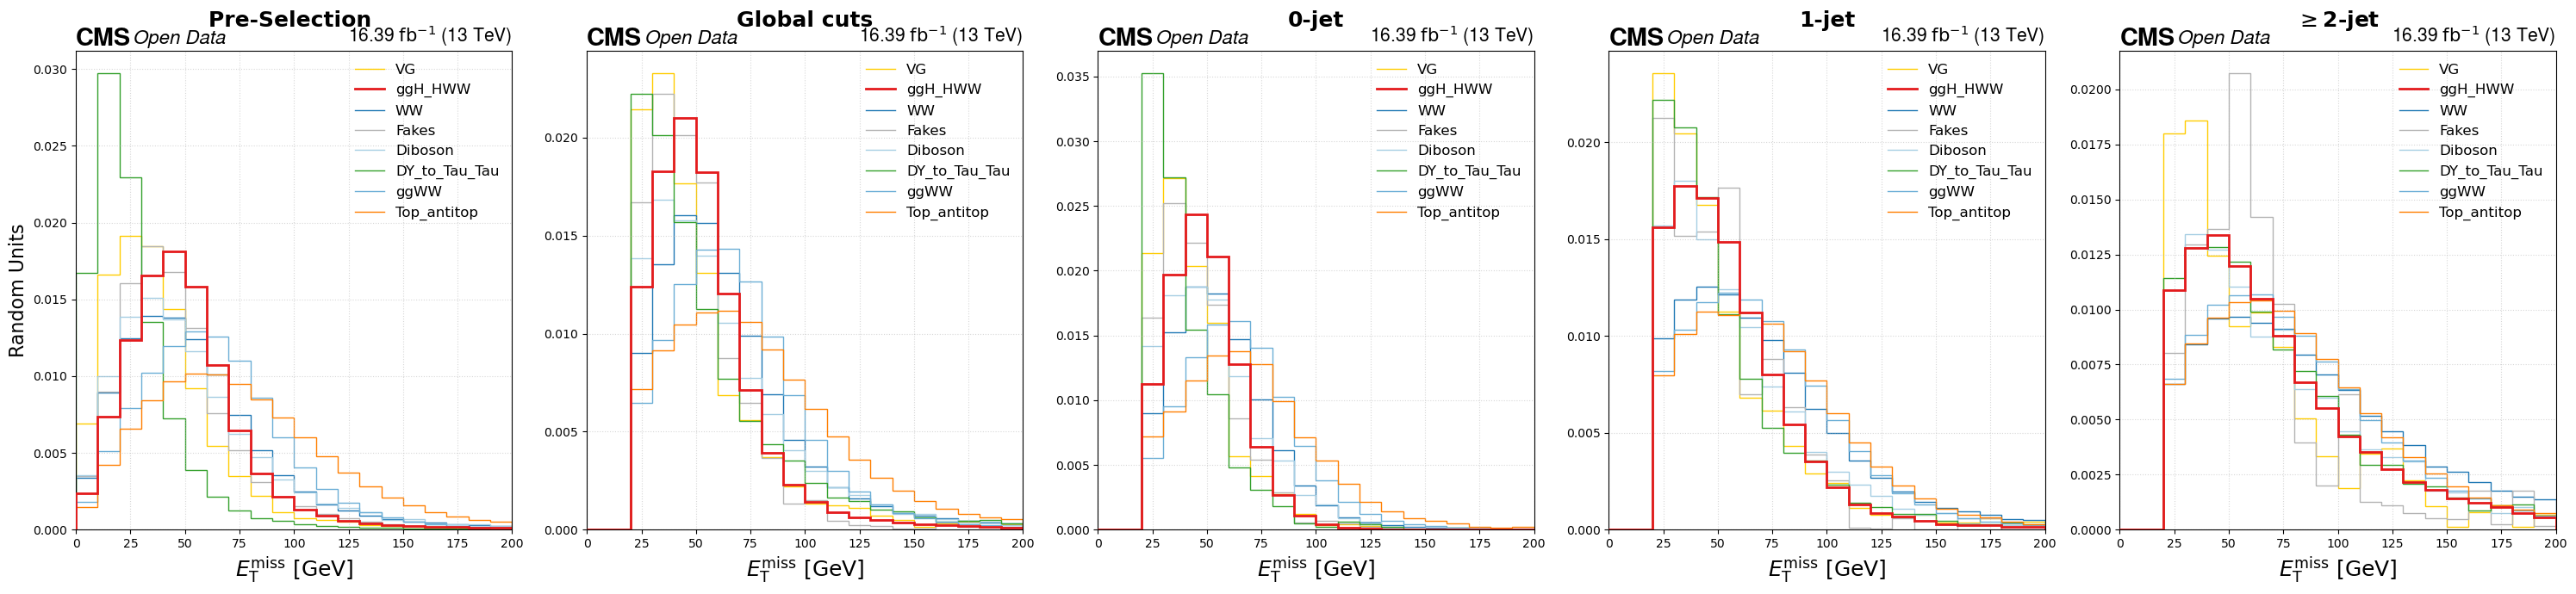

Processing dphi...
Saved plot: dphi_stages.png


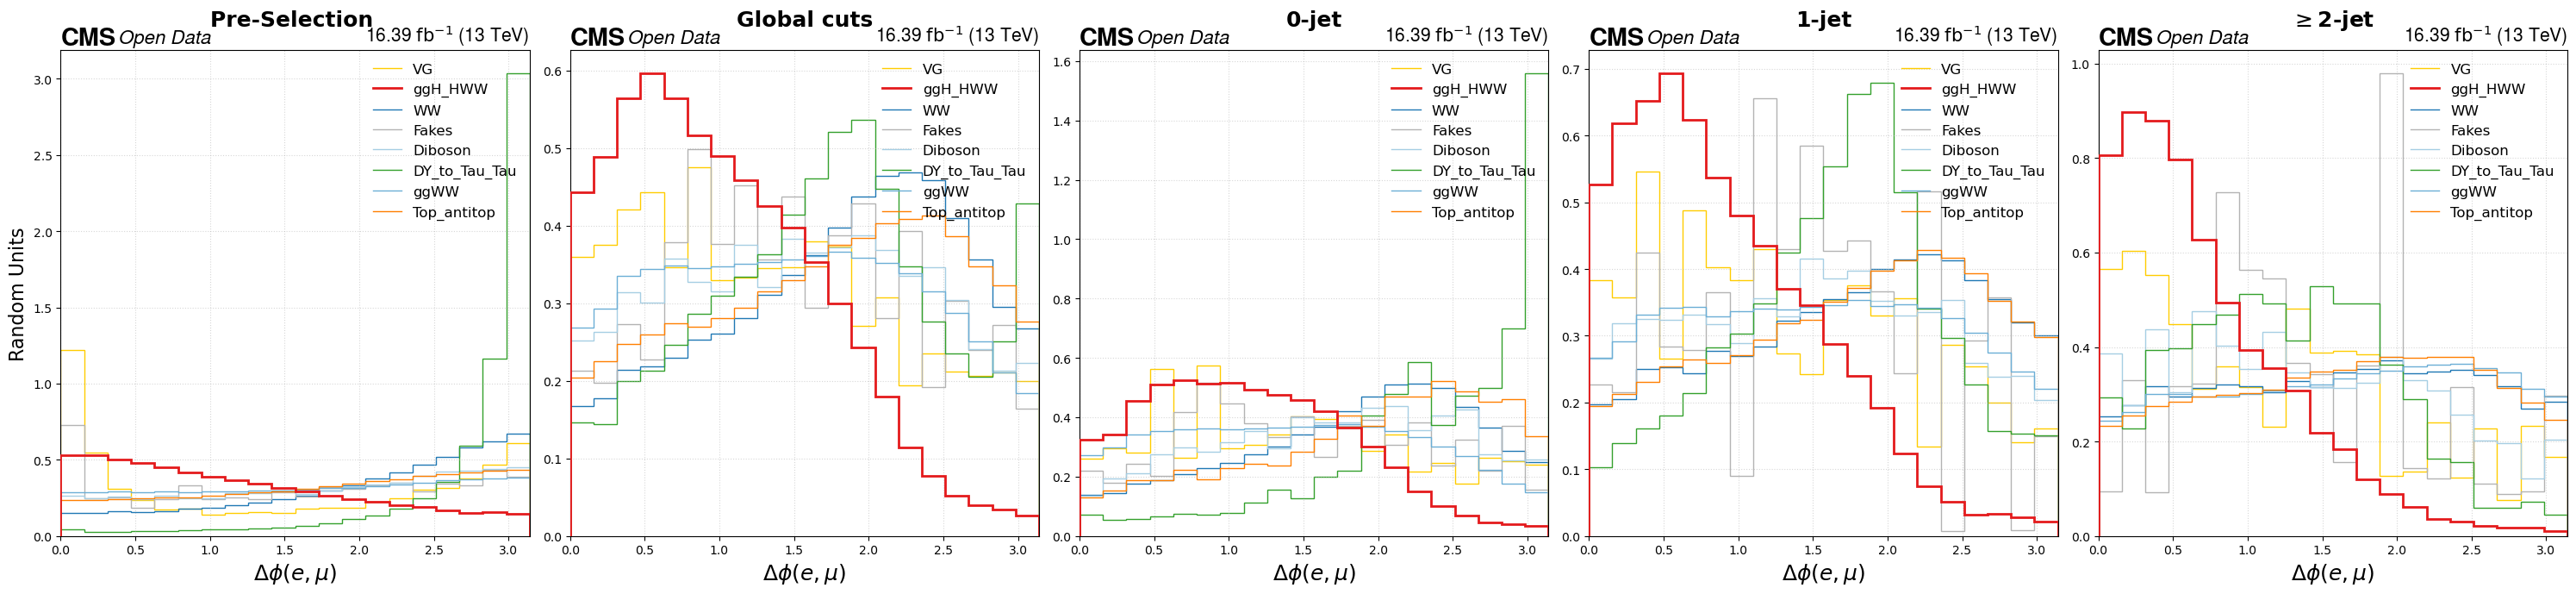

Processing ptll...
Saved plot: ptll_stages.png


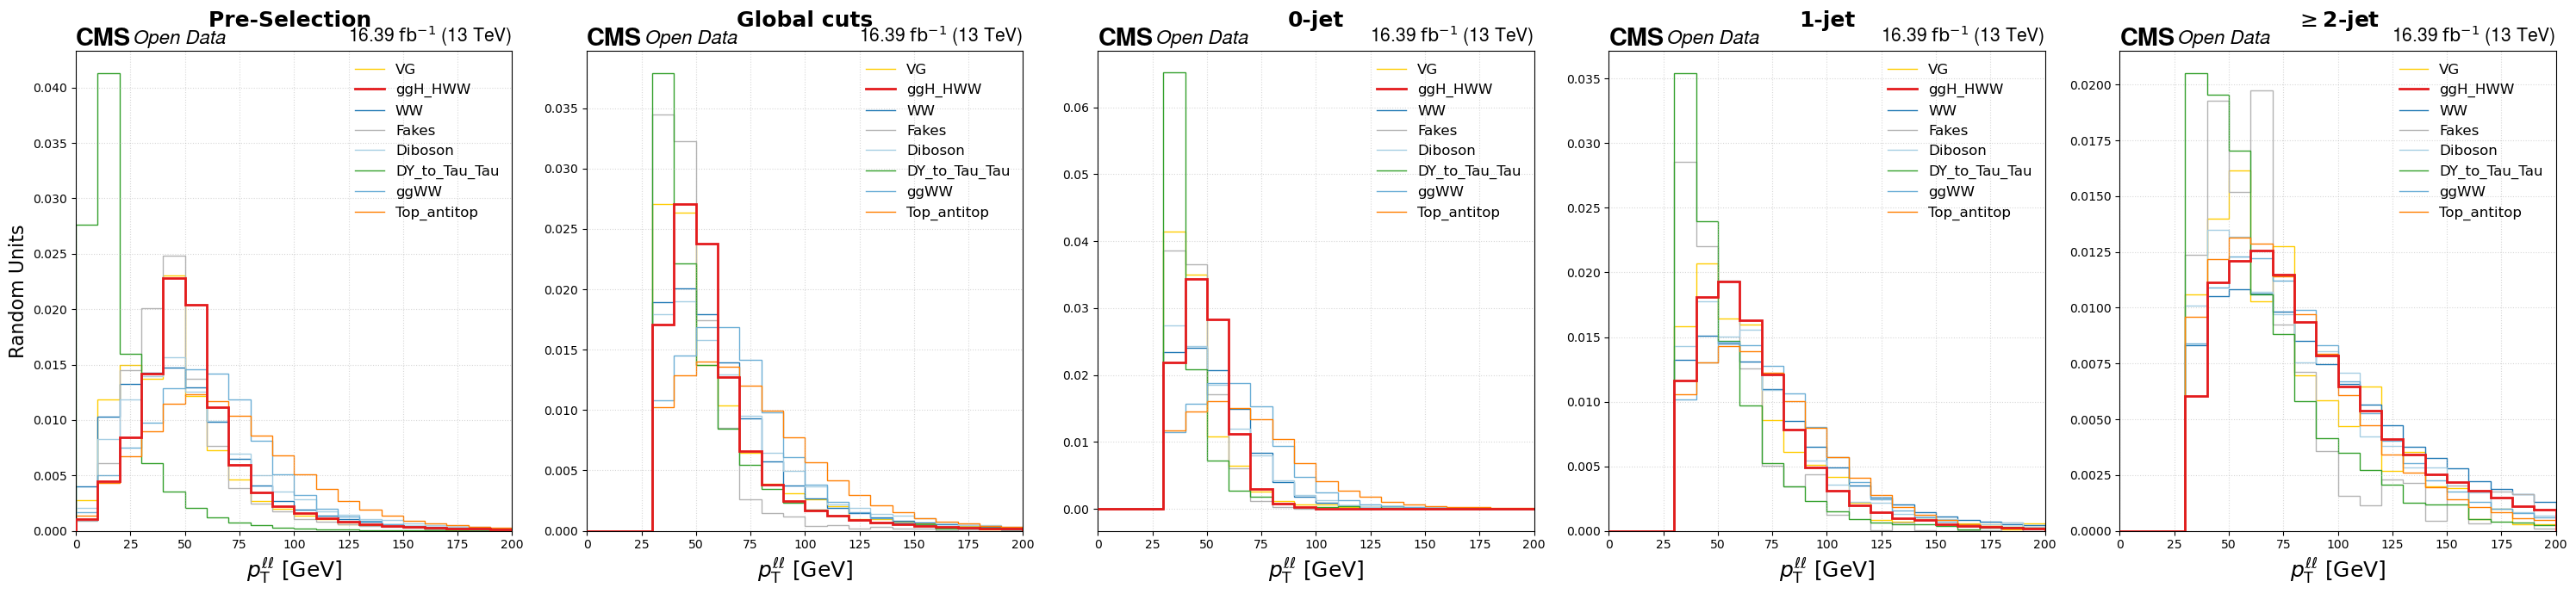

Processing mt_higgs...
Saved plot: mt_higgs_stages.png


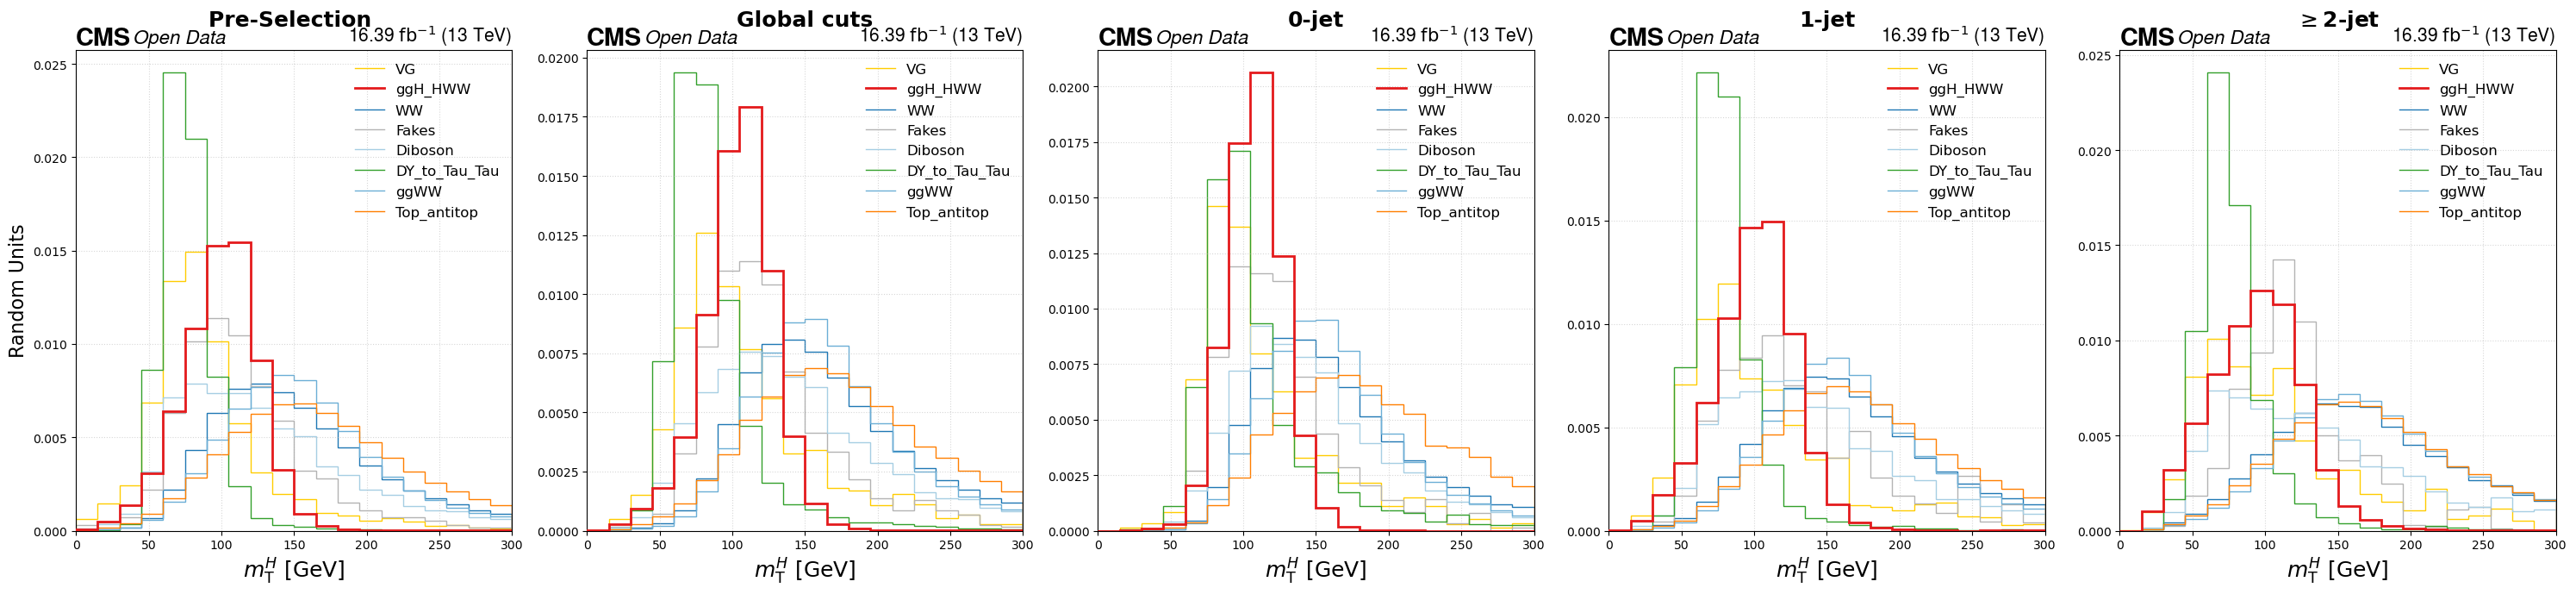

Processing mt_l2_met...
Saved plot: mt_l2_met_stages.png


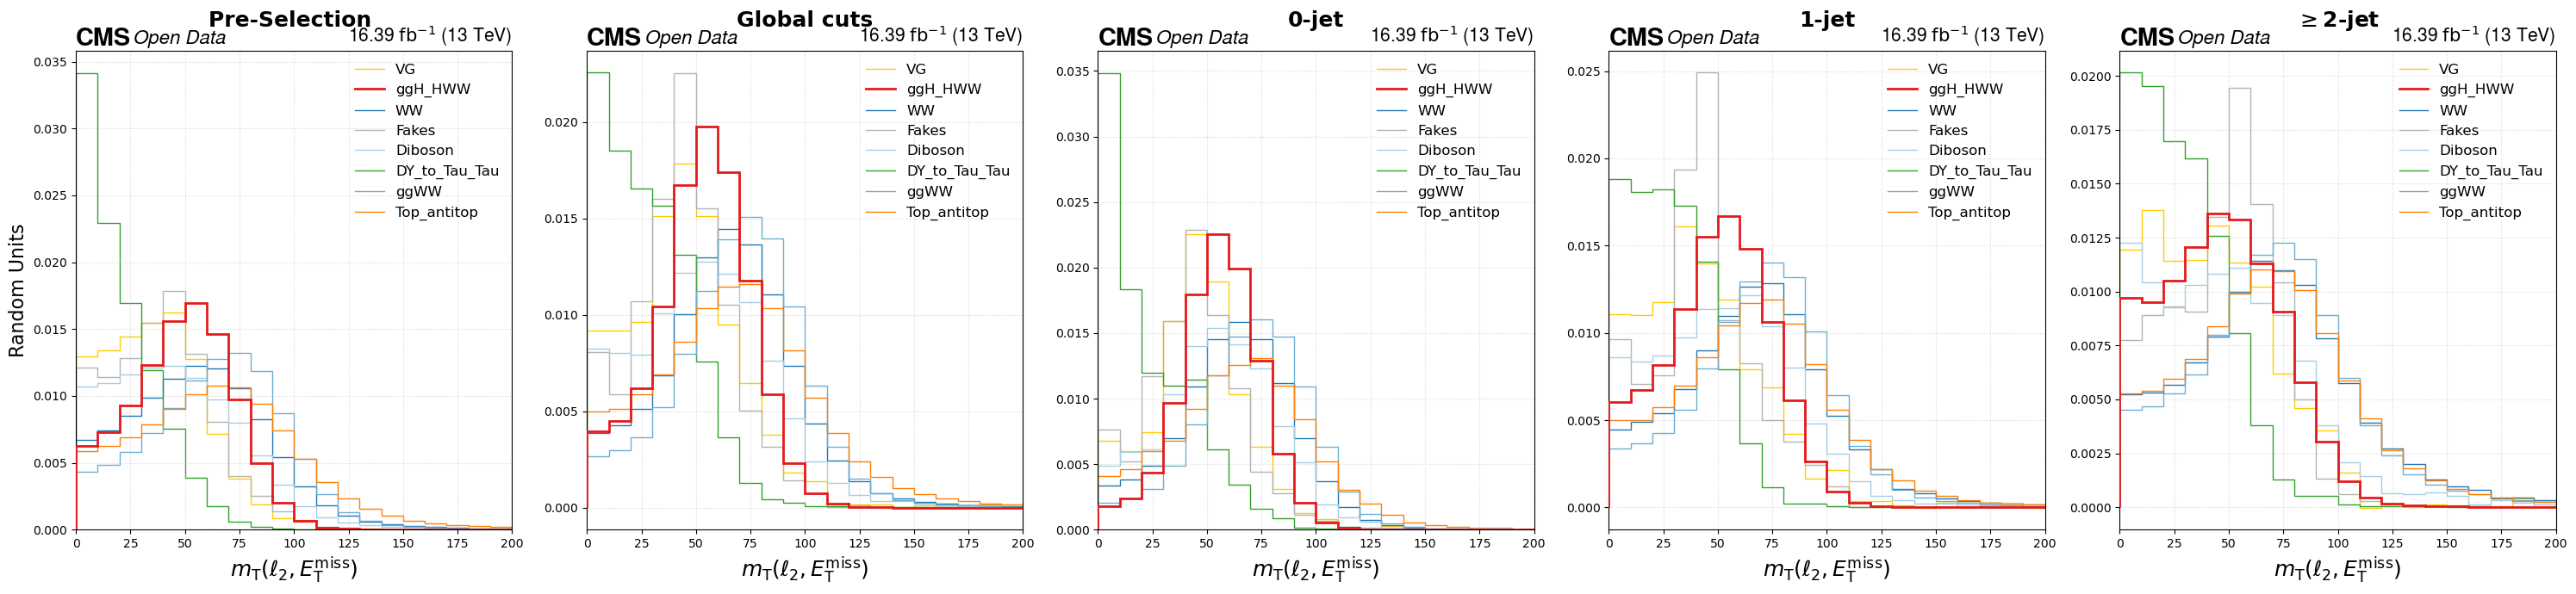

Processing mjj...
Saved plot: mjj_stages.png


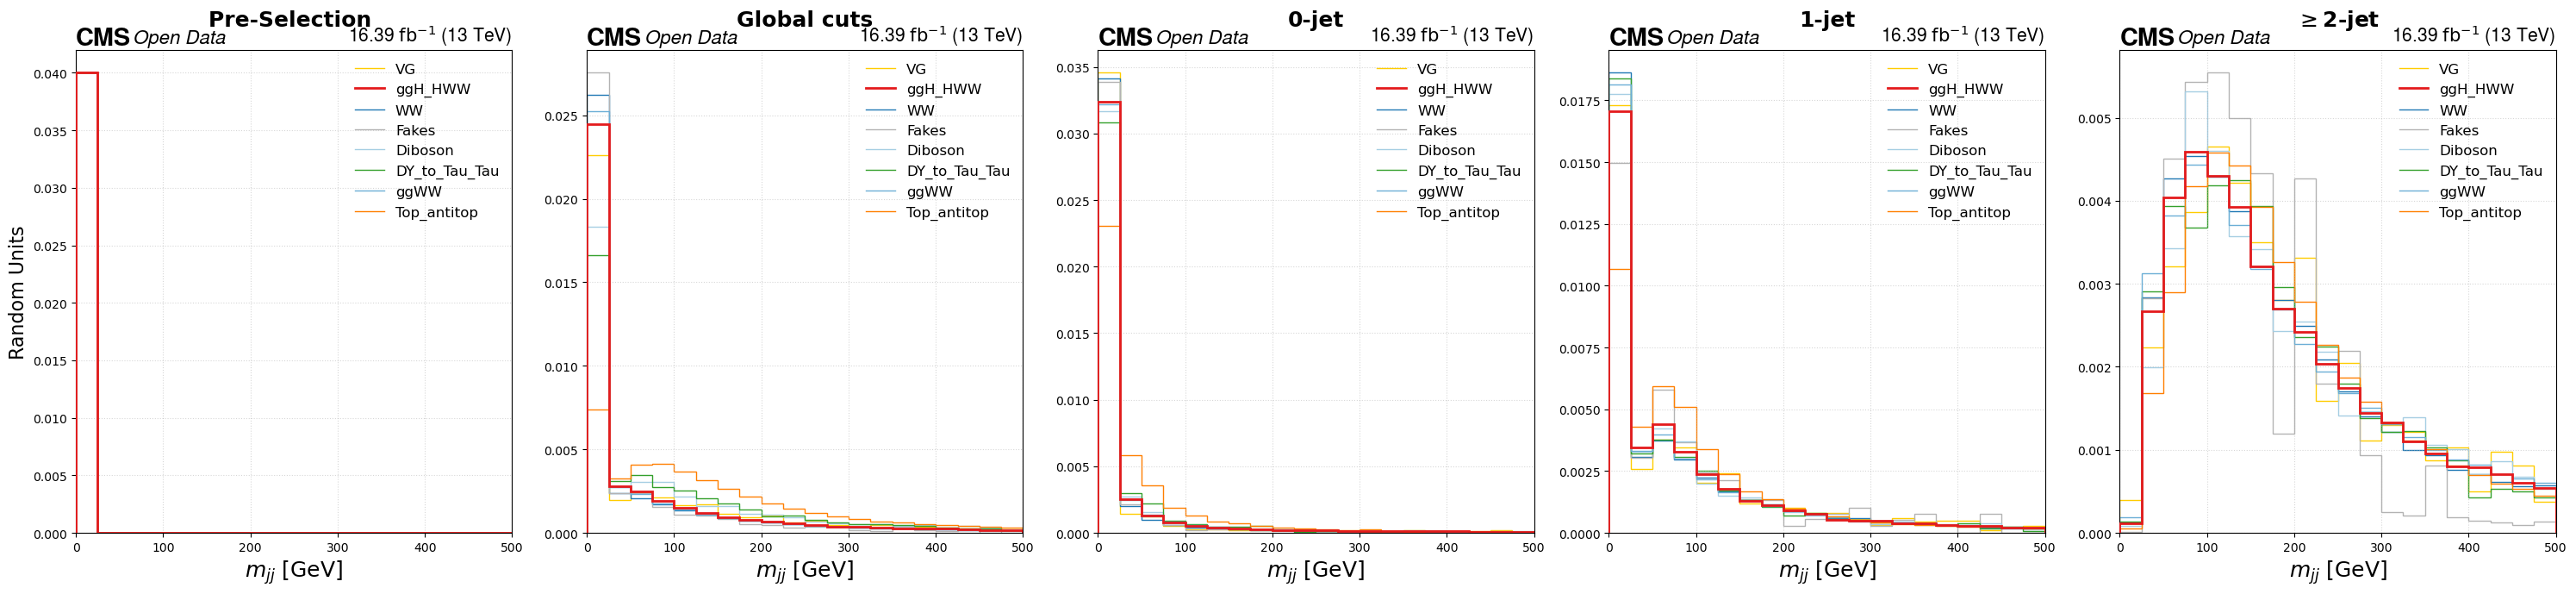

Processing leading_pt...
Saved plot: leading_pt_stages.png


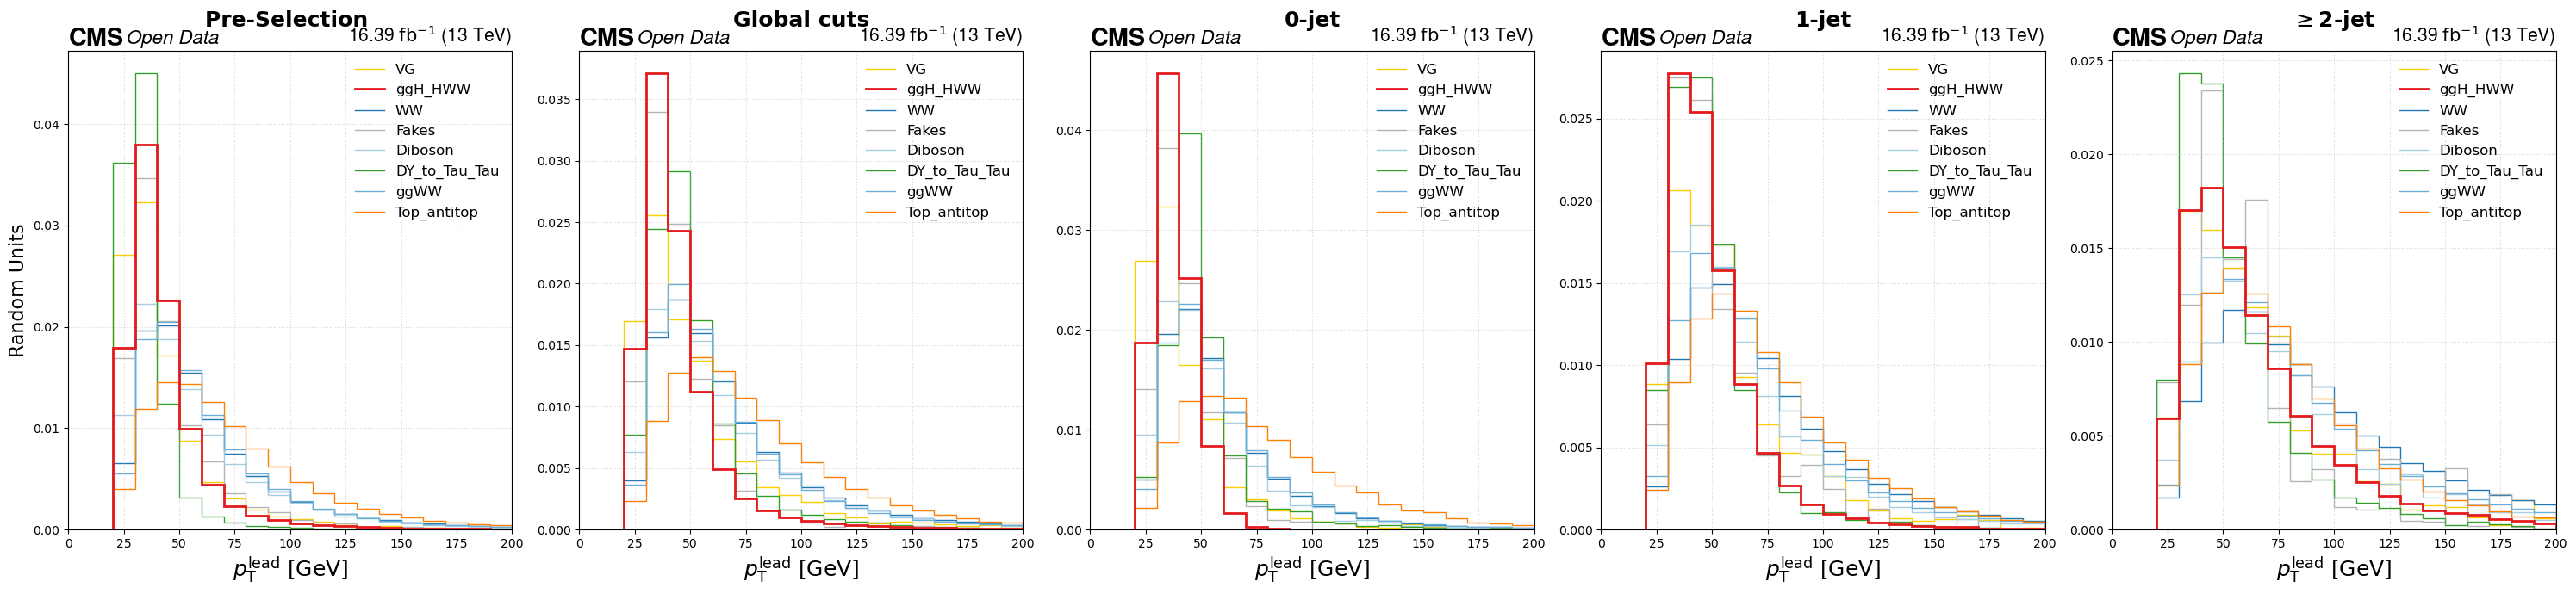

Processing subleading_pt...
Saved plot: subleading_pt_stages.png


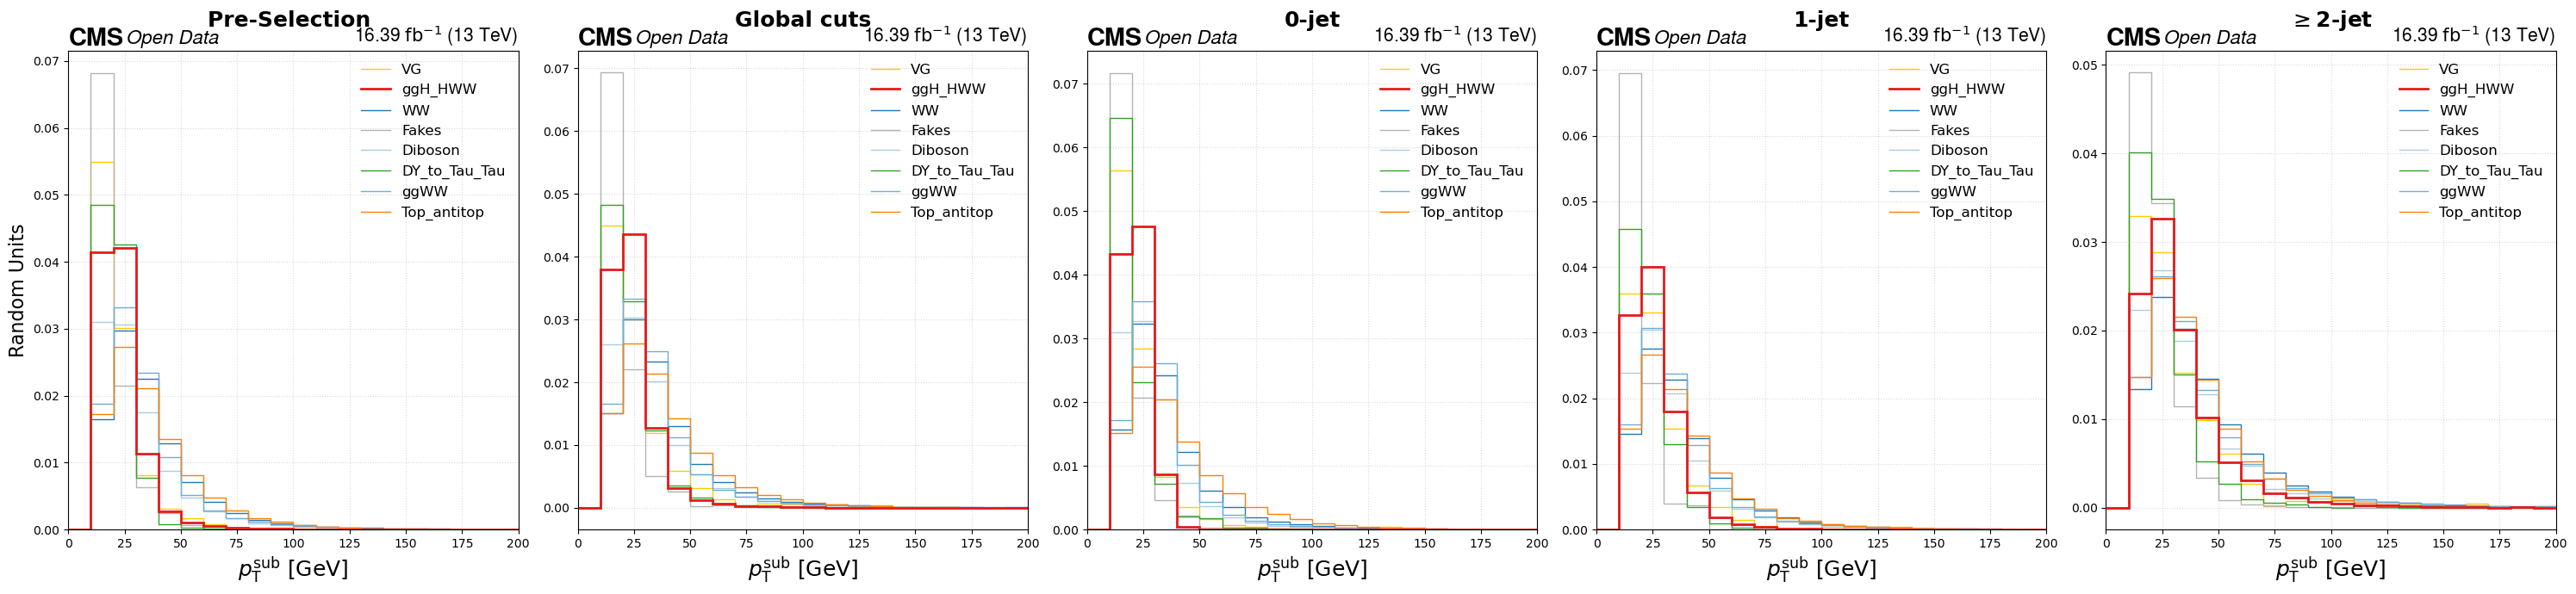

In [27]:
print(f"Saving plots to: {PLOTS_DIR / "Kinematics"}")
for var_name, var_props in variables_to_plots.items():
    print(f"Processing {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, hist_data_final, output_dir=PLOTS_DIR / "Kinematics")
    
    plt.show()
    plt.close(fig)

## Stacked plots

### Configuring the Stacked Plots

This `PLOT_SETTINGS` dictionary acts as our master blueprint. It organizes our output into the three distinct physics regions we defined earlier: the **Signal Region**, the **Top Control Region**, and the **DY-$\tau\tau$ Control Region**.

There are a few important experimental design choices embedded in this dictionary:

1. **Blinding the Signal**\
Notice the `plot_data` flag. It is set to `True` for our Control Regions, but strictly `False` for our Signal Region. 

2. **Dynamic Kinematic Axes**\
You will also notice custom `xlim` and `ylim` ranges for the same variable depending on the region. By defining these ranges here, our plotting function will dynamically zoom in on the relevant phase space for each specific control region, ensuring our distributions are perfectly framed.

In [29]:
PLOT_SETTINGS = {
    # GROUP 1: SIGNAL REGION 
    "Signal_Region": {
        "plot_data": False, 
        "stages": [('SR_0jet', 'SR 0j'), ('SR_1jet', 'SR 1j'), ('SR_2jet', 'SR 2j')],
        "variables": {
            "mass":          {"log": True,  "xlim": (12, 200),  "ylim": (0.01, 5000)},
            "ptll":          {"log": True,  "xlim": (30, 200),  "ylim": (0.01, 5000)},
            "met":           {"log": True,  "xlim": (20, 200),  "ylim": (0.01, 5000)},
            "mt_higgs":      {"log": True,  "xlim": (60, 300),  "ylim": None},
            "mt_l2_met":     {"log": True,  "xlim": (30, 140),  "ylim": None},
            "mjj":           {"log": True,  "xlim": (0, 500),   "ylim": None}, 
            "dphi":          {"log": True,  "xlim": (0, 3.14),  "ylim": (0.01, 1000)},
            "leading_pt":    {"log": True,  "xlim": (25, 200),  "ylim": None},
            "subleading_pt": {"log": True,  "xlim": (10, 200),  "ylim": None},
        }
    },

    # GROUP 2: TOP CONTROL REGION 
    "Control_Region_Top": {
        "plot_data": True,
        "stages": [('CR_top_0jet', 'Top 0j'), ('CR_top_1jet', 'Top 1j'), ('CR_top_2jet', 'Top 2j')],
        "variables": {
            "mass":          {"log": True, "xlim": (50, 200),  "ylim": (1, 5000)},
            "ptll":          {"log": True, "xlim": (30, 200),  "ylim": (1, 2000)},
            "met":           {"log": True, "xlim": (20, 200),  "ylim": None},
            "mt_higgs":      {"log": True, "xlim": (60, 300),  "ylim": (1, 5000)},
            "mt_l2_met":     {"log": True, "xlim": (30, 150),  "ylim": None},
            "mjj":           {"log": True, "xlim": (0, 500),   "ylim": None},
            "dphi":          {"log": True, "xlim": (0, 3.14),  "ylim": (1, 1000)},
            "leading_pt":    {"log": True, "xlim": (25, 200),  "ylim": None},
            "subleading_pt": {"log": True, "xlim": (10, 200),  "ylim": None},
        }
    },

    # # GROUP 3: TAU CONTROL REGION 
    # "Control_Region_Tau": {
    #     "plot_data": True,
    #     "stages": [('CR_tau_0jet', r'DY-$\tau\tau$ 0j'), ('CR_tau_1jet', r'DY-$\tau\tau$ 1j'), ('CR_tau_2jet', r'DY-$\tau\tau$ 2j')],
    #     "variables": {
    #         "mass":          {"log": True, "xlim": (40, 60),   "ylim": (0.01, 1000)},
    #         "ptll":          {"log": True, "xlim": (30, 100),  "ylim": (0.01, 1000)},
    #         "met":           {"log": True, "xlim": (20, 100),   "ylim": (0.01, 1000)},
    #         "mt_higgs":      {"log": True, "xlim": (0, 60),    "ylim": (0.01, 1000)},
    #         "mt_l2_met":     {"log": True, "xlim": (30, 50),   "ylim": (0.01, 1000)},
    #         "mjj":           {"log": True, "xlim": (0, 500),   "ylim": None},
    #         "dphi":          {"log": True, "xlim": (1.5, 3.14),  "ylim": (0.01, 1000)},
    #         "leading_pt":    {"log": True, "xlim": (30, 80),  "ylim": (0.01, 1000)},
    #         "subleading_pt": {"log": True, "xlim": (10, 30),   "ylim": None},
    #     }
    # }
}


## Safely Extracting Histogram Data

To access histograms from our nested dictionary, we use the `get_histogram_data` function. It navigates the hierarchy  
`Sample → Stage → Variable → Variation`  
and safely returns `None` if a requested combination does not exist, preventing `KeyError` exceptions during plotting (e.g., when data is unavailable in a blinded region).

The function also extracts the essential components needed for visualization:

- **Bin values**
- **Bin edges**
- **Statistical variances**

Since the histograms were initialized with weight storage, calling `.variances()` directly returns the sum of squared weights. This allows us to compute statistically correct uncertainty bands for the final plots.

In [30]:
def get_histogram_data(hist_data, sample, stage, variable, variation='nominal'):
    if sample not in hist_data: return None, None, None
    if stage not in hist_data[sample]: return None, None, None
    if variable not in hist_data[sample][stage]: return None, None, None
    
    vars_dict = hist_data[sample][stage][variable]
    if variation not in vars_dict: return None, None, None
        
    h = vars_dict[variation]
    
    try:
        return h.values(), h.variances(), h.axes[0].edges
    except:
        return None, None, None

In [31]:
def stacked_plots(variable, hist_data_all, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    xlabel = VAR_LABELS.get(variable, variable)
    
    backgrounds = [s for s in SAMPLES if not SAMPLES[s]['is_signal'] and s != 'Data']
    backgrounds.sort(key=lambda s: SAMPLES[s].get("stack_order", 0))
    signal = next((s for s in SAMPLES if SAMPLES[s]['is_signal']), None)
    data_sample = 'Data'

    syst_sources = ['trigger', 'ele_id', 'mu_id'] 

    for region_name, config in PLOT_SETTINGS.items():
        var_config = config['variables'].get(variable)
        if not var_config: continue

        print(f"Plotting {variable} in {region_name}...")
        
        stages = config['stages']
        use_log = var_config.get('log', False)
        set_xlim = var_config.get('xlim', None)
        set_ylim = var_config.get('ylim', None)
        
        is_signal_region = "Signal" in region_name
        plot_data = False if is_signal_region else config.get('plot_data', True)

        # CANVAS SETUP
        if plot_data:
            fig, axes = plt.subplots(2, 3, figsize=(30, 12), 
                                     gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.08, 'wspace': 0.25},
                                     sharex='col')
            row_axes = axes[0]
            ratio_axes = axes[1]
        else:
            fig, axes = plt.subplots(1, 3, figsize=(30, 9), 
                                     gridspec_kw={'wspace': 0.25},
                                     sharex='col')
            row_axes = axes
            ratio_axes = [None] * 3

        for col_idx, (stage_key, stage_label) in enumerate(stages):
            ax_main = row_axes[col_idx]
            ax_ratio = ratio_axes[col_idx]
            
            # GET NOMINAL DATA 
            stack_vals = []
            stack_colors = []
            stack_labels = []
            stack_variances = [] 
            edges = None
            
            total_nominal = None
            syst_stacks = {source: {'up': None, 'down': None} for source in syst_sources}

            for s in backgrounds:
                vals, vars_sq, e = get_histogram_data(hist_data_all, s, stage_key, variable, 'nominal')
                
                if vals is not None:
                    if edges is None: 
                        edges = e
                        nbins = len(vals)
                        total_nominal = np.zeros(nbins)
                        for src in syst_sources:
                            syst_stacks[src]['up'] = np.zeros(nbins)
                            syst_stacks[src]['down'] = np.zeros(nbins)

                    stack_vals.append(vals)
                    stack_variances.append(vars_sq) # Add stat variance
                    stack_colors.append(SAMPLES[s].get("color", "gray"))
                    stack_labels.append(s)
                    
                    # Add to totals
                    total_nominal += vals
                    
                    # Accumulate Systematics for this background
                    for src in syst_sources:
                        v_up, _, _ = get_histogram_data(hist_data_all, s, stage_key, variable, f'{src}_up')
                        v_dn, _, _ = get_histogram_data(hist_data_all, s, stage_key, variable, f'{src}_down')
                        
                        if v_up is None: v_up = vals
                        if v_dn is None: v_dn = vals
                            
                        syst_stacks[src]['up'] += v_up
                        syst_stacks[src]['down'] += v_dn

            if edges is None:
                ax_main.text(0.5, 0.5, "No Data", ha='center', transform=ax_main.transAxes)
                continue
                
            # Stats Uncertainty
            total_stat_variance = np.sum(stack_variances, axis=0)
            
            # Systematic Uncertainty
            total_syst_variance = np.zeros_like(total_nominal)
            
            for src in syst_sources:
                diff_up = np.abs(syst_stacks[src]['up'] - total_nominal)
                diff_dn = np.abs(syst_stacks[src]['down'] - total_nominal)
                
                max_diff = np.maximum(diff_up, diff_dn)
                total_syst_variance += max_diff**2
                
            # Total Error (Stat + Syst)
            total_err = np.sqrt(total_stat_variance + total_syst_variance)

            # PLOTTING      
            
            # A. Stack
            if stack_vals:
                hep.histplot(stack_vals, bins=edges, stack=True, histtype='fill',
                             color=stack_colors, label=stack_labels, ax=ax_main)
                
                # Outline
                hep.histplot(total_nominal, bins=edges, histtype='step', color='black', linewidth=1, ax=ax_main)
                
                # DRAW UNCERTAINTY BAND
                band_low = np.append(total_nominal - total_err, (total_nominal - total_err)[-1])
                band_high = np.append(total_nominal + total_err, (total_nominal + total_err)[-1])
                
                ax_main.fill_between(edges, band_low, band_high, step='post', 
                                     facecolor='none', edgecolor='gray', 
                                     label='Stat+Syst Unc.', hatch='////', zorder=2)

            # B. Signal
            if signal:
                sig_vals, _, _ = get_histogram_data(hist_data_all, signal, stage_key, variable, 'nominal')
                if sig_vals is not None:
                    sig_scale = 10 if is_signal_region else 1
                    sig_lbl = f"{signal} (x{sig_scale})" if sig_scale > 1 else signal
                    hep.histplot(sig_vals * sig_scale, bins=edges, histtype='step',
                                 color=SAMPLES[signal].get("color", "red"), 
                                 linewidth=3, label=sig_lbl, ax=ax_main)

            # C. Data
            data_vals = None
            if plot_data:
                data_vals, _, _ = get_histogram_data(hist_data_all, data_sample, stage_key, variable, 'nominal')
                if data_vals is not None:
                    yerr = np.sqrt(data_vals); yerr[data_vals == 0] = 0
                    hep.histplot(data_vals, bins=edges, histtype='errorbar', color='black', 
                                 label='Data', yerr=yerr, marker='o', markersize=5, ax=ax_main, zorder=10)

            # D. Ratio Plot
            if plot_data and data_vals is not None and total_nominal is not None:
                safe_denom = np.where(total_nominal == 0, 1e-9, total_nominal)
                ratio = data_vals / safe_denom
                ratio_stat_err = np.abs(np.sqrt(data_vals) / safe_denom) 
                
                # Points
                hep.histplot(ratio, bins=edges, histtype='errorbar', yerr=ratio_stat_err,
                             color='black', marker='o', markersize=4, ax=ax_ratio)
                
                rel_err = total_err / safe_denom
                rel_err[total_nominal == 0] = 0 
                
                ratio_band_low = np.append(1.0 - rel_err, (1.0 - rel_err)[-1])
                ratio_band_high = np.append(1.0 + rel_err, (1.0 + rel_err)[-1])
                
                ax_ratio.fill_between(edges, ratio_band_low, ratio_band_high, step='post',
                                      facecolor='gray', alpha=0.3, zorder=1) # Solid gray or hatched
                
                ax_ratio.axhline(1, color='gray', linestyle='--')
                ax_ratio.set_ylim(0.5, 1.5)
                ax_ratio.set_ylabel("Data / Pred.", fontsize=16)
                ax_ratio.set_xlabel(xlabel, fontsize=20)
                ax_ratio.grid(True, linestyle=':', alpha=0.5)

            #       STYLING      
            hep.cms.label(ax=ax_main, loc=0, data=True, label="Open Data", lumi=16.1, fontsize=20)
            ax_main.text(0.05, 0.92, stage_label, transform=ax_main.transAxes, fontsize=22, fontweight='bold', va='top')
            ax_main.set_ylabel("Events / Bin", fontsize=20)
            
            if use_log:
                ax_main.set_yscale('log')
                max_val = np.max(total_nominal) if total_nominal is not None else 1
                ax_main.set_ylim(0.1, max_val * 500)
            else:
                max_val = np.max(total_nominal) if total_nominal is not None else 1
                ax_main.set_ylim(0, max_val * 1.5)

            if set_xlim: ax_main.set_xlim(set_xlim)
            if set_ylim and not use_log: ax_main.set_ylim(set_ylim)
            if not plot_data: ax_main.set_xlabel(xlabel, fontsize=20)

            # Legend
            handles, labels = ax_main.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax_main.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=1, frameon=False, fontsize=16)

        # SAVE
        fname = f"{output_dir}/CMS_{region_name}_{variable}.png"
        plt.savefig(fname, bbox_inches='tight', dpi=150)
        print(f"Saved: {fname}")
        plt.show()
        plt.close(fig)


GENERATING STACKED PLOTS ...
Plotting mass in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_mass.png


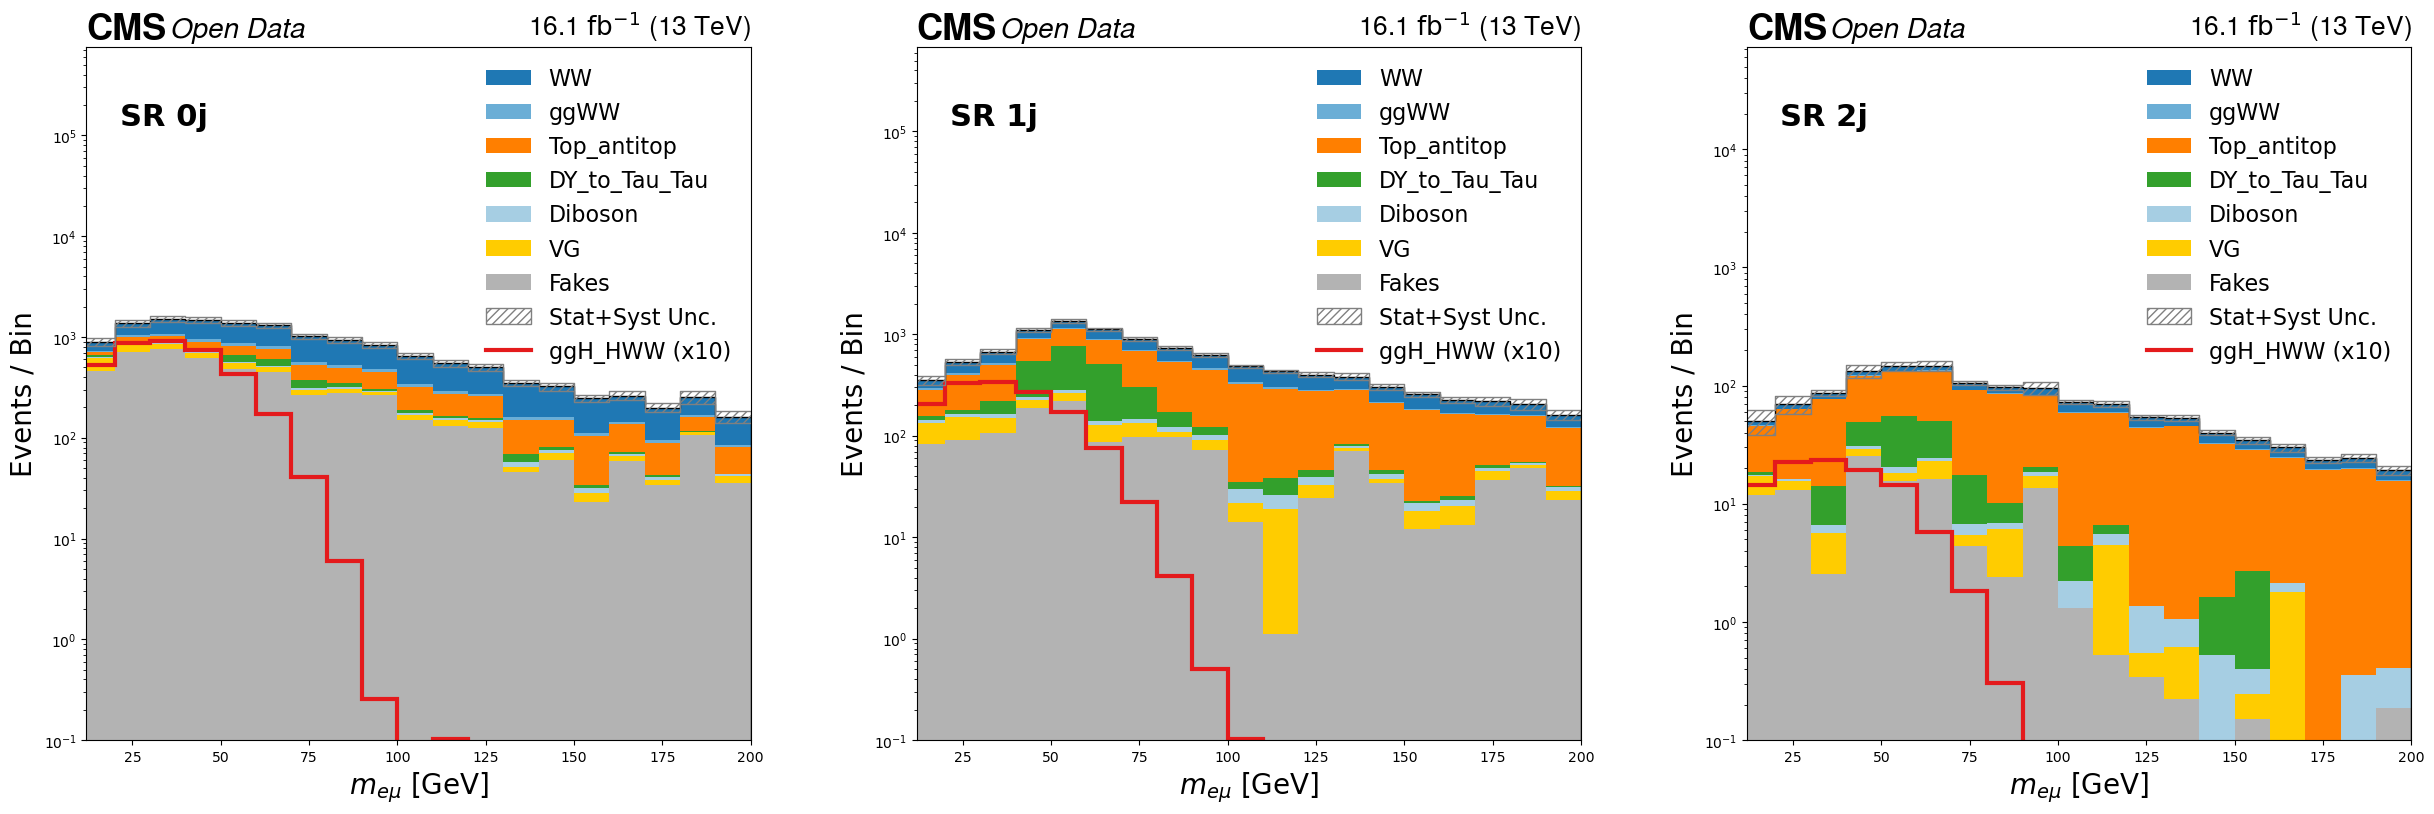

Plotting mass in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_mass.png


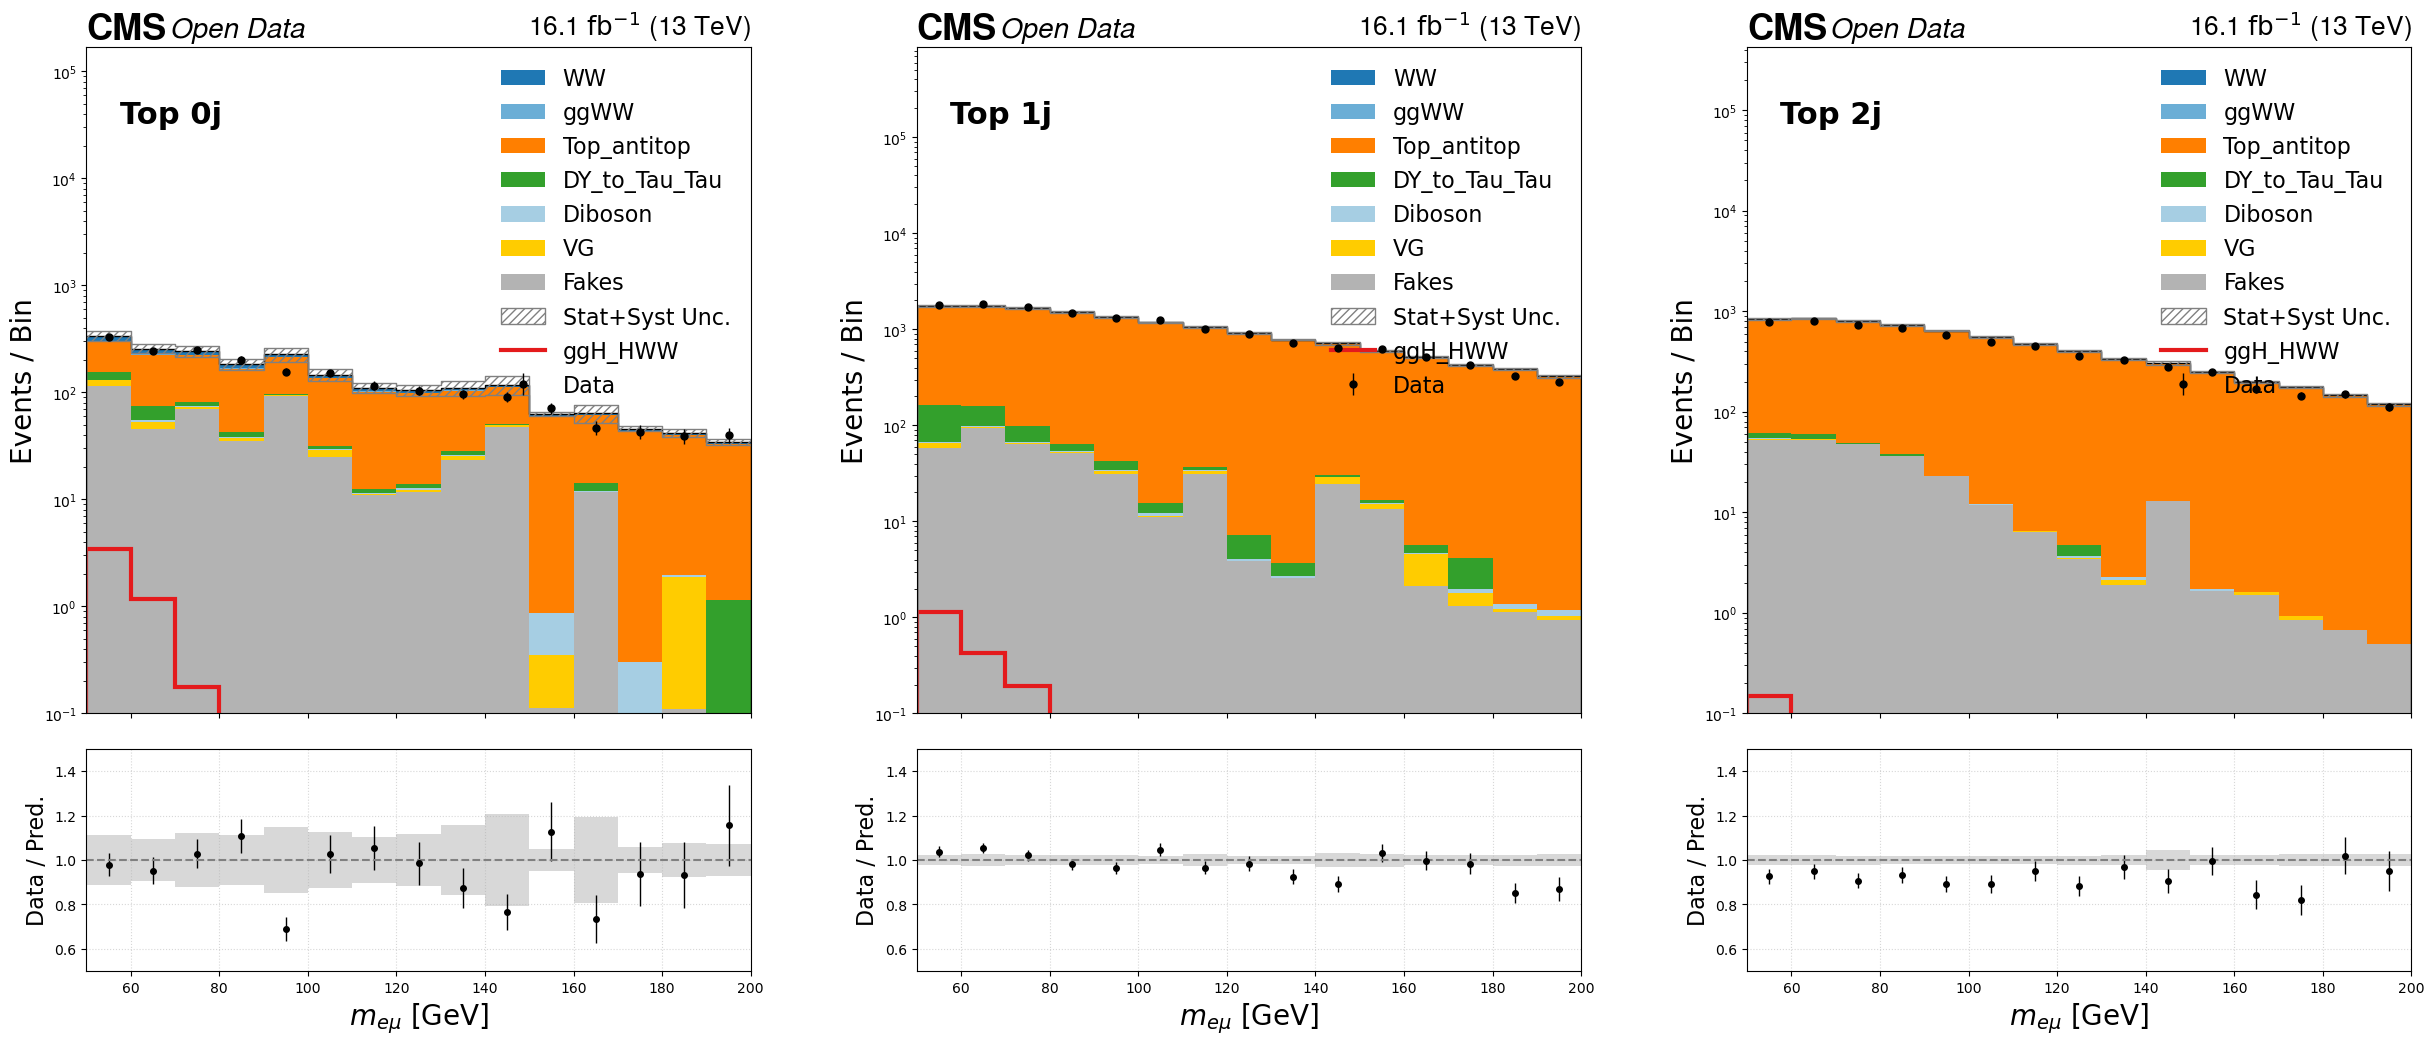

Plotting met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_met.png


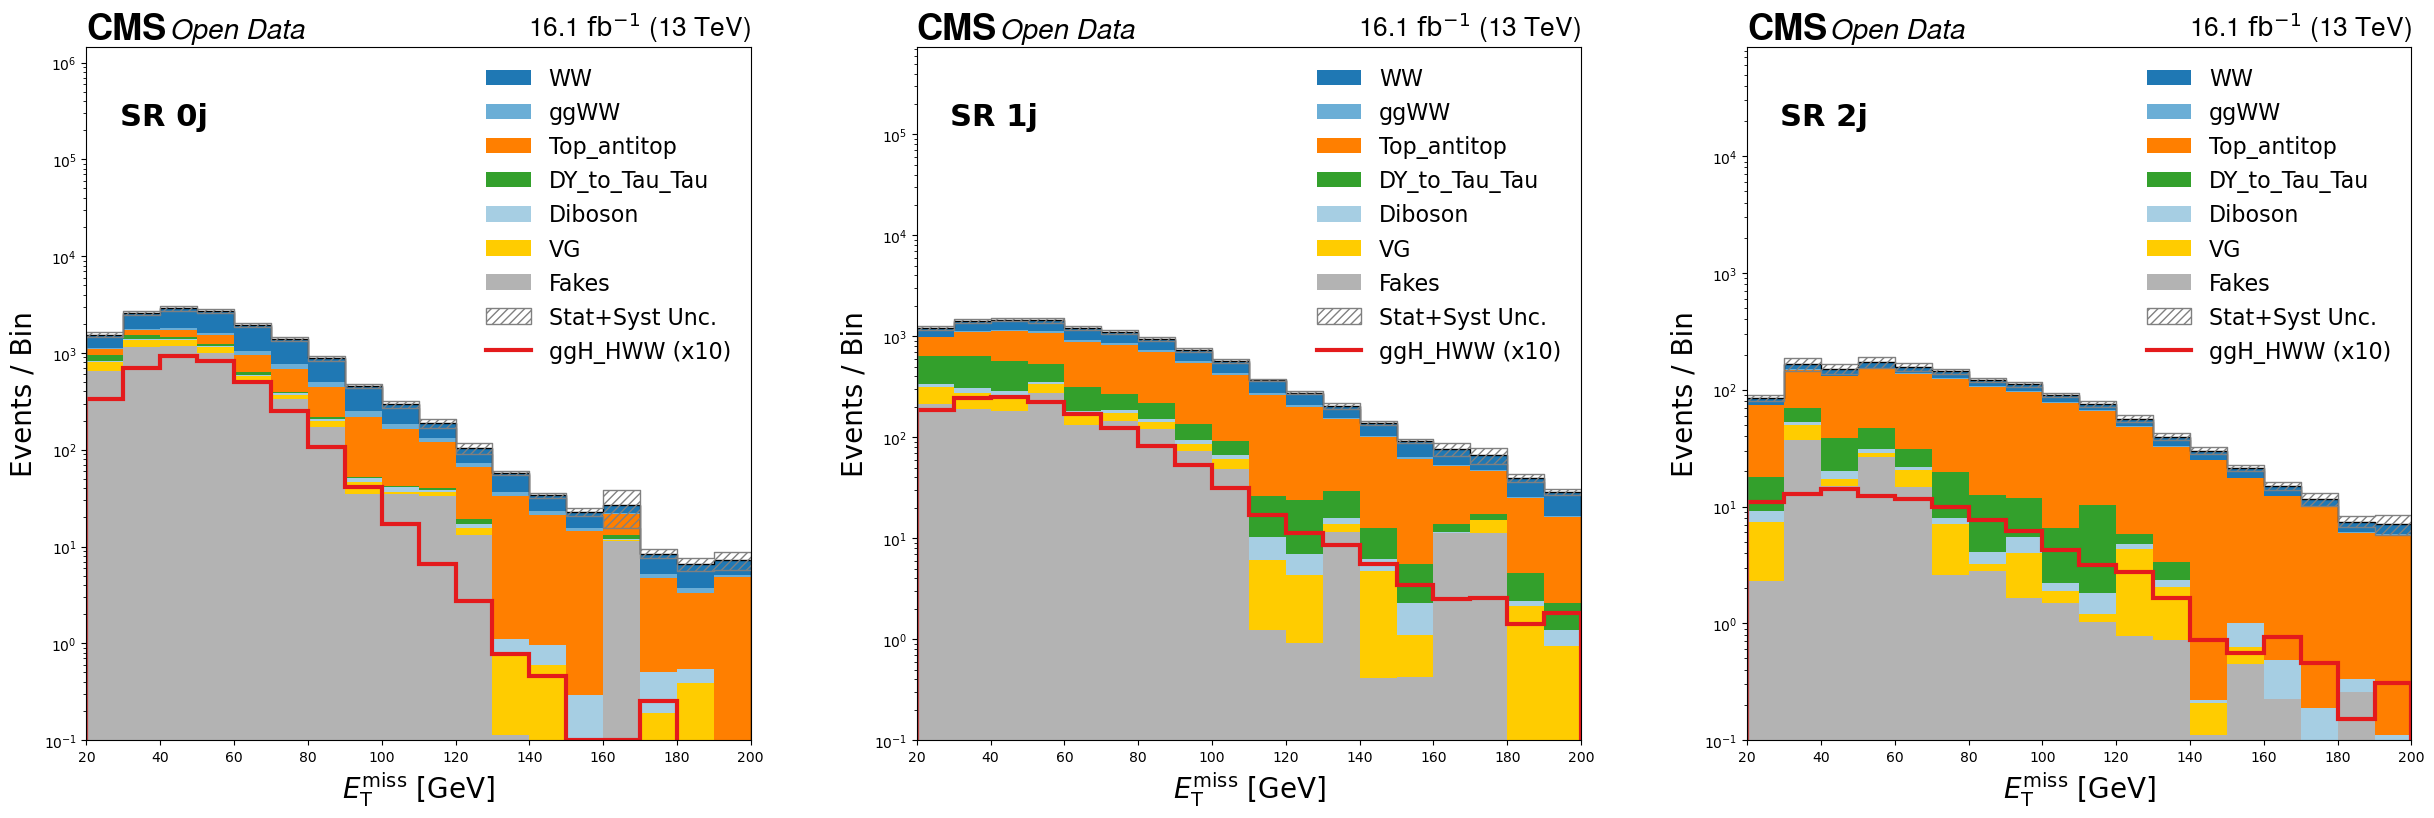

Plotting met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_met.png


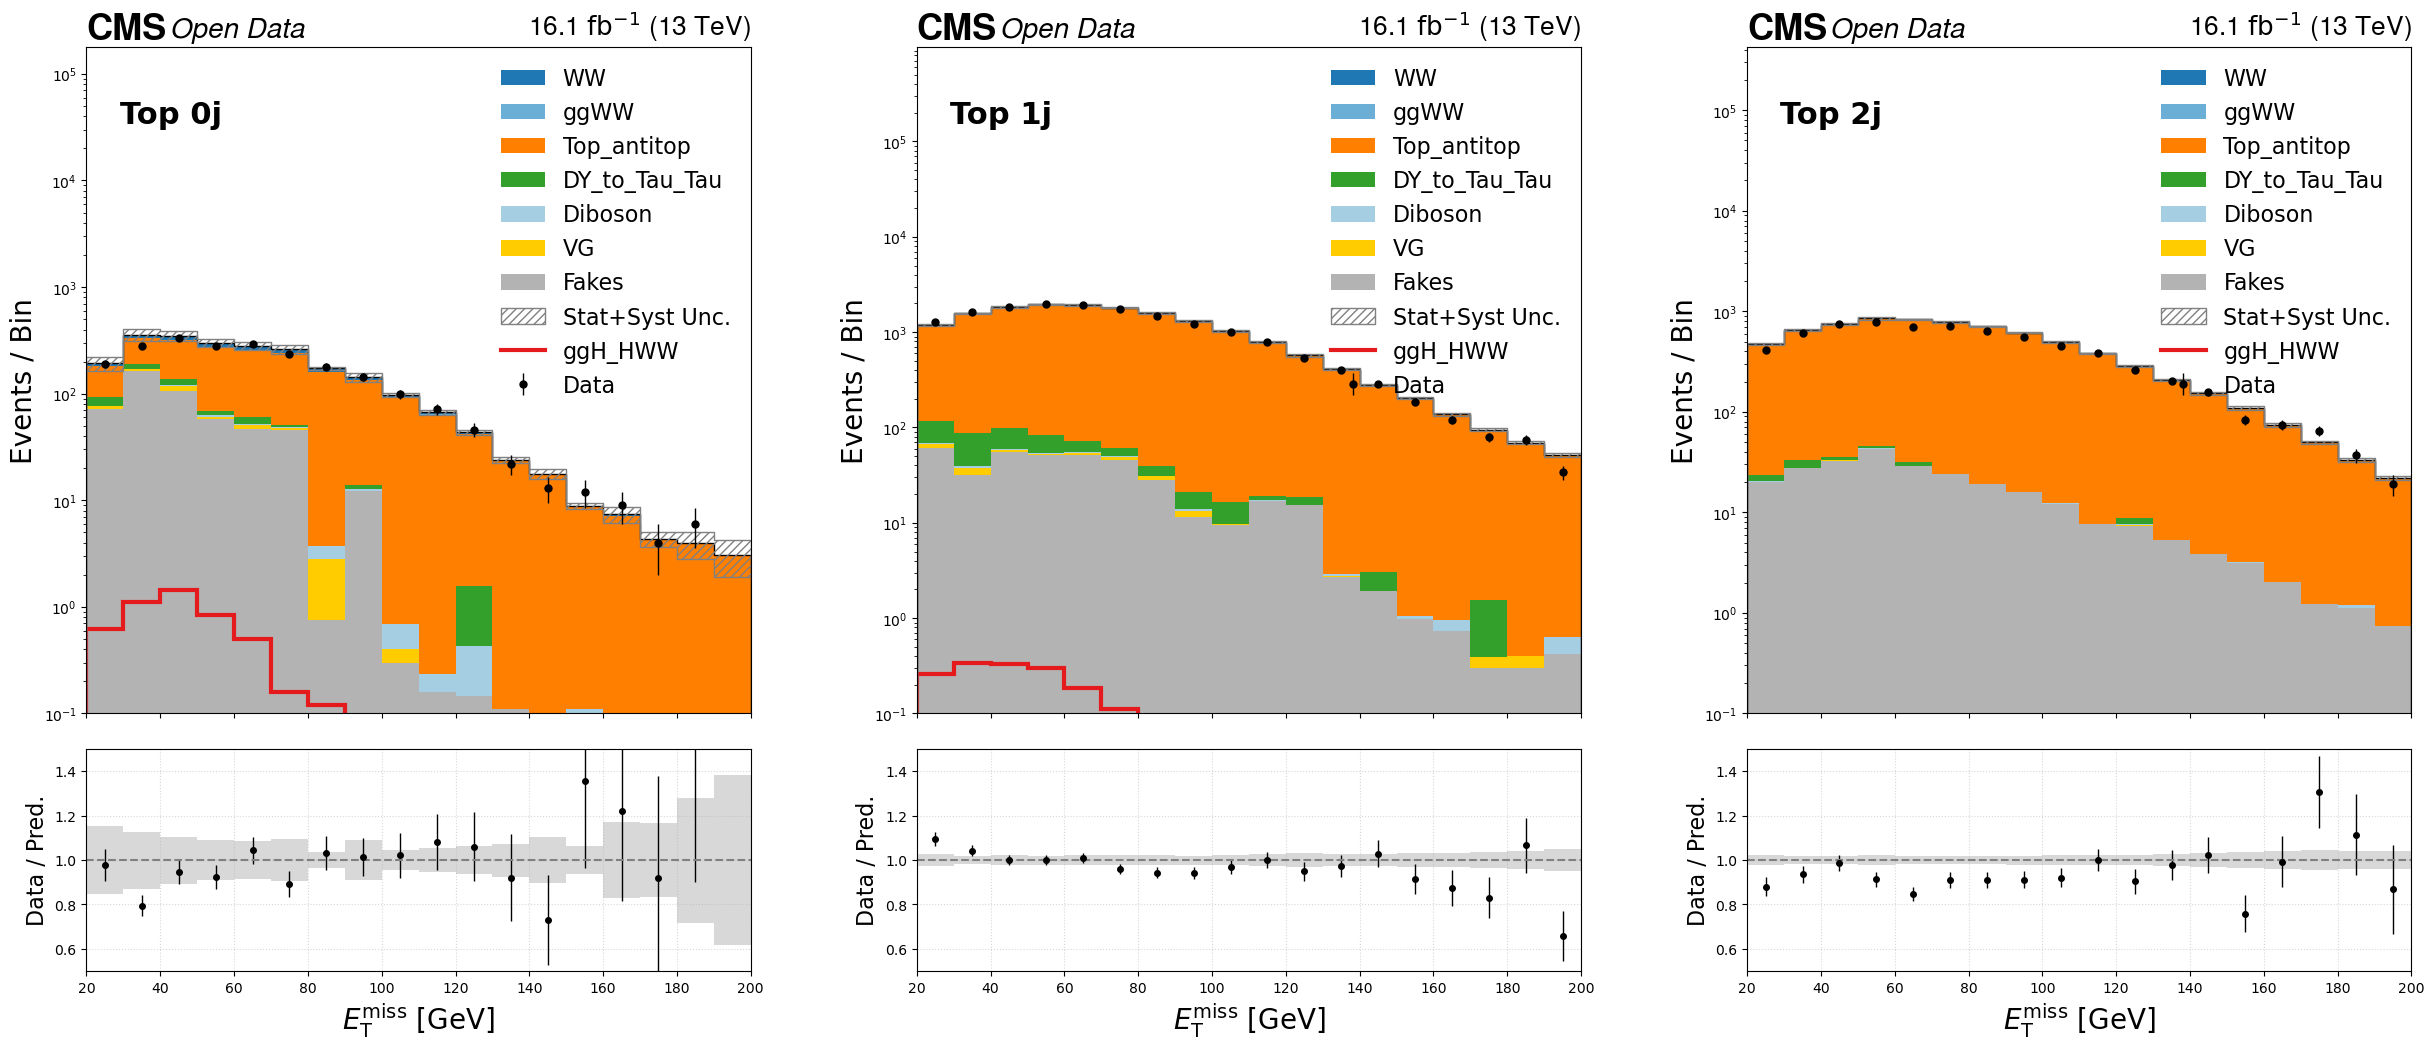

Plotting ptll in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_ptll.png


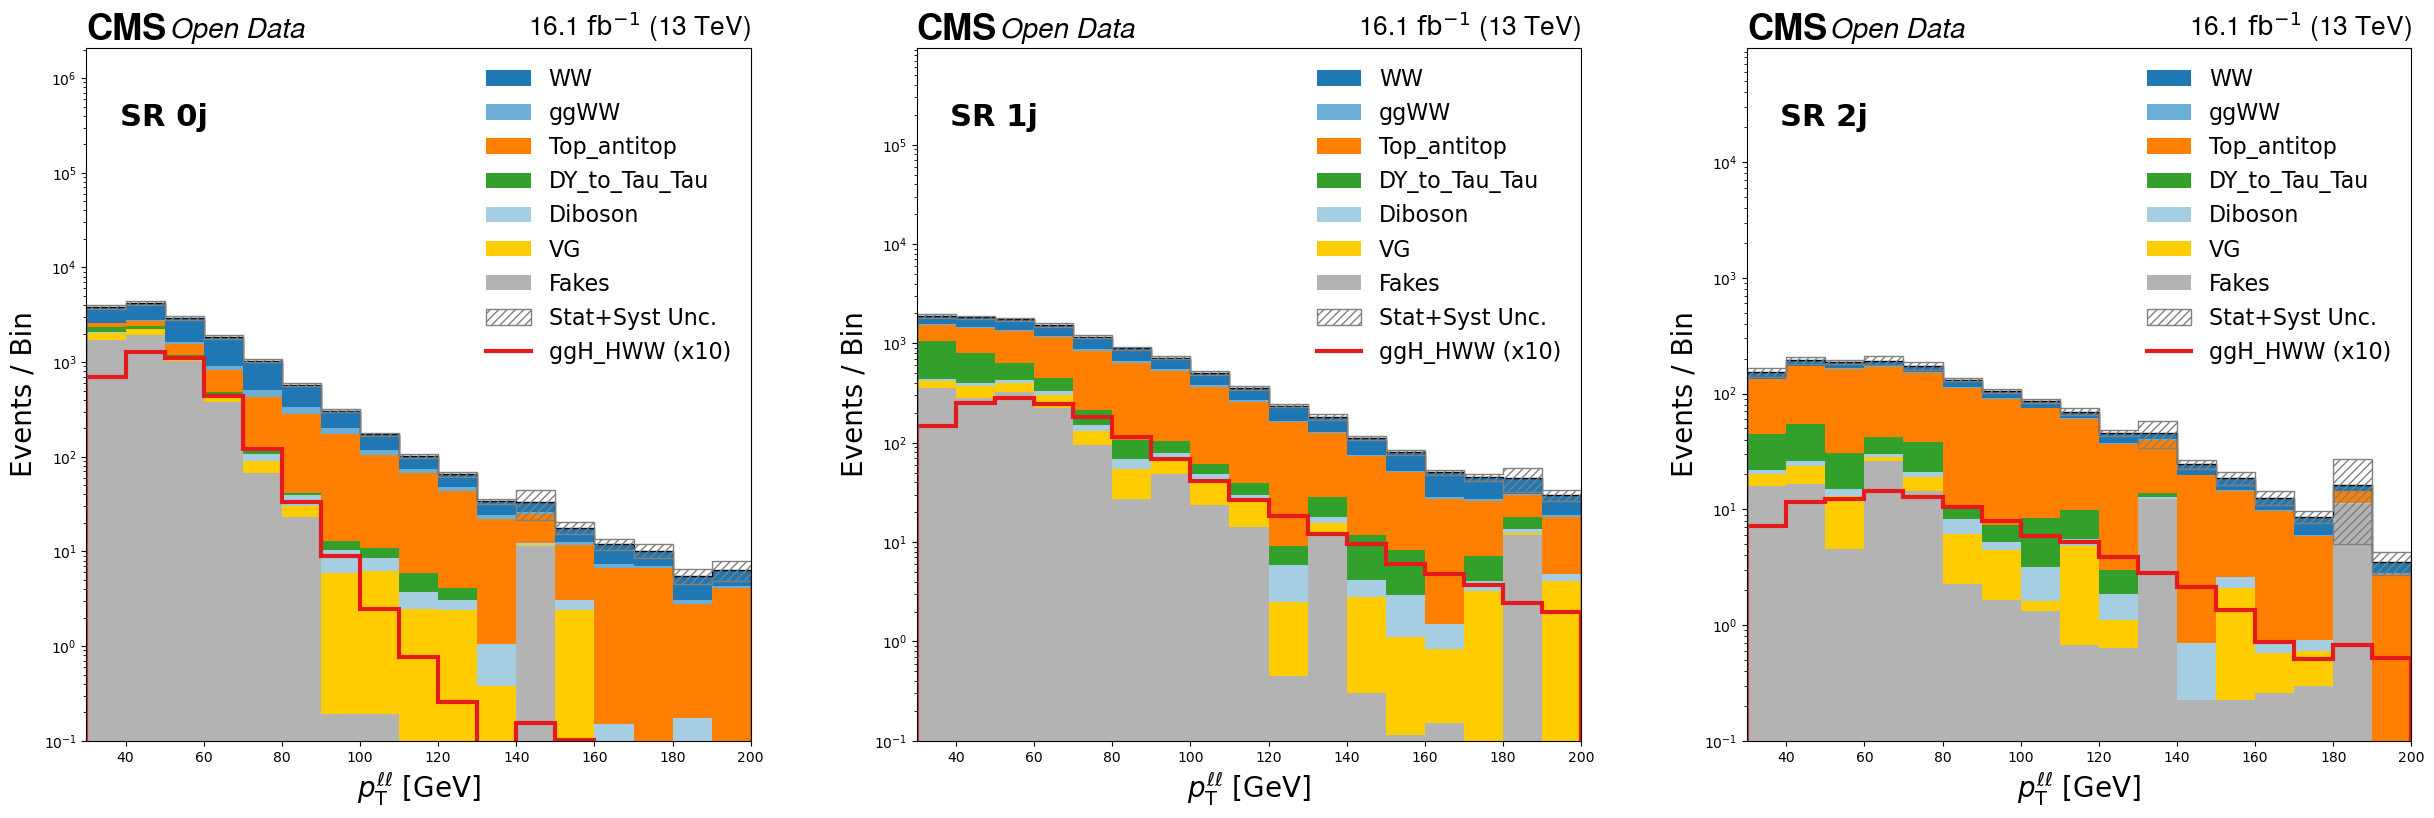

Plotting ptll in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_ptll.png


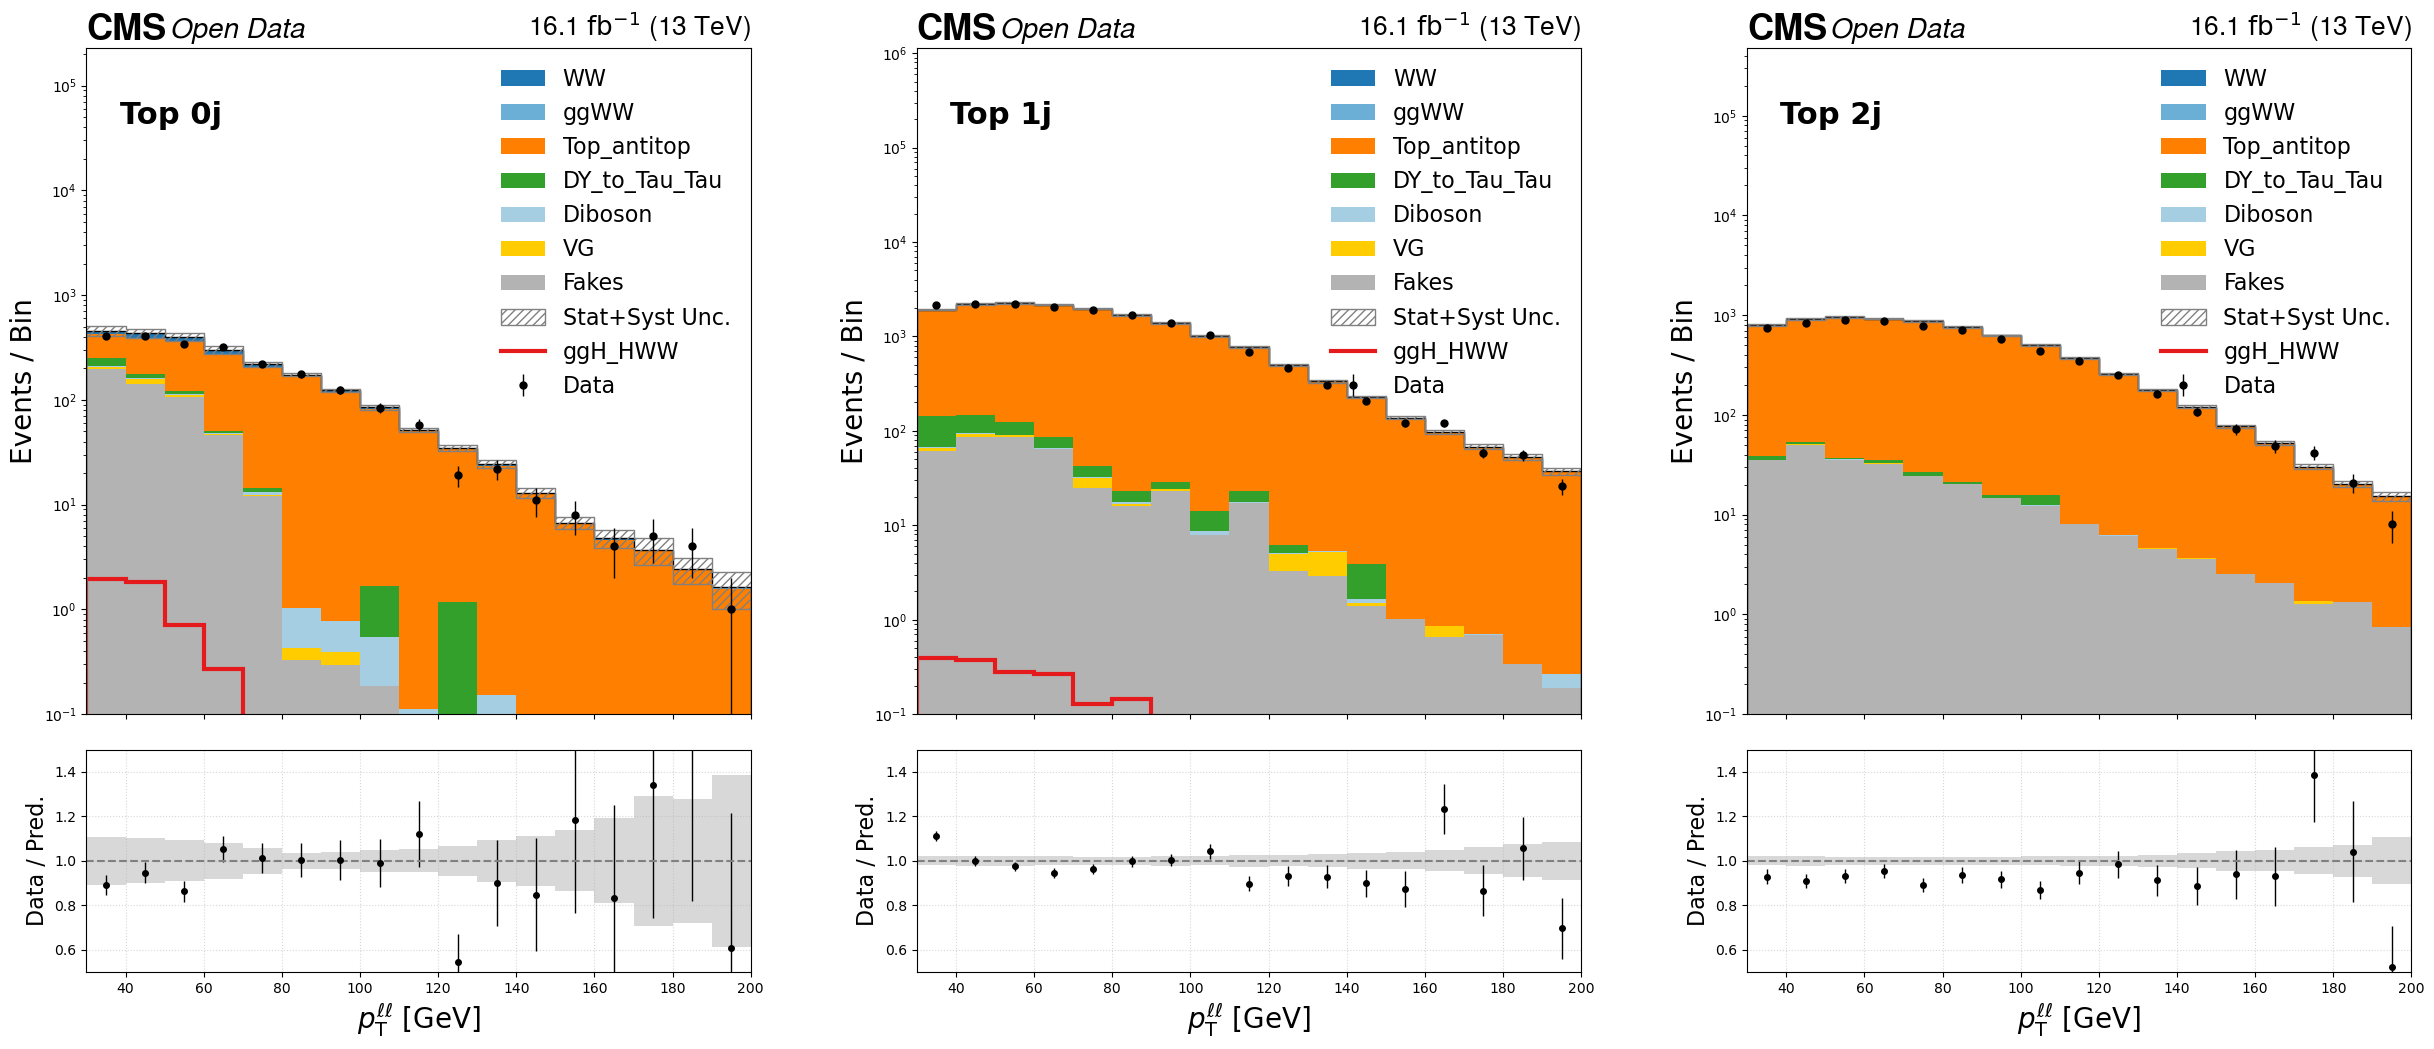

Plotting dphi in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_dphi.png


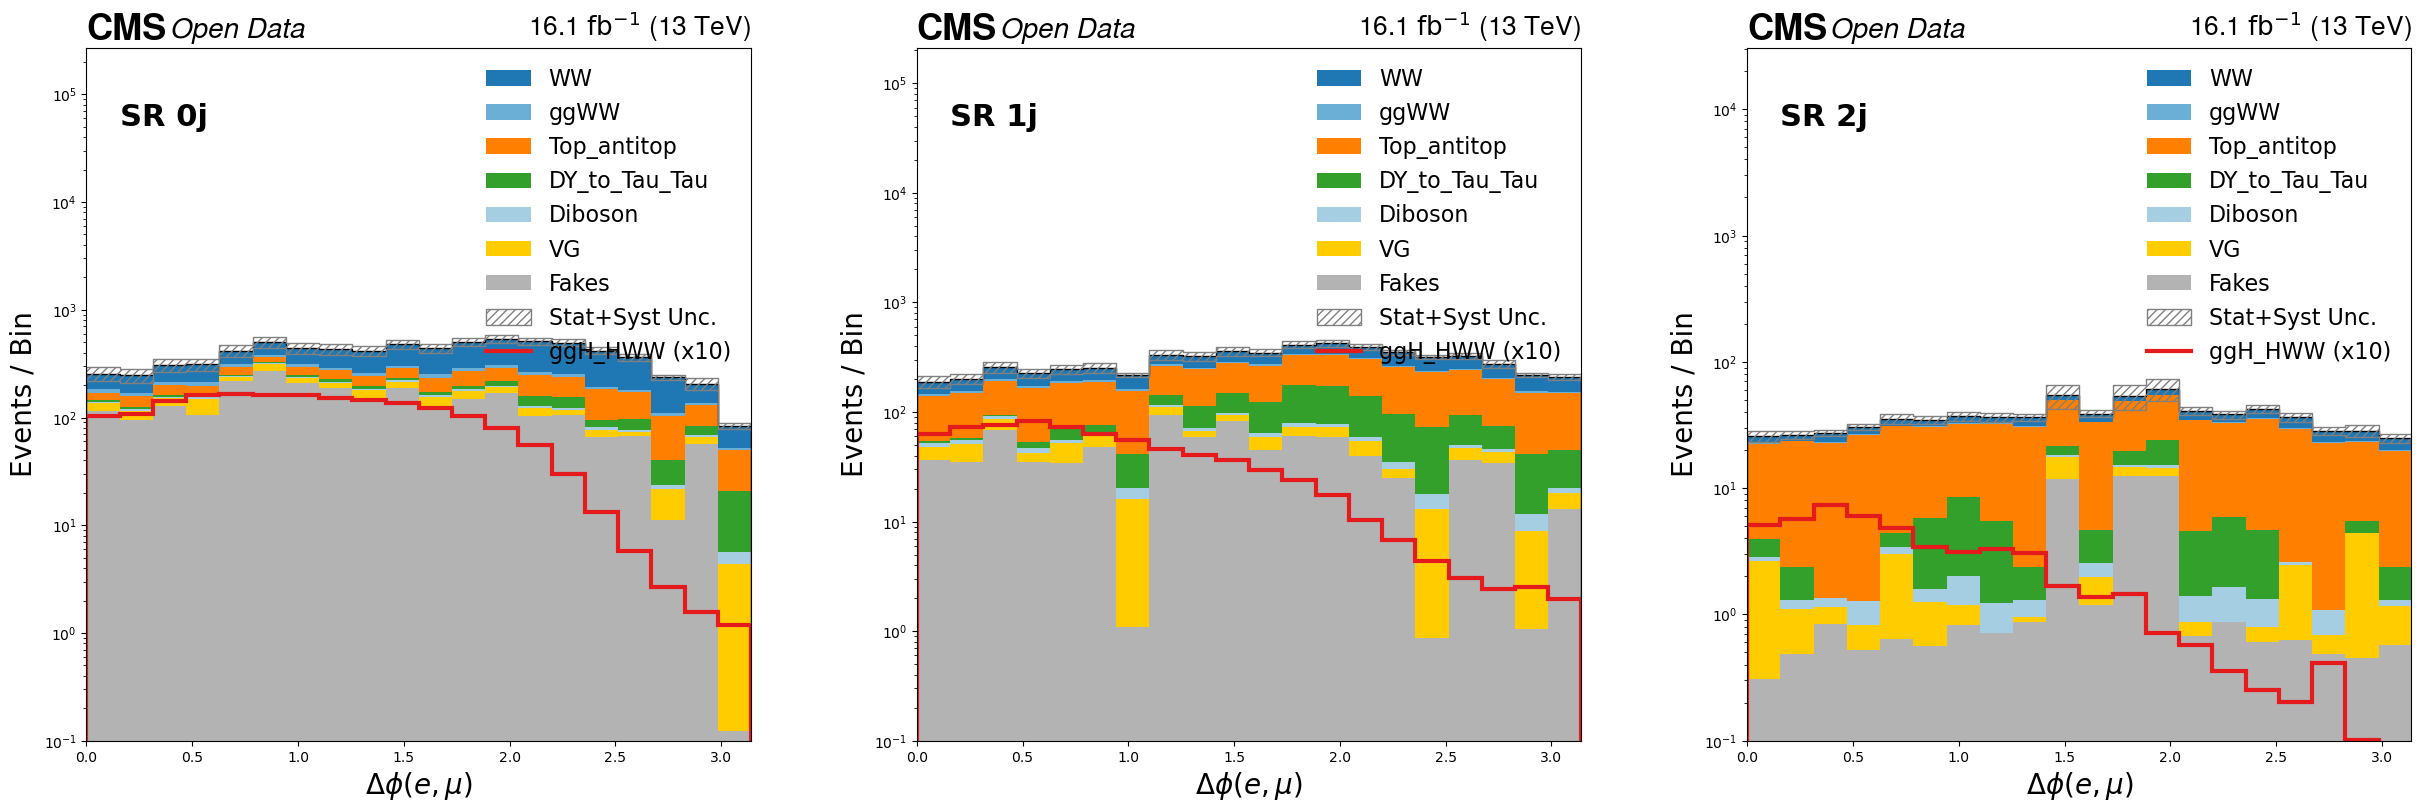

Plotting dphi in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_dphi.png


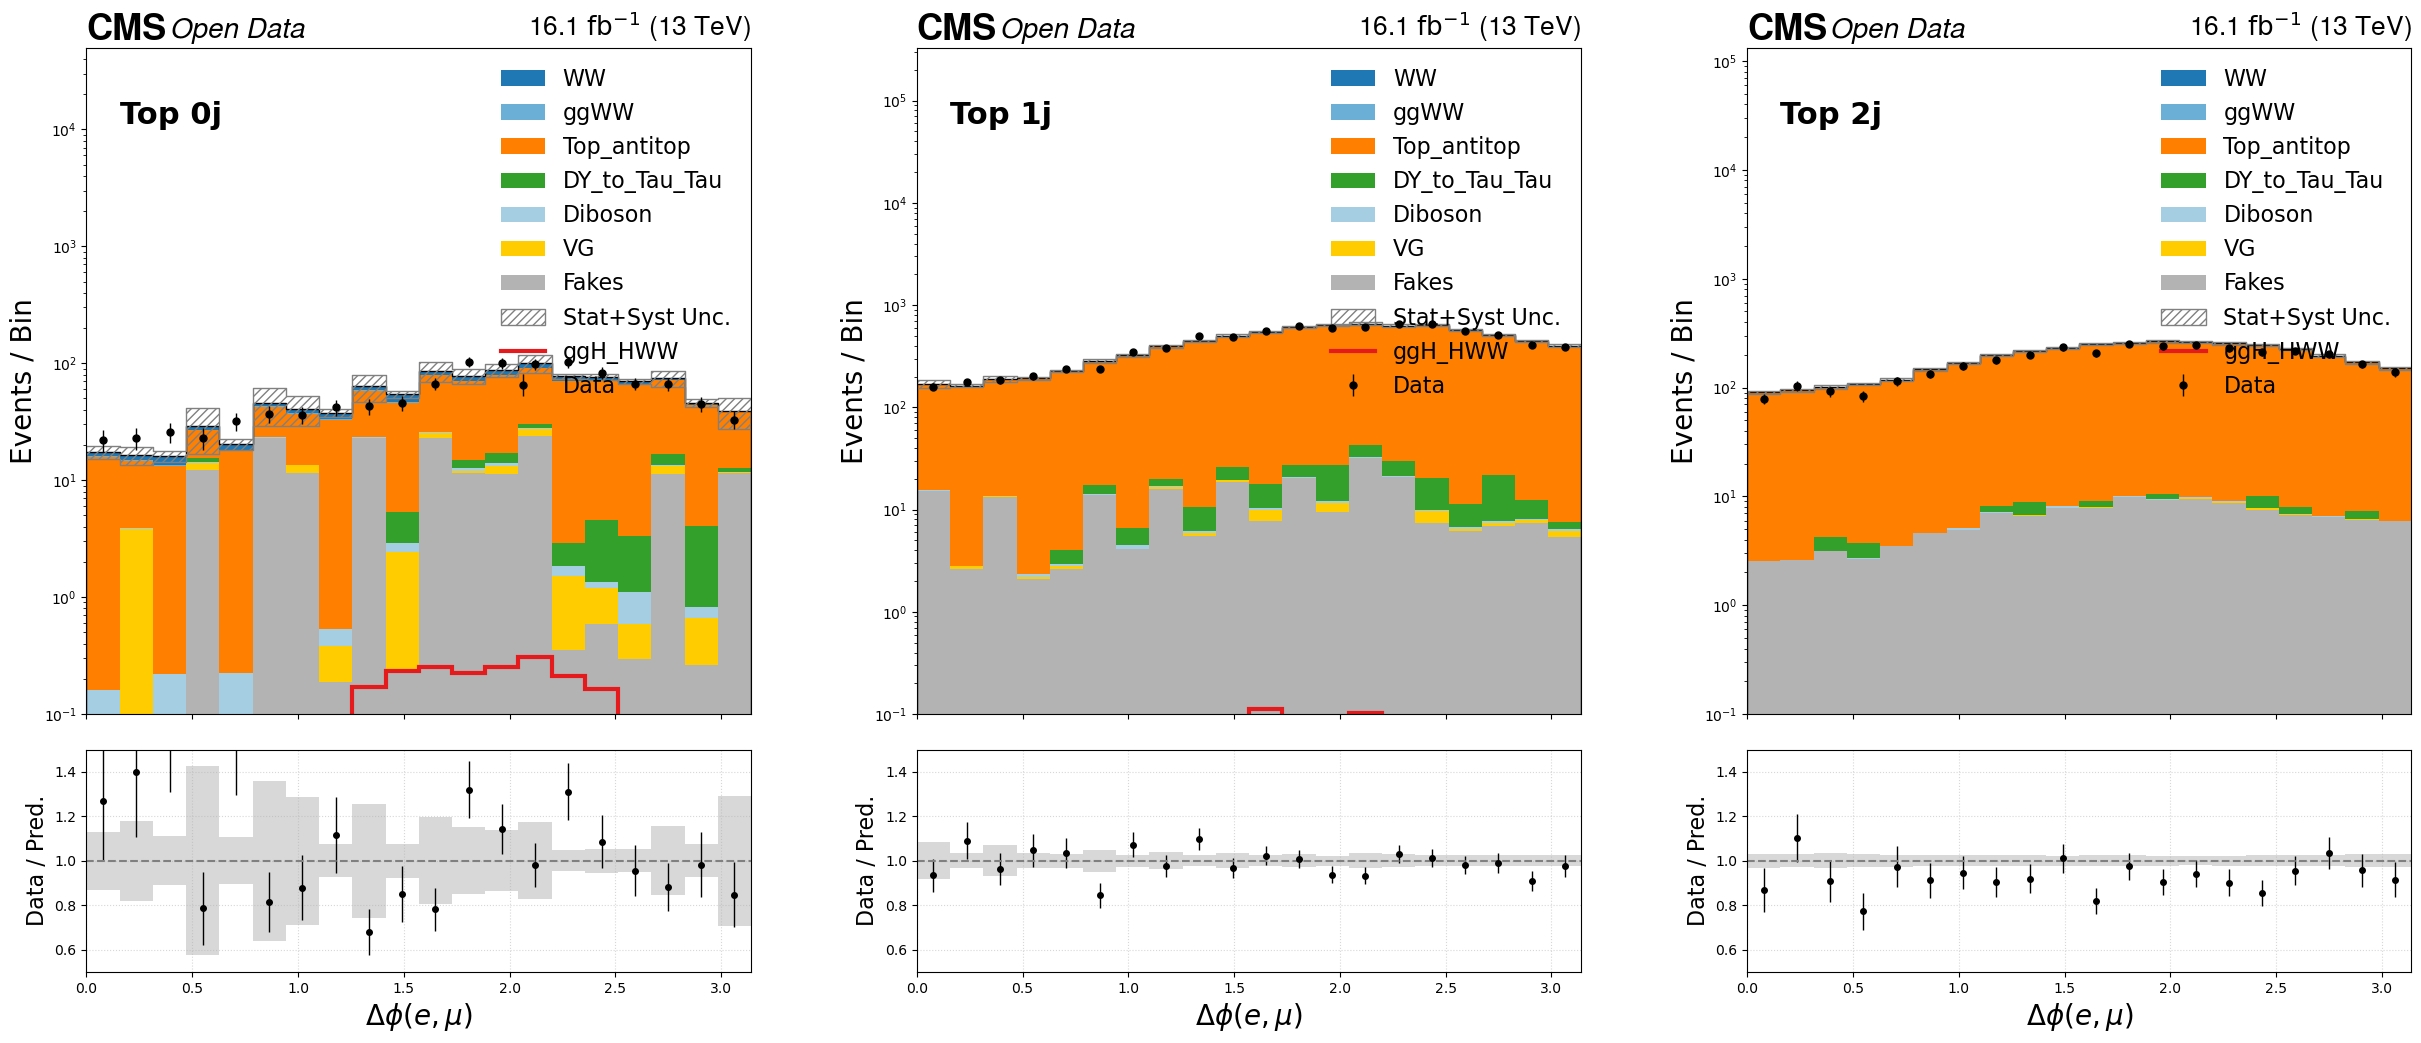

Plotting mt_higgs in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_mt_higgs.png


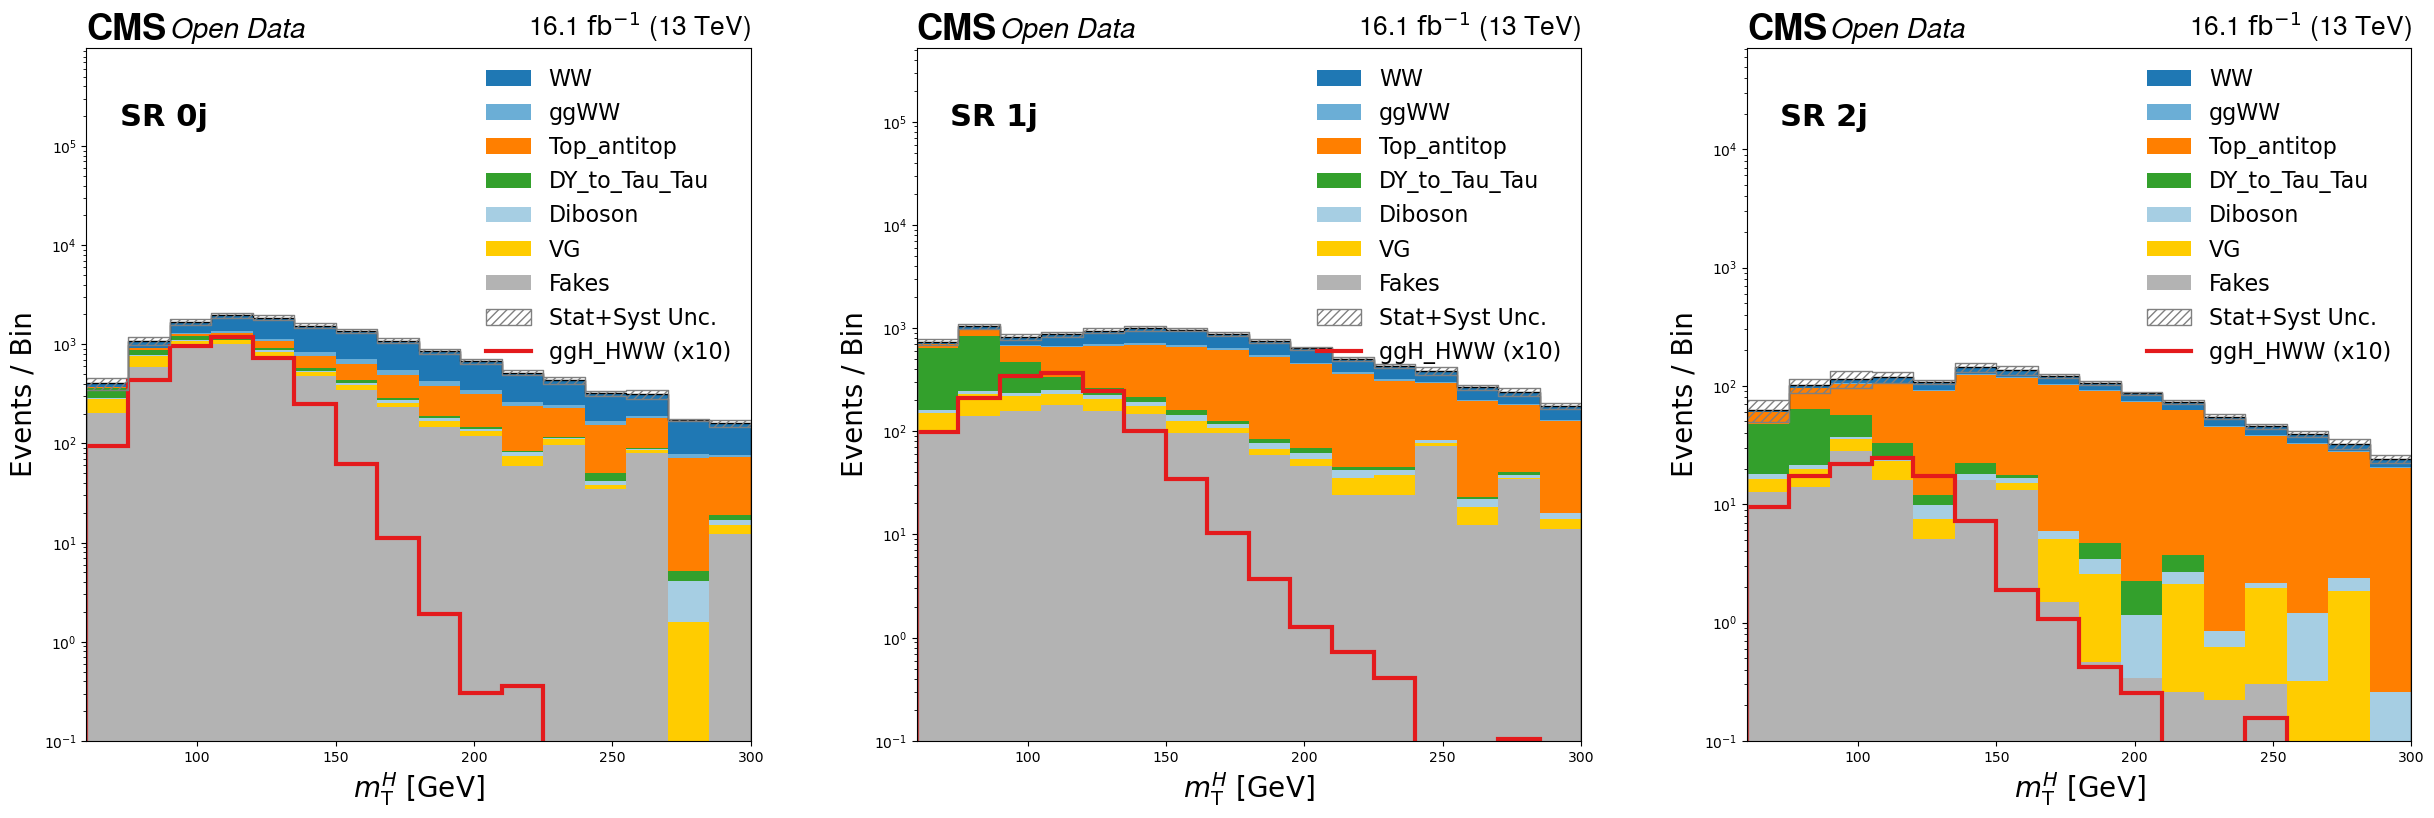

Plotting mt_higgs in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_higgs.png


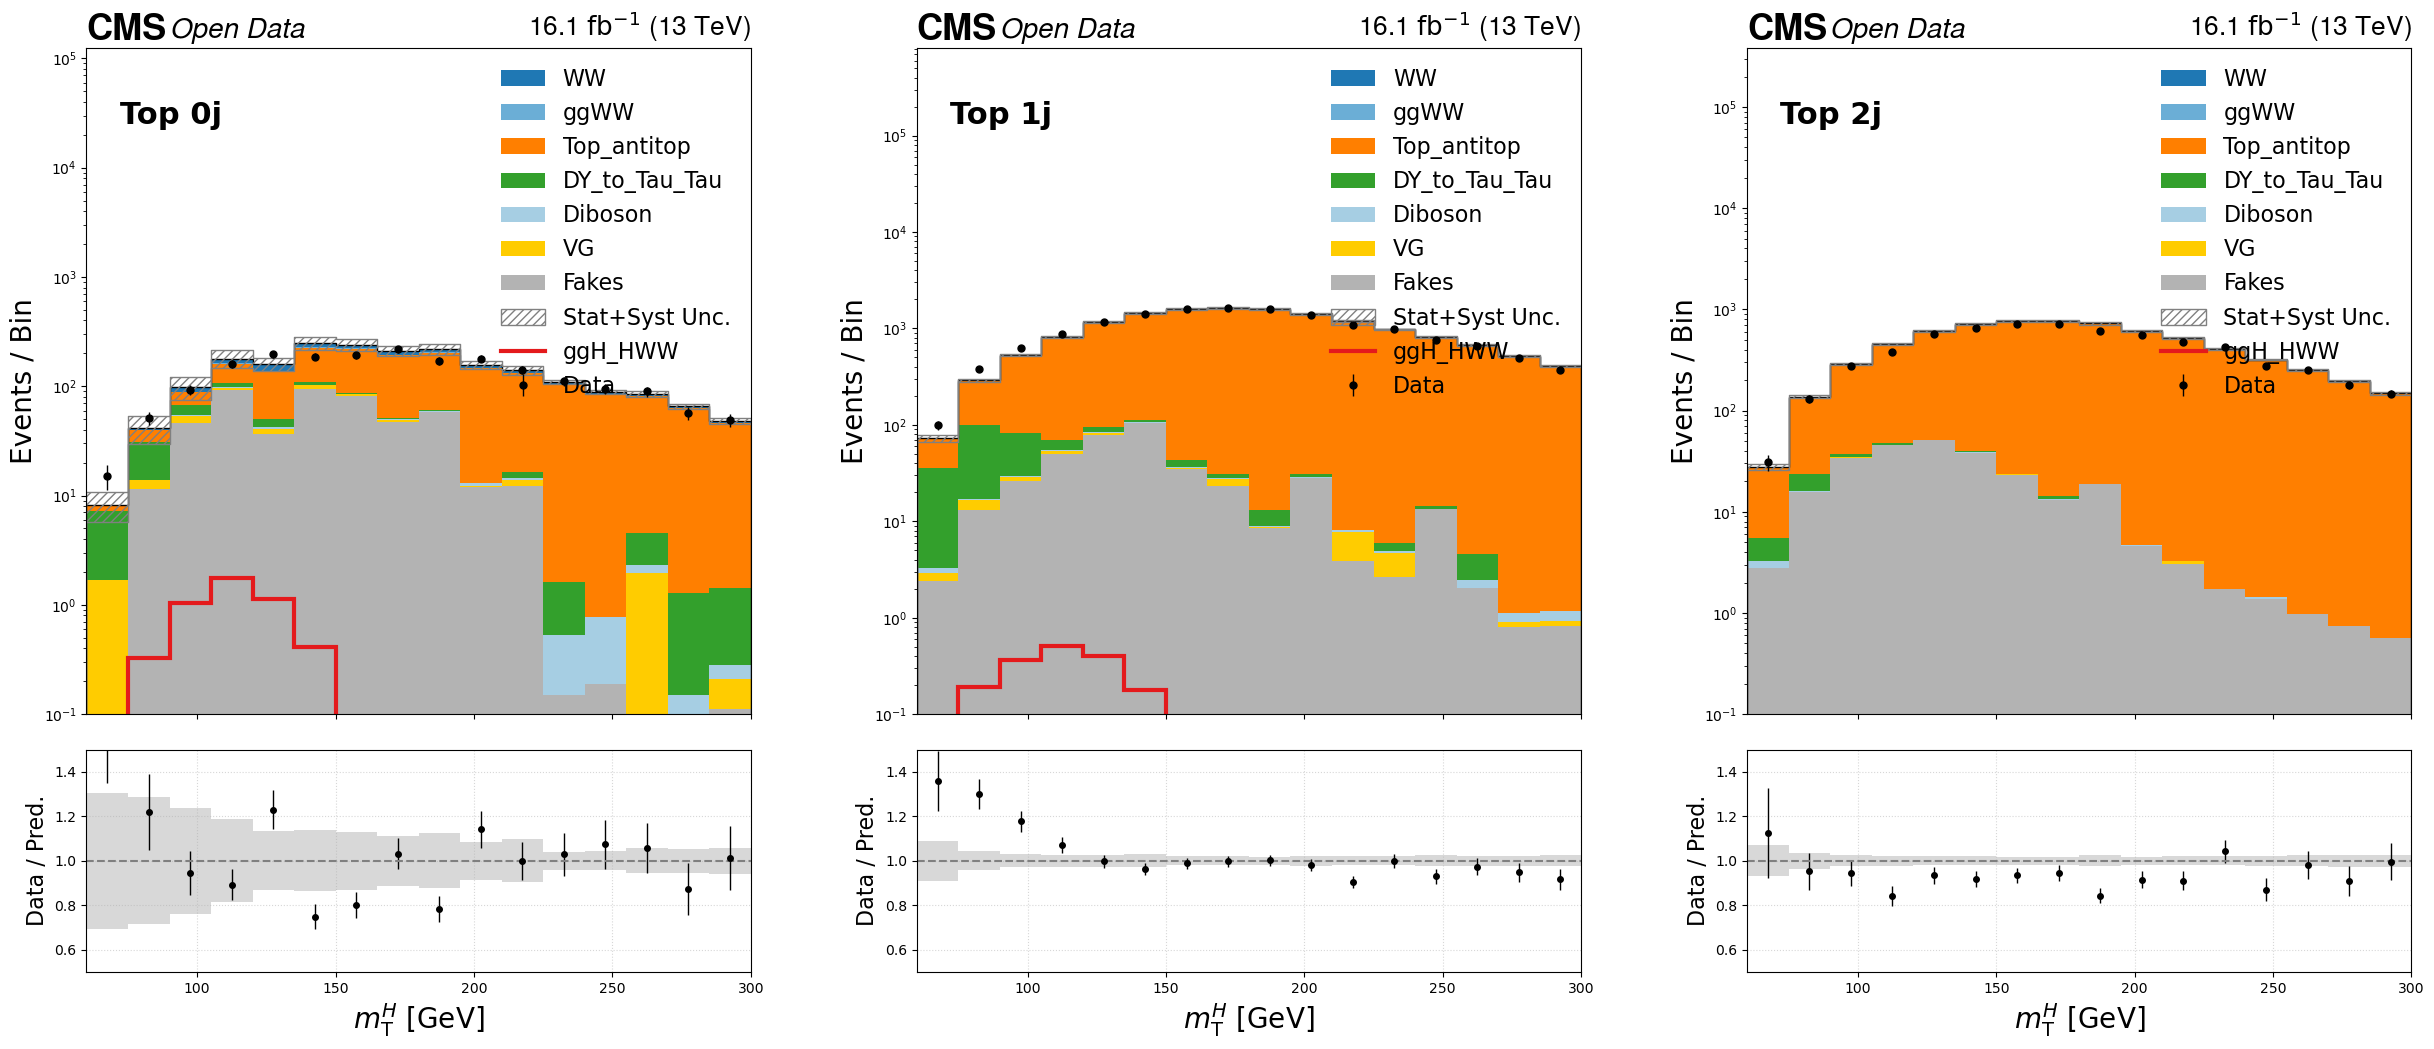

Plotting mt_l2_met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_mt_l2_met.png


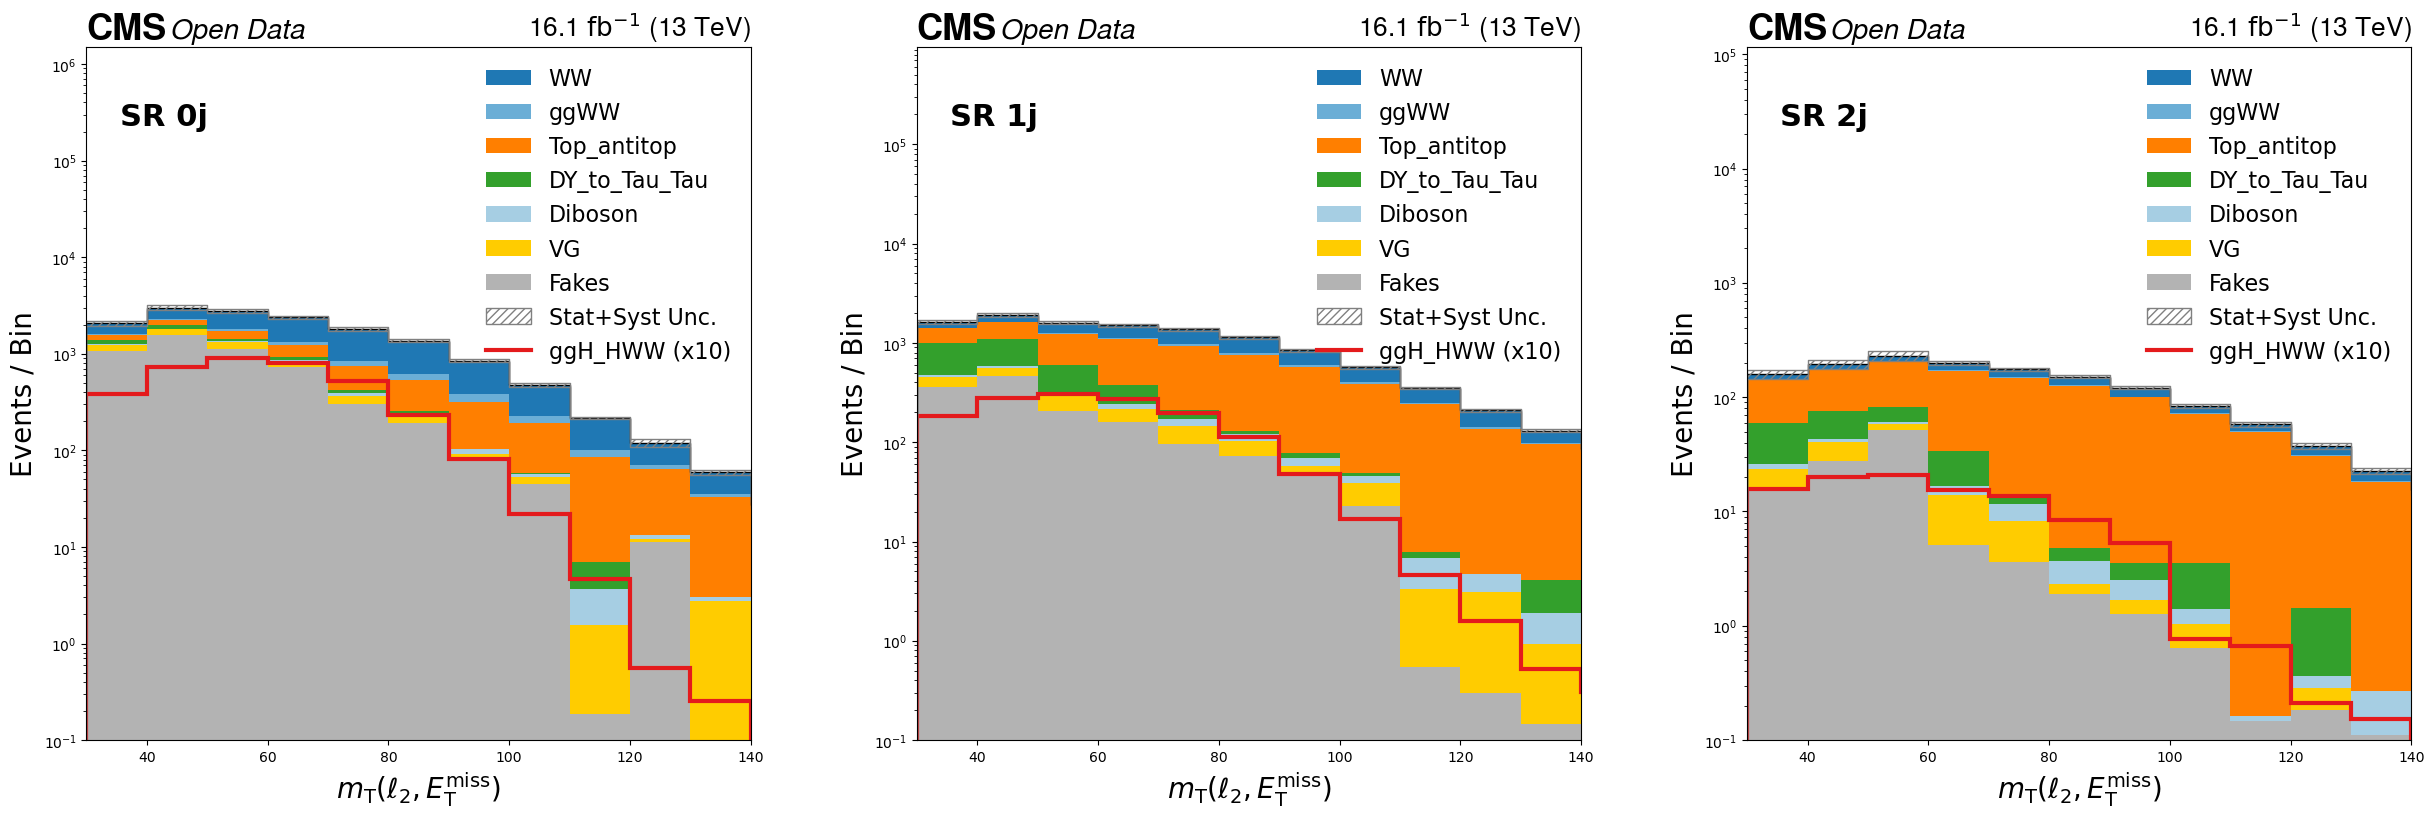

Plotting mt_l2_met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_l2_met.png


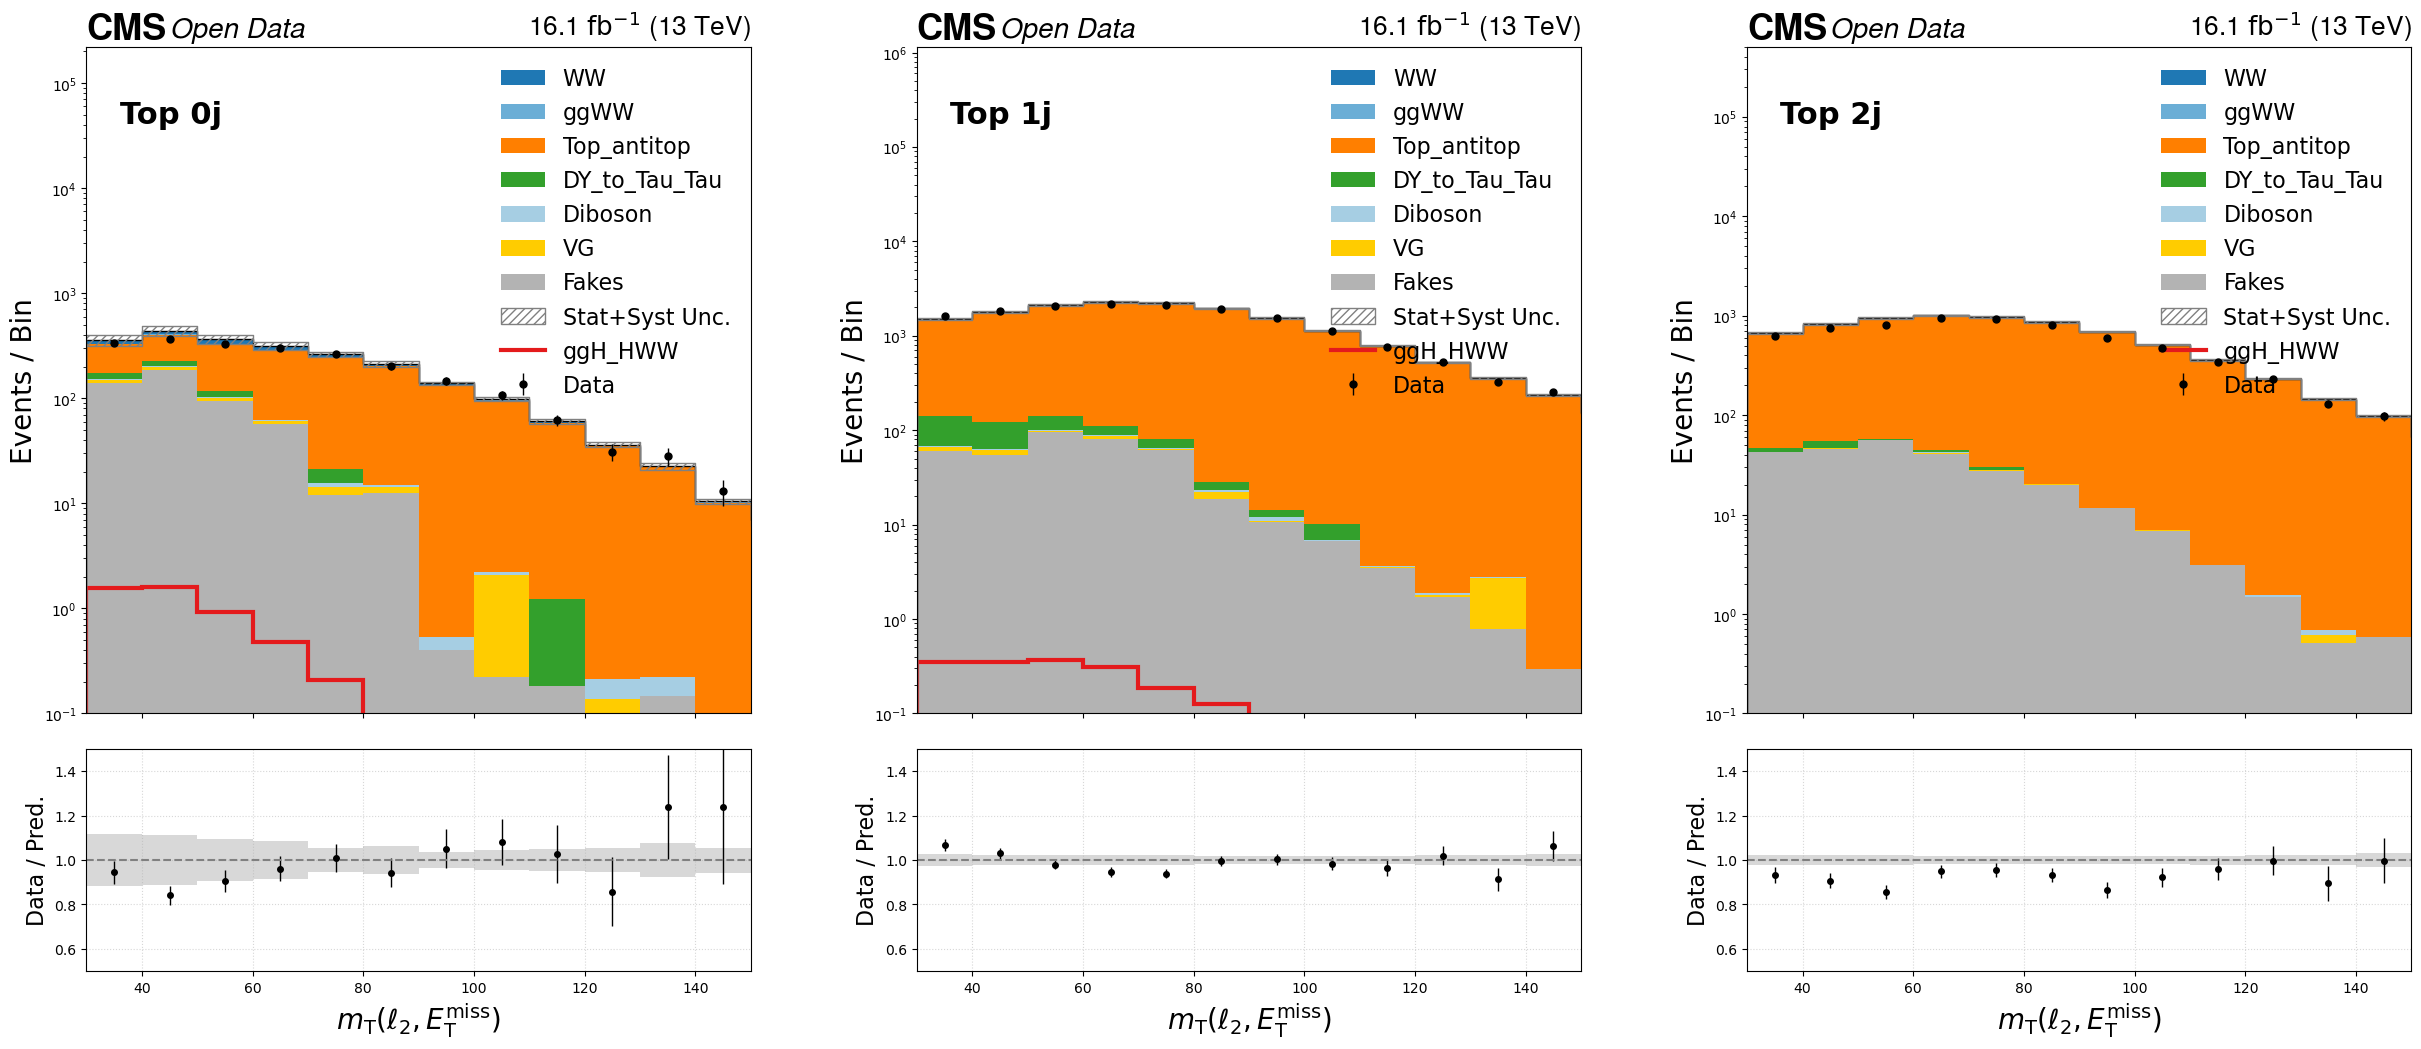

Plotting mjj in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_mjj.png


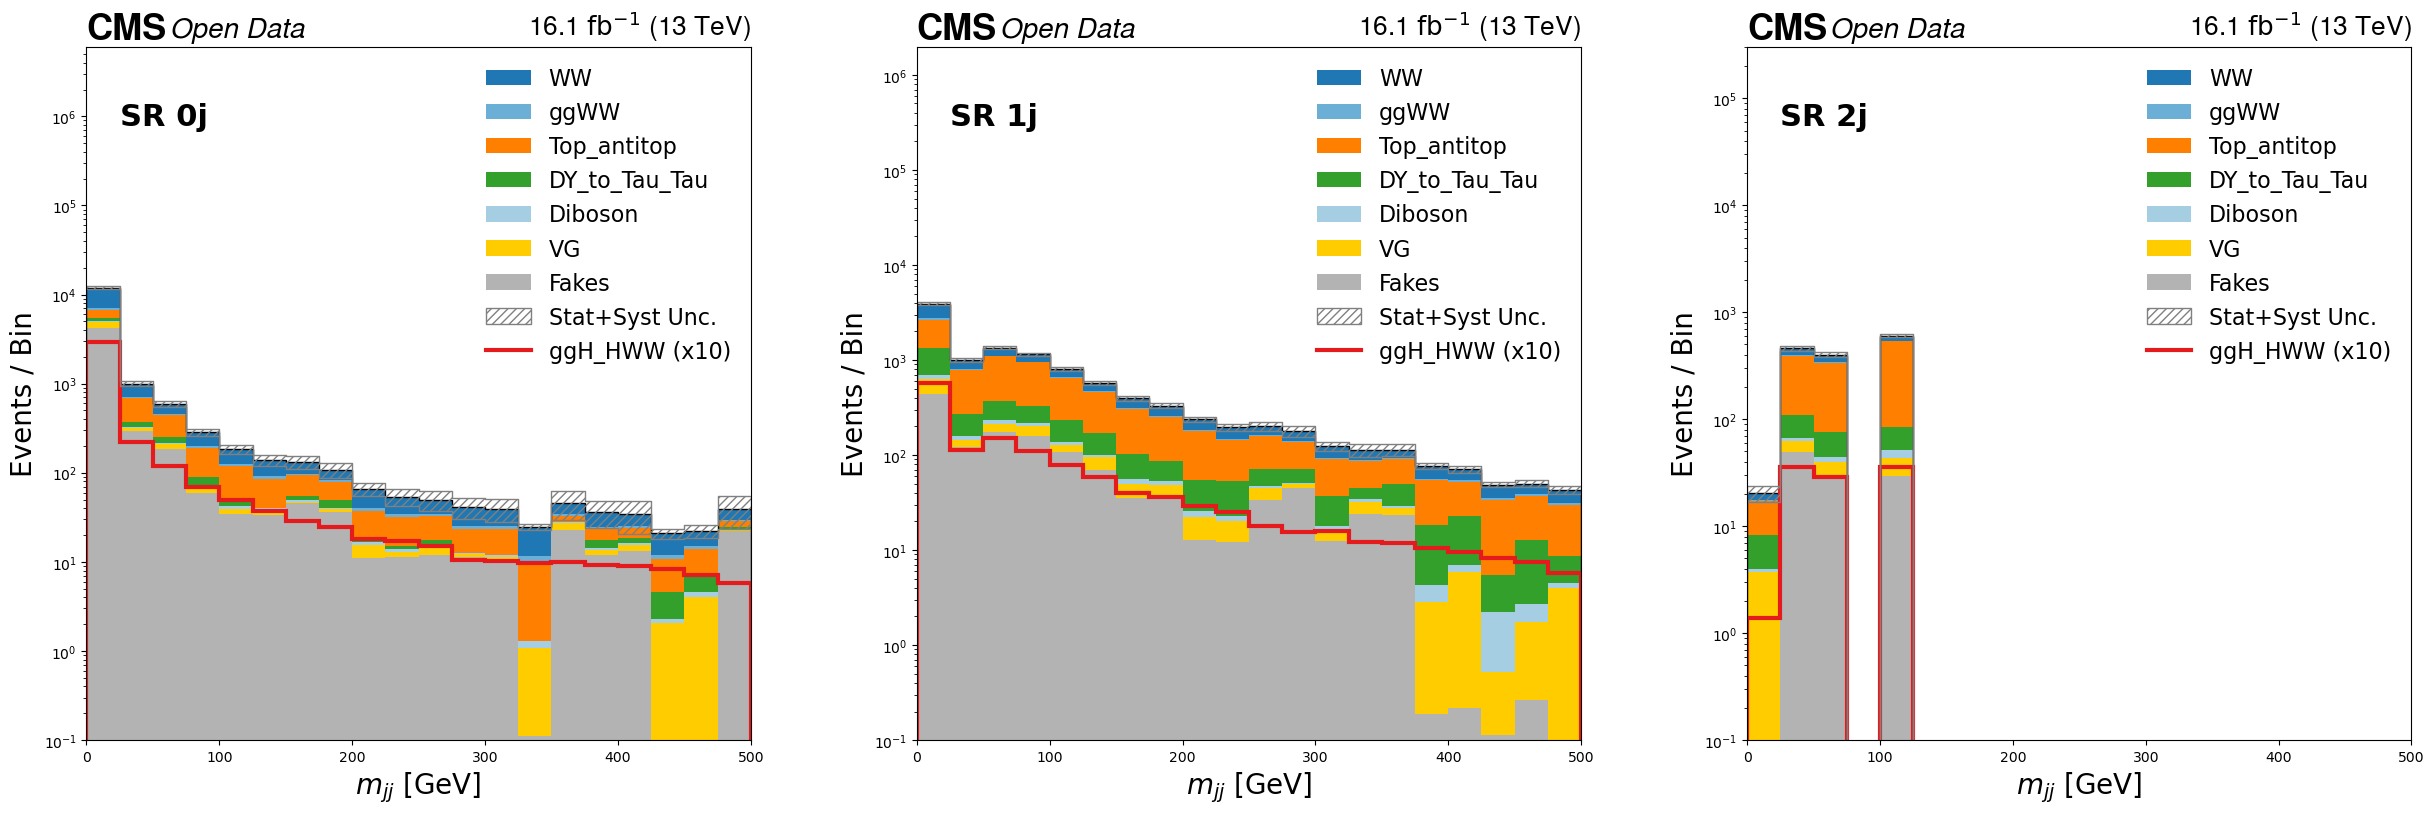

Plotting mjj in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_mjj.png


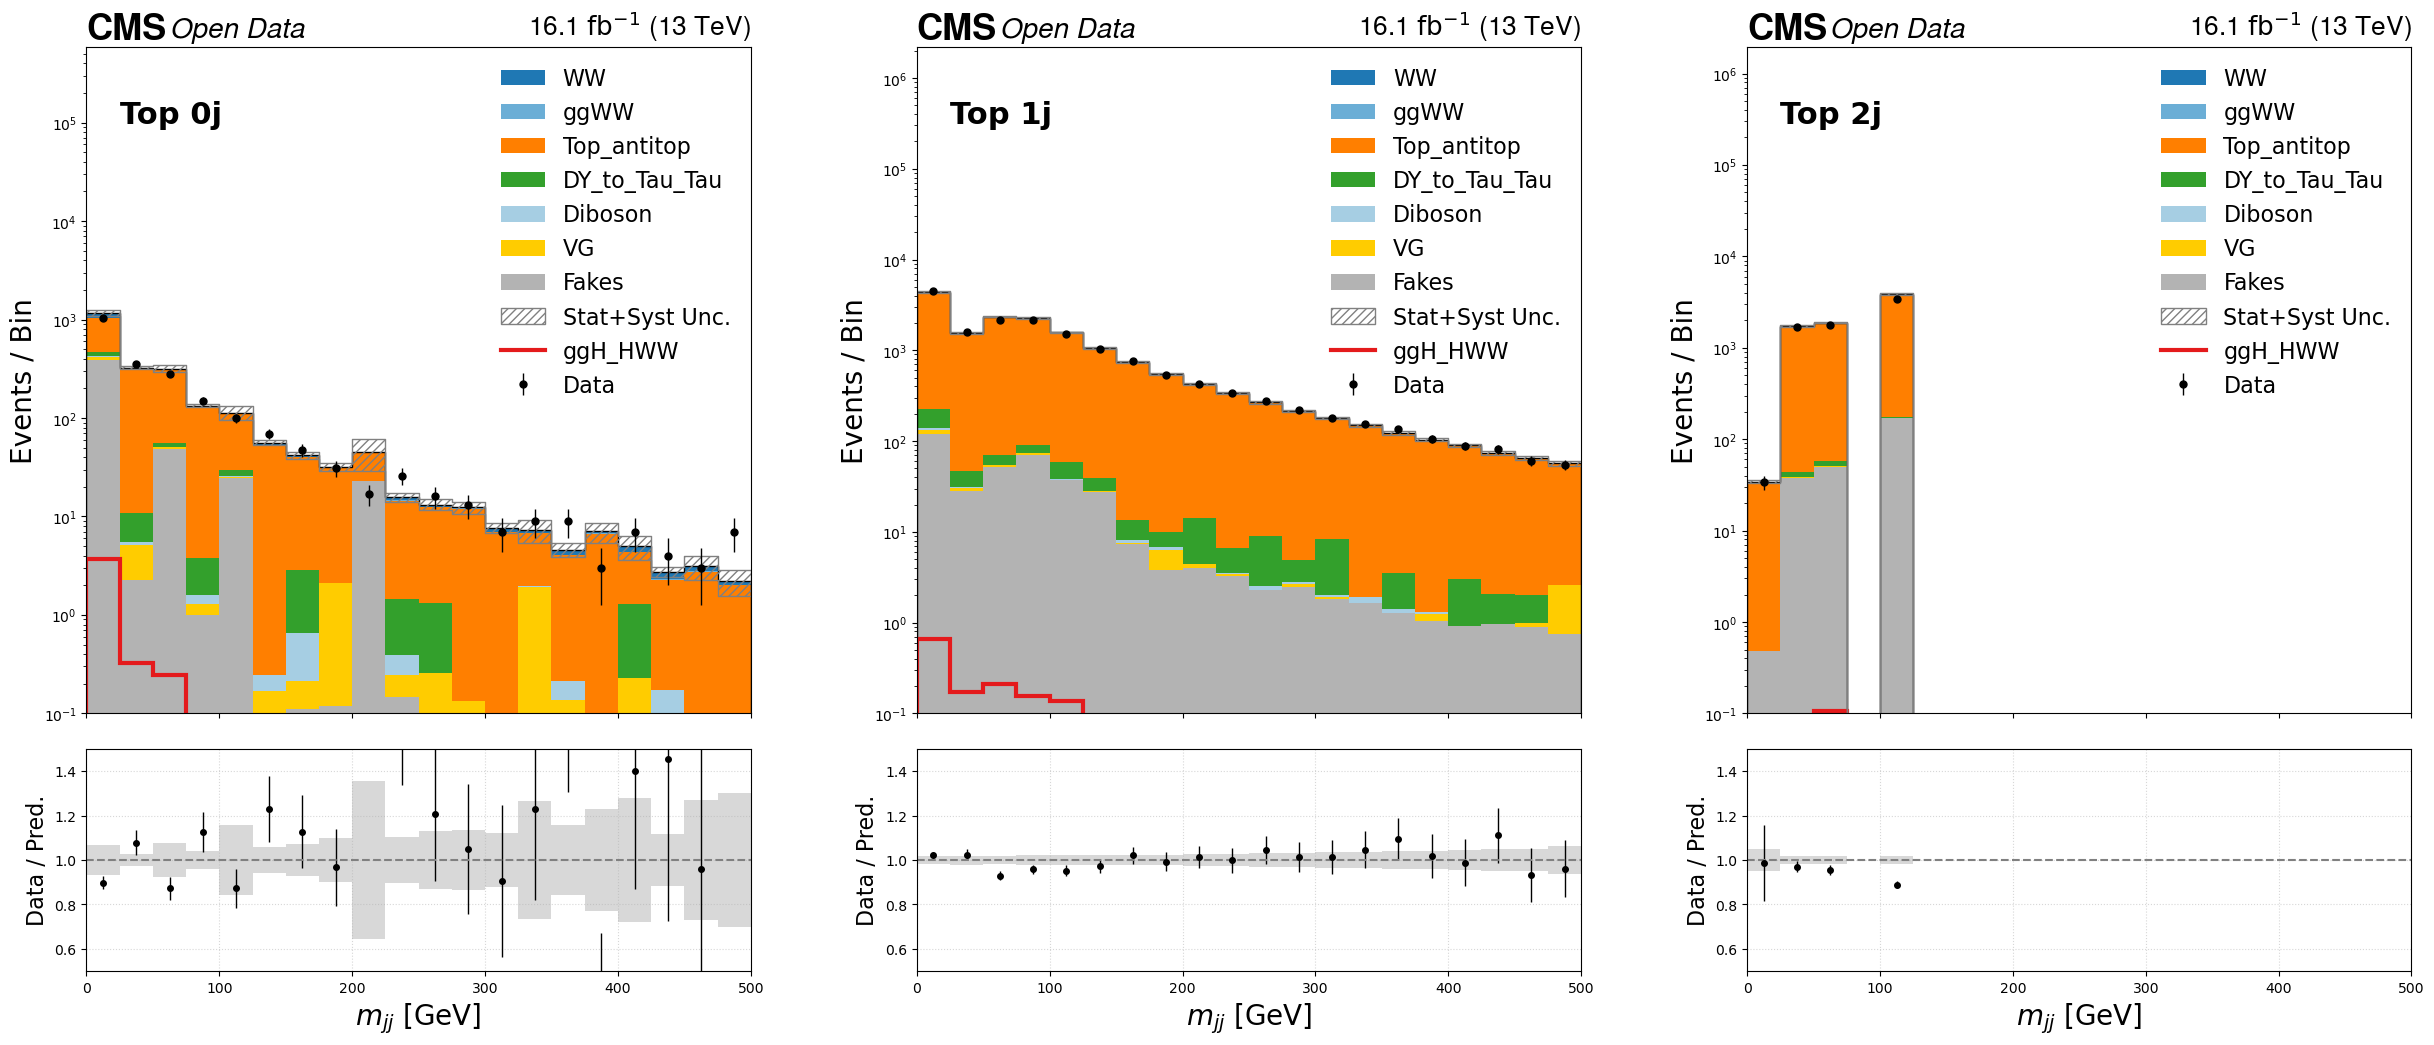

Plotting leading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_leading_pt.png


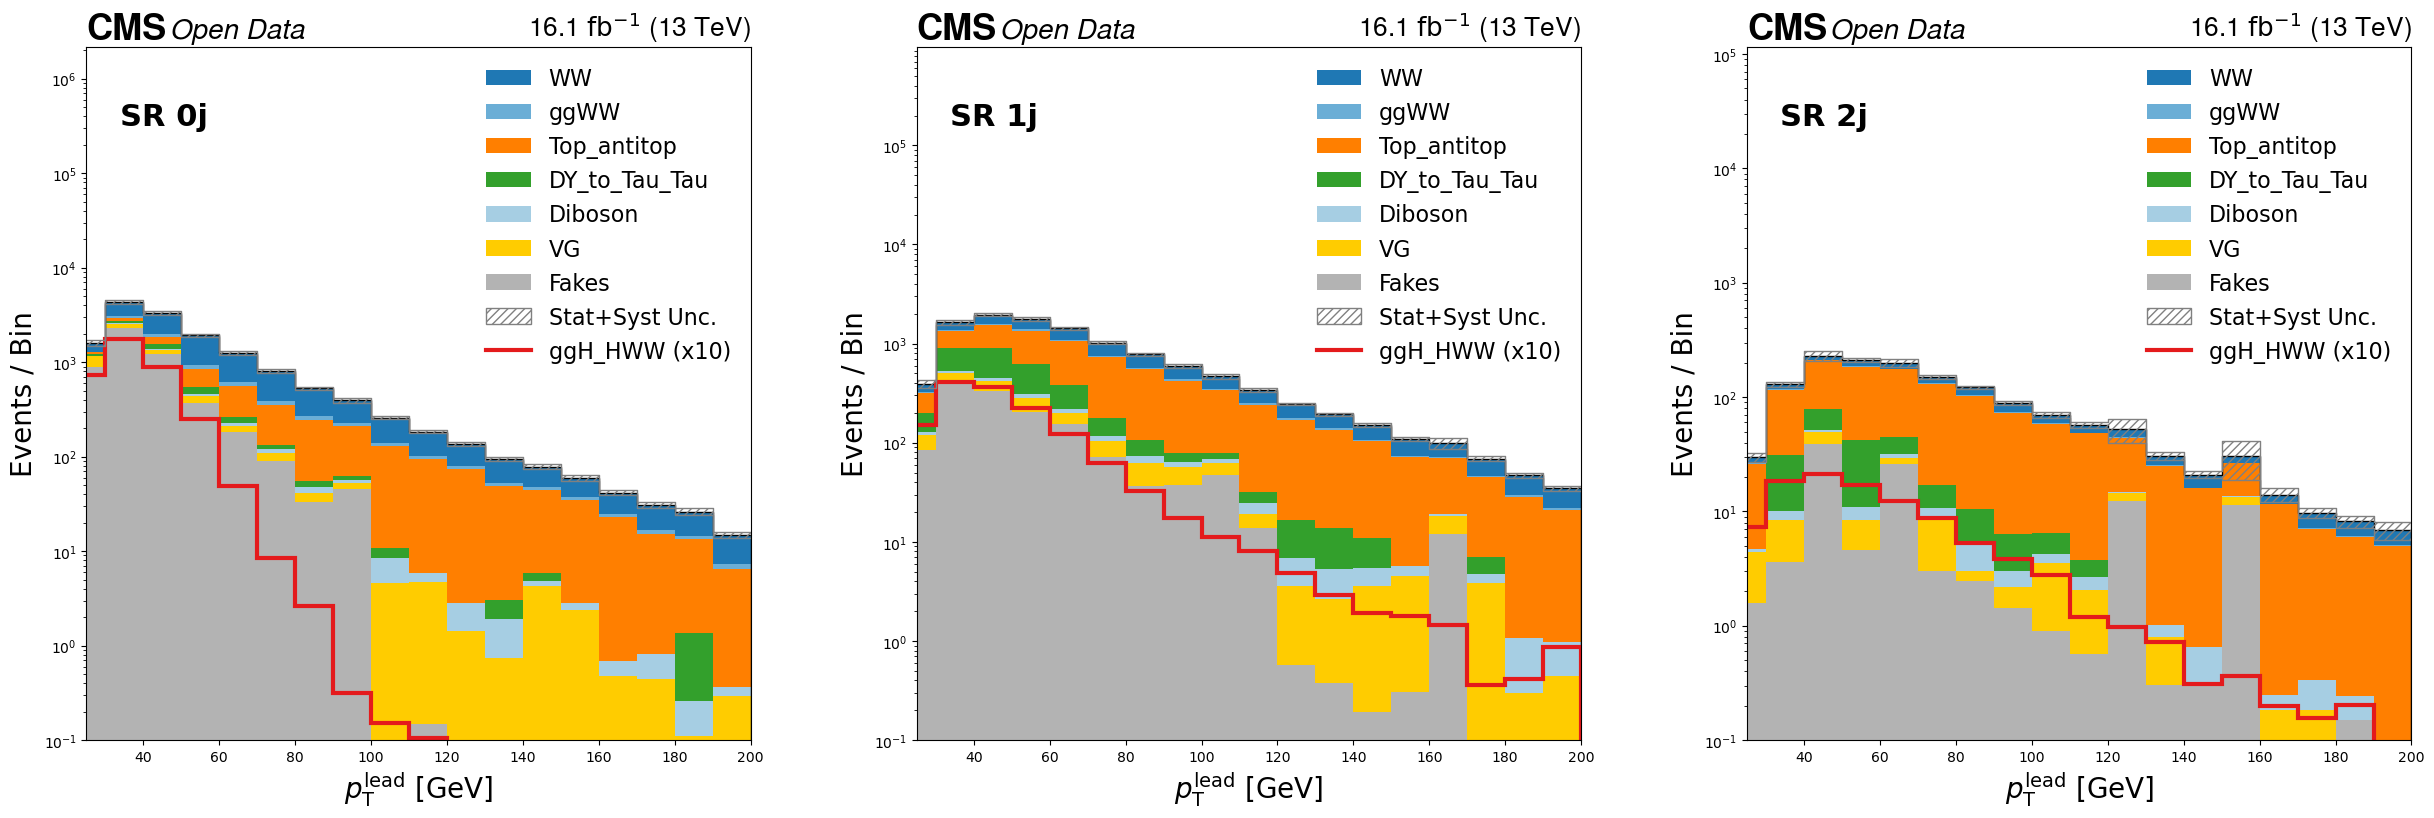

Plotting leading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_leading_pt.png


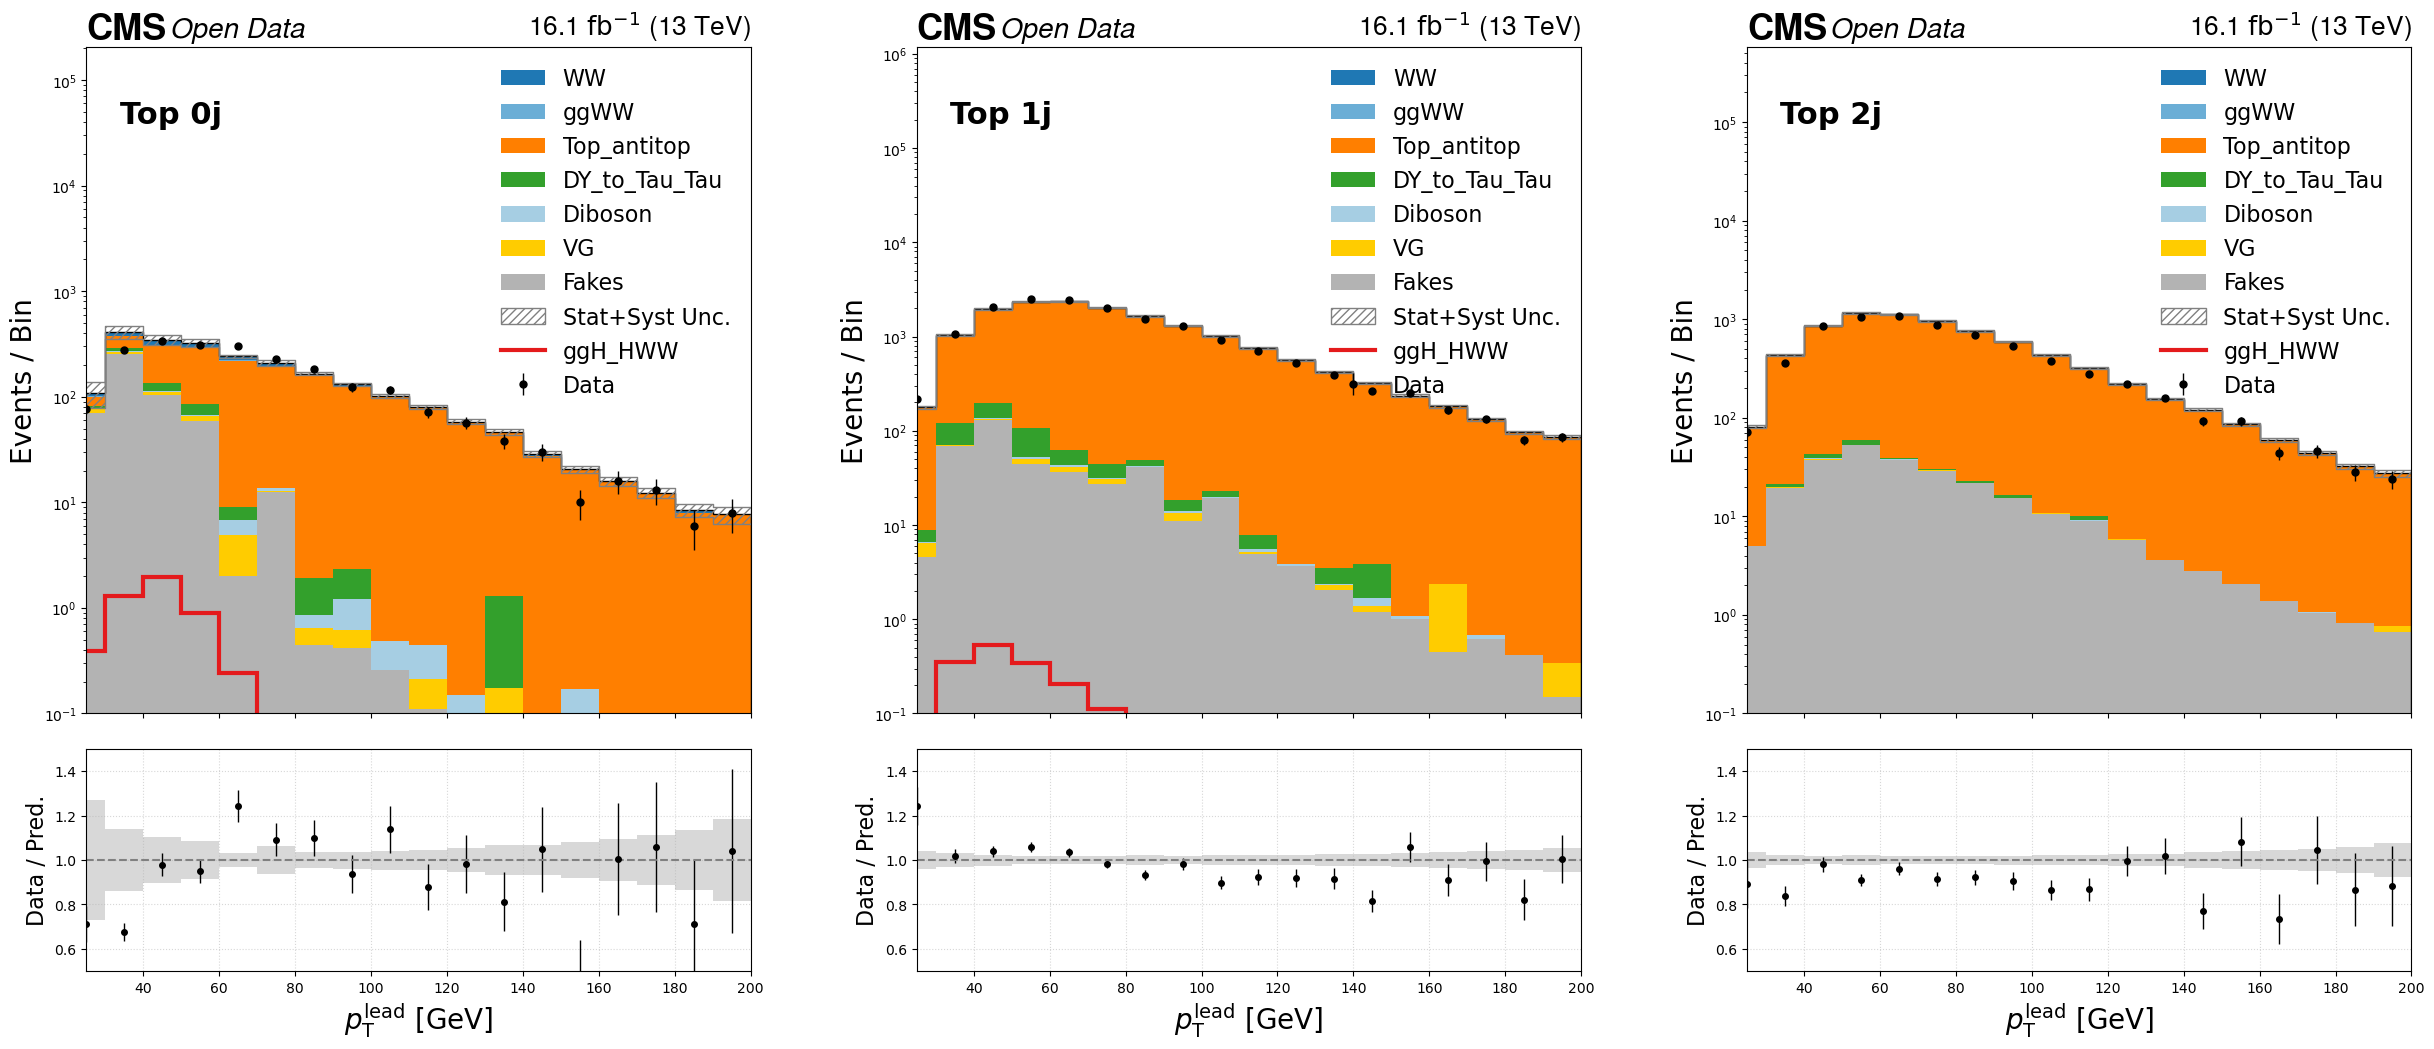

Plotting subleading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Signal_Region_subleading_pt.png


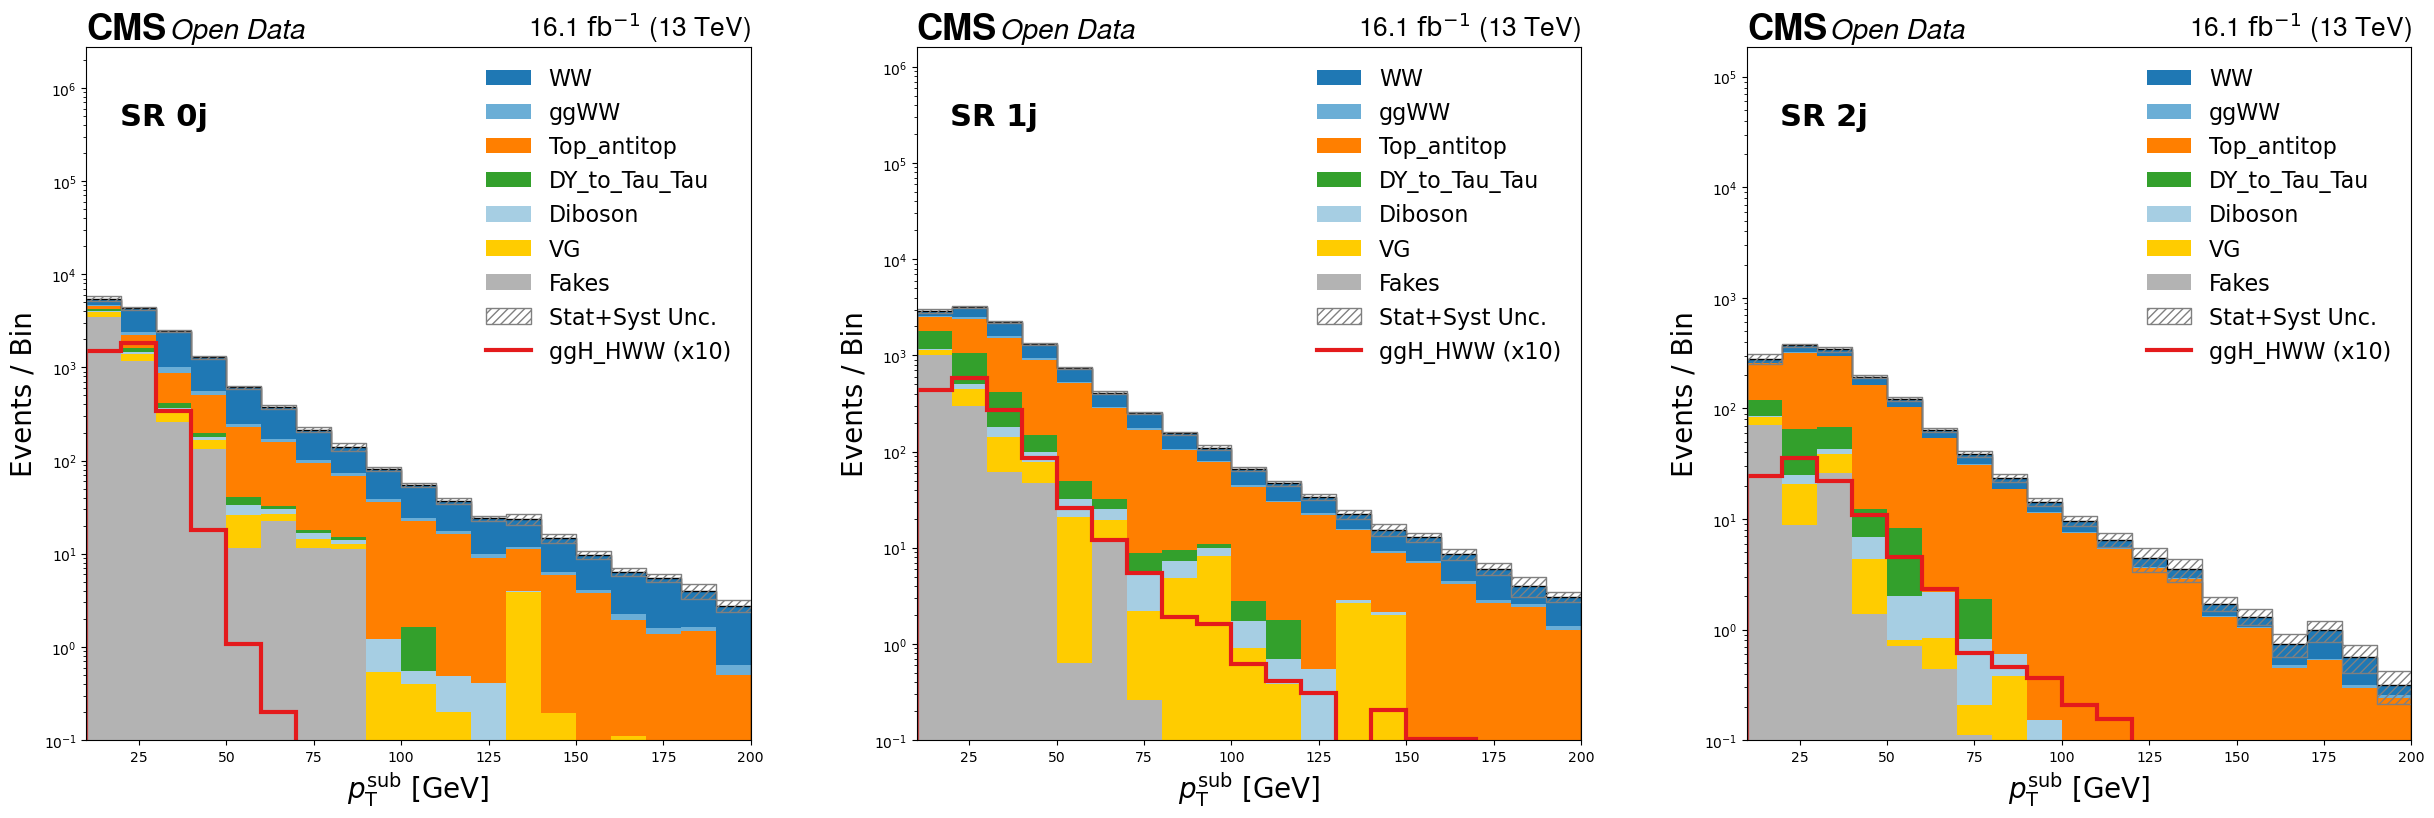

Plotting subleading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked/CMS_Control_Region_Top_subleading_pt.png


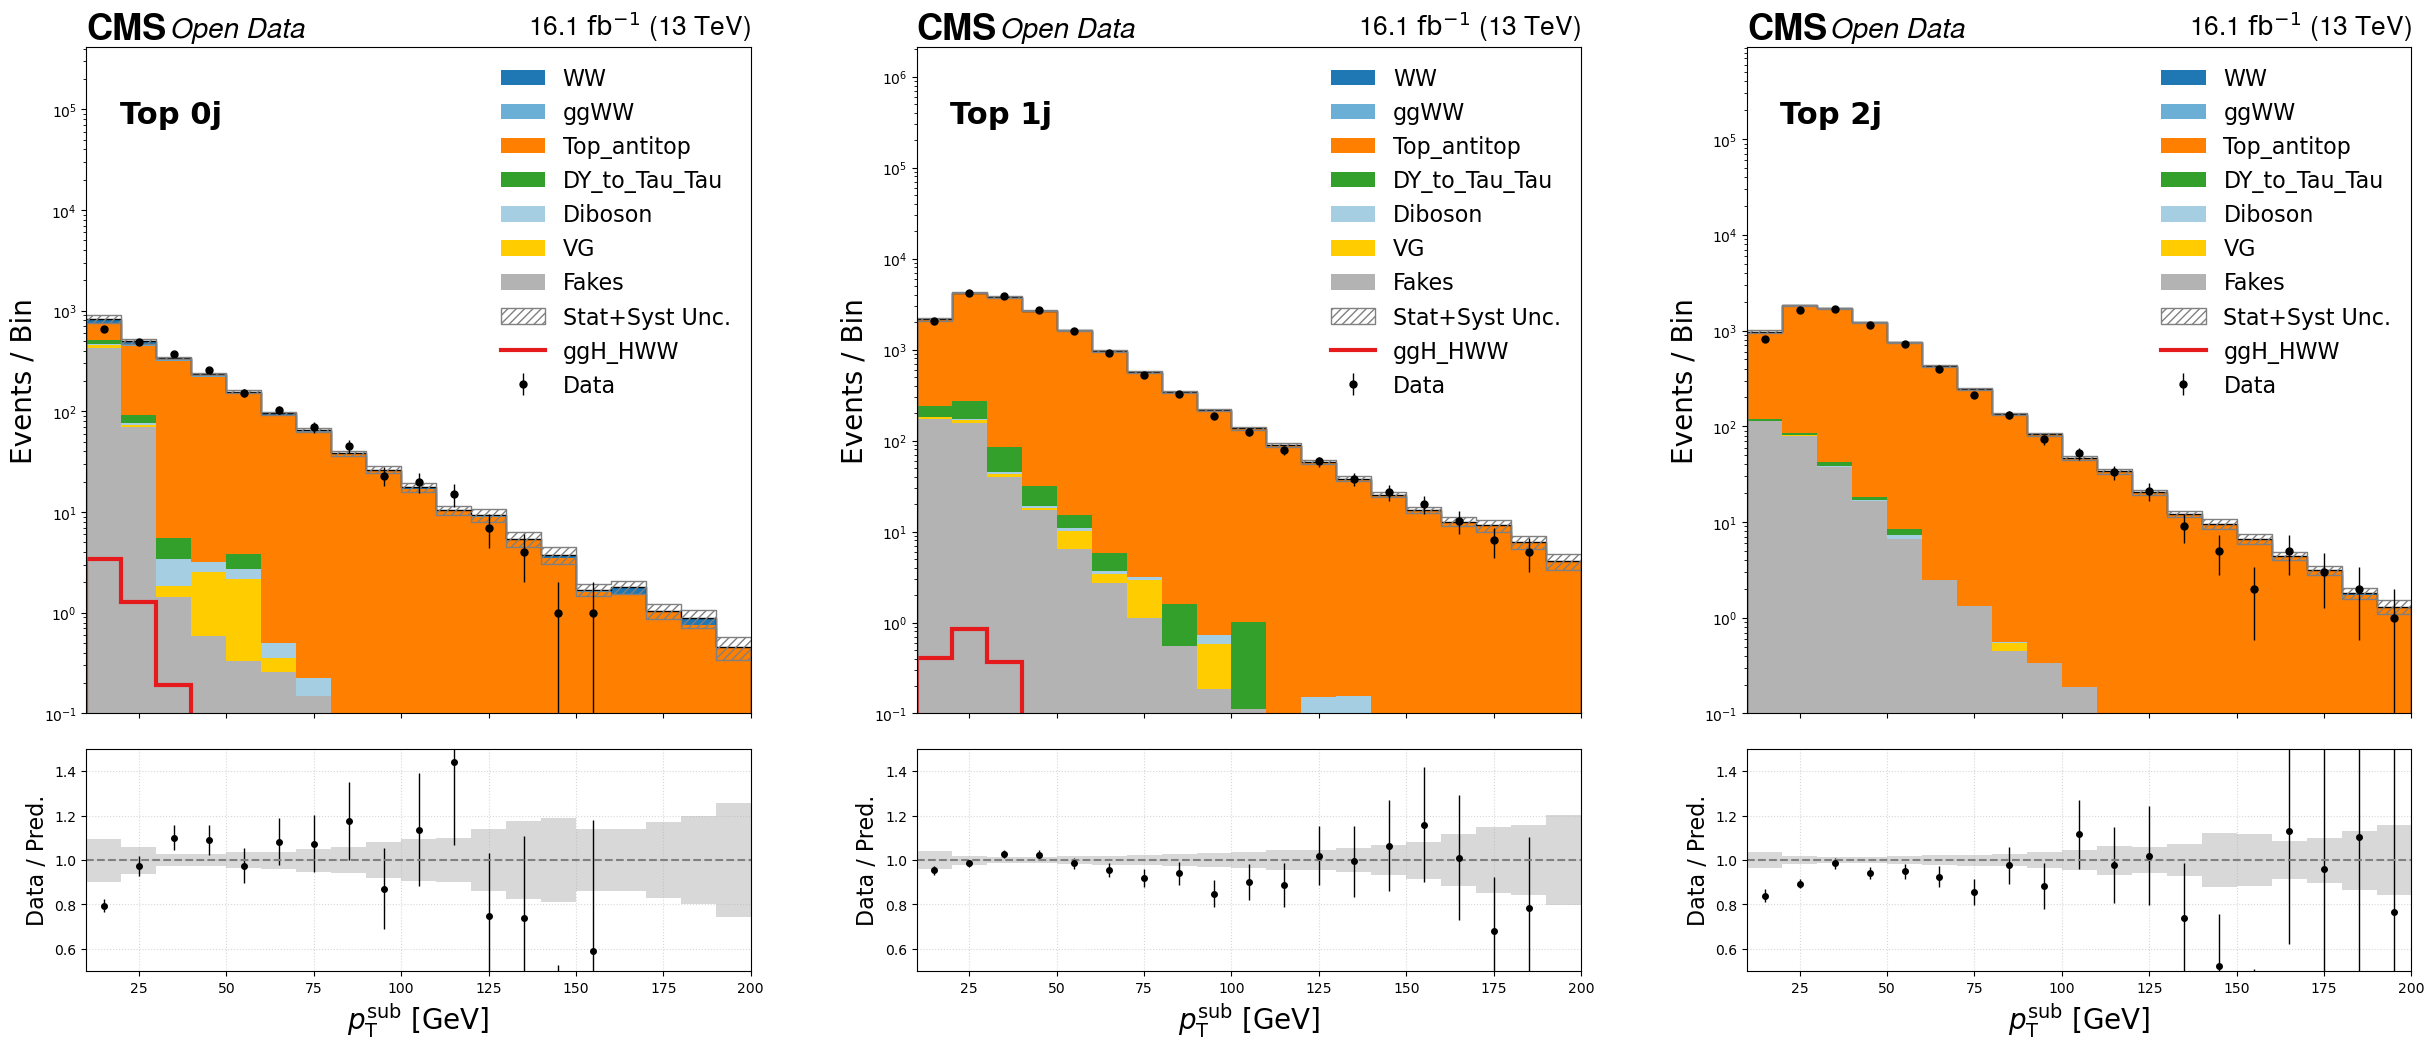


All plots saved to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/notebooks/Outputs/Plots/Stacked


In [32]:
print("\n" + "="*70)
print("GENERATING STACKED PLOTS ...")
print("="*70)

# Ensure output directory exists
output_dir = PLOTS_DIR / "Stacked"
output_dir.mkdir(parents=True, exist_ok=True)

# Loop over all variables defined in your configuration
for variable in VAR_LABELS.keys():
    try:
        stacked_plots(
            variable=variable, 
            hist_data_all=hist_data_final, 
            output_dir=output_dir
        )
    except Exception as e:
        print(f"FAILED to plot {variable}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nAll plots saved to: {output_dir}")